In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "0"

In [3]:
# Parameters
ood = 1


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 364215 images
Dataset type val label type: species


Loaded 47159 images
Dataset type test label type: species


Loaded 47386 images
Dataset type train label type: species


Loaded 11228 images
Dataset type val label type: species


Loaded 1403 images
Dataset type test label type: species


Loaded 1404 images


In [6]:
# model ids
model_ids = {"0": '3qdutcy1', "1": 'czgx4bod', "2": '72y7x1fk', "3": 'cqp59iho', "4": 'fwur6c78'}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

1 czgx4bod


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                | 0/5691 [00:00<?, ?it/s]

  0%|                                                                                                      | 1/5691 [00:00<1:18:32,  1.21it/s]

  0%|                                                                                                        | 3/5691 [00:00<24:57,  3.80it/s]

  0%|                                                                                                        | 5/5691 [00:01<14:55,  6.35it/s]

  0%|▏                                                                                                       | 7/5691 [00:01<10:51,  8.72it/s]

  0%|▏                                                                                                       | 9/5691 [00:01<08:44, 10.83it/s]

  0%|▏                                                                                                      | 11/5691 [00:01<07:31, 12.59it/s]

  0%|▏                                                                                                      | 13/5691 [00:01<06:45, 13.99it/s]

  0%|▎                                                                                                      | 15/5691 [00:01<06:17, 15.03it/s]

  0%|▎                                                                                                      | 17/5691 [00:01<05:57, 15.89it/s]

  0%|▎                                                                                                      | 19/5691 [00:01<05:43, 16.52it/s]

  0%|▍                                                                                                      | 21/5691 [00:01<05:36, 16.86it/s]

  0%|▍                                                                                                      | 23/5691 [00:02<05:31, 17.08it/s]

  0%|▍                                                                                                      | 25/5691 [00:02<05:29, 17.19it/s]

  0%|▍                                                                                                      | 27/5691 [00:02<05:28, 17.25it/s]

  1%|▌                                                                                                      | 29/5691 [00:02<05:26, 17.33it/s]

  1%|▌                                                                                                      | 31/5691 [00:02<05:25, 17.39it/s]

  1%|▌                                                                                                      | 33/5691 [00:02<05:24, 17.42it/s]

  1%|▋                                                                                                      | 35/5691 [00:02<05:24, 17.43it/s]

  1%|▋                                                                                                      | 37/5691 [00:02<05:25, 17.38it/s]

  1%|▋                                                                                                      | 39/5691 [00:02<05:24, 17.40it/s]

  1%|▋                                                                                                      | 41/5691 [00:03<05:25, 17.37it/s]

  1%|▊                                                                                                      | 43/5691 [00:03<05:25, 17.33it/s]

  1%|▊                                                                                                      | 45/5691 [00:03<05:24, 17.40it/s]

  1%|▊                                                                                                      | 47/5691 [00:03<05:25, 17.36it/s]

  1%|▉                                                                                                      | 49/5691 [00:03<05:25, 17.34it/s]

  1%|▉                                                                                                      | 51/5691 [00:03<05:25, 17.34it/s]

  1%|▉                                                                                                      | 53/5691 [00:03<05:24, 17.36it/s]

  1%|▉                                                                                                      | 55/5691 [00:03<05:23, 17.41it/s]

  1%|█                                                                                                      | 57/5691 [00:04<05:24, 17.35it/s]

  1%|█                                                                                                      | 59/5691 [00:04<05:24, 17.35it/s]

  1%|█                                                                                                      | 61/5691 [00:04<05:21, 17.51it/s]

  1%|█▏                                                                                                     | 63/5691 [00:04<05:20, 17.53it/s]

  1%|█▏                                                                                                     | 65/5691 [00:04<05:22, 17.46it/s]

  1%|█▏                                                                                                     | 67/5691 [00:04<05:23, 17.40it/s]

  1%|█▏                                                                                                     | 69/5691 [00:04<05:21, 17.46it/s]

  1%|█▎                                                                                                     | 71/5691 [00:04<05:22, 17.42it/s]

  1%|█▎                                                                                                     | 73/5691 [00:04<05:23, 17.35it/s]

  1%|█▎                                                                                                     | 75/5691 [00:05<05:23, 17.35it/s]

  1%|█▍                                                                                                     | 77/5691 [00:05<05:24, 17.33it/s]

  1%|█▍                                                                                                     | 79/5691 [00:05<05:23, 17.34it/s]

  1%|█▍                                                                                                     | 81/5691 [00:05<05:23, 17.36it/s]

  1%|█▌                                                                                                     | 83/5691 [00:05<05:22, 17.37it/s]

  1%|█▌                                                                                                     | 85/5691 [00:05<05:21, 17.42it/s]

  2%|█▌                                                                                                     | 87/5691 [00:05<05:22, 17.39it/s]

  2%|█▌                                                                                                     | 89/5691 [00:05<05:22, 17.36it/s]

  2%|█▋                                                                                                     | 91/5691 [00:05<05:21, 17.39it/s]

  2%|█▋                                                                                                     | 93/5691 [00:06<05:21, 17.42it/s]

  2%|█▋                                                                                                     | 95/5691 [00:06<05:22, 17.35it/s]

  2%|█▊                                                                                                     | 97/5691 [00:06<05:22, 17.33it/s]

  2%|█▊                                                                                                     | 99/5691 [00:06<05:22, 17.35it/s]

  2%|█▊                                                                                                    | 101/5691 [00:06<05:22, 17.33it/s]

  2%|█▊                                                                                                    | 103/5691 [00:06<05:21, 17.38it/s]

  2%|█▉                                                                                                    | 105/5691 [00:06<05:22, 17.32it/s]

  2%|█▉                                                                                                    | 107/5691 [00:06<05:22, 17.30it/s]

  2%|█▉                                                                                                    | 109/5691 [00:07<05:20, 17.39it/s]

  2%|█▉                                                                                                    | 111/5691 [00:07<05:21, 17.36it/s]

  2%|██                                                                                                    | 113/5691 [00:07<05:21, 17.34it/s]

  2%|██                                                                                                    | 115/5691 [00:07<05:19, 17.43it/s]

  2%|██                                                                                                    | 117/5691 [00:07<05:20, 17.41it/s]

  2%|██▏                                                                                                   | 119/5691 [00:07<05:21, 17.35it/s]

  2%|██▏                                                                                                   | 121/5691 [00:07<05:20, 17.38it/s]

  2%|██▏                                                                                                   | 123/5691 [00:07<05:21, 17.32it/s]

  2%|██▏                                                                                                   | 125/5691 [00:07<05:21, 17.31it/s]

  2%|██▎                                                                                                   | 127/5691 [00:08<05:21, 17.32it/s]

  2%|██▎                                                                                                   | 129/5691 [00:08<05:20, 17.34it/s]

  2%|██▎                                                                                                   | 131/5691 [00:08<05:24, 17.16it/s]

  2%|██▍                                                                                                   | 133/5691 [00:08<05:22, 17.23it/s]

  2%|██▍                                                                                                   | 135/5691 [00:08<05:20, 17.33it/s]

  2%|██▍                                                                                                   | 137/5691 [00:08<05:20, 17.36it/s]

  2%|██▍                                                                                                   | 139/5691 [00:08<05:19, 17.36it/s]

  2%|██▌                                                                                                   | 141/5691 [00:08<05:18, 17.42it/s]

  3%|██▌                                                                                                   | 143/5691 [00:08<05:18, 17.41it/s]

  3%|██▌                                                                                                   | 145/5691 [00:09<05:18, 17.41it/s]

  3%|██▋                                                                                                   | 147/5691 [00:09<05:18, 17.42it/s]

  3%|██▋                                                                                                   | 149/5691 [00:09<05:17, 17.43it/s]

  3%|██▋                                                                                                   | 151/5691 [00:09<05:17, 17.45it/s]

  3%|██▋                                                                                                   | 153/5691 [00:09<05:17, 17.43it/s]

  3%|██▊                                                                                                   | 155/5691 [00:09<05:18, 17.39it/s]

  3%|██▊                                                                                                   | 157/5691 [00:09<05:18, 17.40it/s]

  3%|██▊                                                                                                   | 159/5691 [00:09<05:17, 17.44it/s]

  3%|██▉                                                                                                   | 161/5691 [00:10<05:14, 17.59it/s]

  3%|██▉                                                                                                   | 163/5691 [00:10<05:10, 17.80it/s]

  3%|██▉                                                                                                   | 165/5691 [00:10<05:08, 17.91it/s]

  3%|██▉                                                                                                   | 167/5691 [00:10<05:07, 17.98it/s]

  3%|███                                                                                                   | 169/5691 [00:10<05:05, 18.06it/s]

  3%|███                                                                                                   | 171/5691 [00:10<05:03, 18.19it/s]

  3%|███                                                                                                   | 173/5691 [00:10<05:03, 18.21it/s]

  3%|███▏                                                                                                  | 175/5691 [00:10<05:02, 18.24it/s]

  3%|███▏                                                                                                  | 177/5691 [00:10<05:02, 18.26it/s]

  3%|███▏                                                                                                  | 179/5691 [00:10<05:00, 18.33it/s]

  3%|███▏                                                                                                  | 181/5691 [00:11<04:59, 18.37it/s]

  3%|███▎                                                                                                  | 183/5691 [00:11<04:59, 18.40it/s]

  3%|███▎                                                                                                  | 185/5691 [00:11<04:59, 18.35it/s]

  3%|███▎                                                                                                  | 187/5691 [00:11<05:00, 18.31it/s]

  3%|███▍                                                                                                  | 189/5691 [00:11<05:01, 18.27it/s]

  3%|███▍                                                                                                  | 191/5691 [00:11<05:01, 18.24it/s]

  3%|███▍                                                                                                  | 193/5691 [00:11<05:01, 18.24it/s]

  3%|███▍                                                                                                  | 195/5691 [00:11<05:01, 18.24it/s]

  3%|███▌                                                                                                  | 197/5691 [00:11<05:01, 18.22it/s]

  3%|███▌                                                                                                  | 199/5691 [00:12<05:00, 18.27it/s]

  4%|███▌                                                                                                  | 201/5691 [00:12<05:00, 18.27it/s]

  4%|███▋                                                                                                  | 203/5691 [00:12<05:01, 18.22it/s]

  4%|███▋                                                                                                  | 205/5691 [00:12<05:00, 18.23it/s]

  4%|███▋                                                                                                  | 207/5691 [00:12<04:59, 18.30it/s]

  4%|███▋                                                                                                  | 209/5691 [00:12<05:03, 18.06it/s]

  4%|███▊                                                                                                  | 211/5691 [00:12<05:06, 17.89it/s]

  4%|███▊                                                                                                  | 213/5691 [00:12<05:08, 17.75it/s]

  4%|███▊                                                                                                  | 215/5691 [00:12<05:08, 17.72it/s]

  4%|███▉                                                                                                  | 217/5691 [00:13<05:10, 17.63it/s]

  4%|███▉                                                                                                  | 219/5691 [00:13<05:11, 17.59it/s]

  4%|███▉                                                                                                  | 221/5691 [00:13<05:12, 17.53it/s]

  4%|███▉                                                                                                  | 223/5691 [00:13<05:11, 17.56it/s]

  4%|████                                                                                                  | 225/5691 [00:13<05:11, 17.56it/s]

  4%|████                                                                                                  | 227/5691 [00:13<05:11, 17.56it/s]

  4%|████                                                                                                  | 229/5691 [00:13<05:11, 17.54it/s]

  4%|████▏                                                                                                 | 231/5691 [00:13<05:10, 17.57it/s]

  4%|████▏                                                                                                 | 233/5691 [00:14<05:10, 17.59it/s]

  4%|████▏                                                                                                 | 235/5691 [00:14<05:08, 17.69it/s]

  4%|████▏                                                                                                 | 237/5691 [00:14<05:09, 17.63it/s]

  4%|████▎                                                                                                 | 239/5691 [00:14<05:09, 17.61it/s]

  4%|████▎                                                                                                 | 241/5691 [00:14<05:08, 17.64it/s]

  4%|████▎                                                                                                 | 243/5691 [00:14<05:08, 17.65it/s]

  4%|████▍                                                                                                 | 245/5691 [00:14<05:09, 17.58it/s]

  4%|████▍                                                                                                 | 247/5691 [00:14<05:09, 17.57it/s]

  4%|████▍                                                                                                 | 249/5691 [00:14<05:11, 17.48it/s]

  4%|████▍                                                                                                 | 251/5691 [00:15<05:09, 17.60it/s]

  4%|████▌                                                                                                 | 253/5691 [00:15<05:06, 17.75it/s]

  4%|████▌                                                                                                 | 255/5691 [00:15<05:03, 17.93it/s]

  5%|████▌                                                                                                 | 257/5691 [00:15<05:00, 18.06it/s]

  5%|████▋                                                                                                 | 259/5691 [00:15<04:59, 18.12it/s]

  5%|████▋                                                                                                 | 261/5691 [00:15<04:59, 18.14it/s]

  5%|████▋                                                                                                 | 263/5691 [00:15<04:58, 18.18it/s]

  5%|████▋                                                                                                 | 265/5691 [00:15<04:58, 18.20it/s]

  5%|████▊                                                                                                 | 267/5691 [00:15<04:56, 18.27it/s]

  5%|████▊                                                                                                 | 269/5691 [00:16<04:56, 18.29it/s]

  5%|████▊                                                                                                 | 271/5691 [00:16<04:56, 18.28it/s]

  5%|████▉                                                                                                 | 273/5691 [00:16<04:56, 18.26it/s]

  5%|████▉                                                                                                 | 275/5691 [00:16<04:55, 18.33it/s]

  5%|████▉                                                                                                 | 277/5691 [00:16<04:55, 18.32it/s]

  5%|█████                                                                                                 | 279/5691 [00:16<04:55, 18.32it/s]

  5%|█████                                                                                                 | 281/5691 [00:16<04:56, 18.27it/s]

  5%|█████                                                                                                 | 283/5691 [00:16<04:59, 18.04it/s]

  5%|█████                                                                                                 | 285/5691 [00:16<04:59, 18.07it/s]

  5%|█████▏                                                                                                | 287/5691 [00:17<04:57, 18.14it/s]

  5%|█████▏                                                                                                | 289/5691 [00:17<04:57, 18.18it/s]

  5%|█████▏                                                                                                | 291/5691 [00:17<04:57, 18.13it/s]

  5%|█████▎                                                                                                | 293/5691 [00:17<04:58, 18.11it/s]

  5%|█████▎                                                                                                | 295/5691 [00:17<04:57, 18.17it/s]

  5%|█████▎                                                                                                | 297/5691 [00:17<04:57, 18.12it/s]

  5%|█████▎                                                                                                | 299/5691 [00:17<04:57, 18.11it/s]

  5%|█████▍                                                                                                | 301/5691 [00:17<04:57, 18.11it/s]

  5%|█████▍                                                                                                | 303/5691 [00:17<04:57, 18.12it/s]

  5%|█████▍                                                                                                | 305/5691 [00:18<04:56, 18.15it/s]

  5%|█████▌                                                                                                | 307/5691 [00:18<04:56, 18.18it/s]

  5%|█████▌                                                                                                | 309/5691 [00:18<04:56, 18.14it/s]

  5%|█████▌                                                                                                | 311/5691 [00:18<04:56, 18.15it/s]

  5%|█████▌                                                                                                | 313/5691 [00:18<04:57, 18.09it/s]

  6%|█████▋                                                                                                | 315/5691 [00:18<04:56, 18.12it/s]

  6%|█████▋                                                                                                | 317/5691 [00:18<04:58, 18.03it/s]

  6%|█████▋                                                                                                | 319/5691 [00:18<04:57, 18.03it/s]

  6%|█████▊                                                                                                | 321/5691 [00:18<04:57, 18.05it/s]

  6%|█████▊                                                                                                | 323/5691 [00:18<04:56, 18.08it/s]

  6%|█████▊                                                                                                | 325/5691 [00:19<04:55, 18.13it/s]

  6%|█████▊                                                                                                | 327/5691 [00:19<04:57, 18.06it/s]

  6%|█████▉                                                                                                | 329/5691 [00:19<04:59, 17.90it/s]

  6%|█████▉                                                                                                | 331/5691 [00:19<04:58, 17.94it/s]

  6%|█████▉                                                                                                | 333/5691 [00:19<04:57, 18.00it/s]

  6%|██████                                                                                                | 335/5691 [00:19<04:56, 18.05it/s]

  6%|██████                                                                                                | 337/5691 [00:19<04:55, 18.10it/s]

  6%|██████                                                                                                | 339/5691 [00:19<04:55, 18.11it/s]

  6%|██████                                                                                                | 341/5691 [00:19<04:55, 18.11it/s]

  6%|██████▏                                                                                               | 343/5691 [00:20<04:54, 18.16it/s]

  6%|██████▏                                                                                               | 345/5691 [00:20<04:54, 18.16it/s]

  6%|██████▏                                                                                               | 347/5691 [00:20<04:54, 18.18it/s]

  6%|██████▎                                                                                               | 349/5691 [00:20<04:54, 18.15it/s]

  6%|██████▎                                                                                               | 351/5691 [00:20<04:54, 18.16it/s]

  6%|██████▎                                                                                               | 353/5691 [00:20<04:53, 18.18it/s]

  6%|██████▎                                                                                               | 355/5691 [00:20<04:52, 18.23it/s]

  6%|██████▍                                                                                               | 357/5691 [00:20<04:53, 18.18it/s]

  6%|██████▍                                                                                               | 359/5691 [00:20<04:53, 18.18it/s]

  6%|██████▍                                                                                               | 361/5691 [00:21<04:54, 18.09it/s]

  6%|██████▌                                                                                               | 363/5691 [00:21<04:55, 18.01it/s]

  6%|██████▌                                                                                               | 365/5691 [00:21<04:57, 17.93it/s]

  6%|██████▌                                                                                               | 367/5691 [00:21<04:55, 18.00it/s]

  6%|██████▌                                                                                               | 369/5691 [00:21<04:54, 18.05it/s]

  7%|██████▋                                                                                               | 371/5691 [00:21<04:54, 18.06it/s]

  7%|██████▋                                                                                               | 373/5691 [00:21<04:53, 18.12it/s]

  7%|██████▋                                                                                               | 375/5691 [00:21<04:53, 18.13it/s]

  7%|██████▊                                                                                               | 377/5691 [00:21<04:53, 18.13it/s]

  7%|██████▊                                                                                               | 379/5691 [00:22<04:53, 18.11it/s]

  7%|██████▊                                                                                               | 381/5691 [00:22<04:53, 18.11it/s]

  7%|██████▊                                                                                               | 383/5691 [00:22<04:52, 18.15it/s]

  7%|██████▉                                                                                               | 385/5691 [00:22<04:52, 18.14it/s]

  7%|██████▉                                                                                               | 387/5691 [00:22<04:52, 18.15it/s]

  7%|██████▉                                                                                               | 389/5691 [00:22<04:52, 18.14it/s]

  7%|███████                                                                                               | 391/5691 [00:22<04:51, 18.18it/s]

  7%|███████                                                                                               | 393/5691 [00:22<04:51, 18.18it/s]

  7%|███████                                                                                               | 395/5691 [00:22<04:50, 18.22it/s]

  7%|███████                                                                                               | 397/5691 [00:23<04:50, 18.24it/s]

  7%|███████▏                                                                                              | 399/5691 [00:23<04:49, 18.26it/s]

  7%|███████▏                                                                                              | 401/5691 [00:23<04:50, 18.20it/s]

  7%|███████▏                                                                                              | 403/5691 [00:23<04:49, 18.25it/s]

  7%|███████▎                                                                                              | 405/5691 [00:23<04:49, 18.25it/s]

  7%|███████▎                                                                                              | 407/5691 [00:23<04:50, 18.21it/s]

  7%|███████▎                                                                                              | 409/5691 [00:23<04:49, 18.22it/s]

  7%|███████▎                                                                                              | 411/5691 [00:23<04:50, 18.20it/s]

  7%|███████▍                                                                                              | 413/5691 [00:23<04:50, 18.18it/s]

  7%|███████▍                                                                                              | 415/5691 [00:24<04:50, 18.18it/s]

  7%|███████▍                                                                                              | 417/5691 [00:24<04:50, 18.18it/s]

  7%|███████▌                                                                                              | 419/5691 [00:24<04:49, 18.24it/s]

  7%|███████▌                                                                                              | 421/5691 [00:24<04:49, 18.22it/s]

  7%|███████▌                                                                                              | 423/5691 [00:24<04:49, 18.19it/s]

  7%|███████▌                                                                                              | 425/5691 [00:24<04:49, 18.17it/s]

  8%|███████▋                                                                                              | 427/5691 [00:24<04:49, 18.19it/s]

  8%|███████▋                                                                                              | 429/5691 [00:24<04:49, 18.16it/s]

  8%|███████▋                                                                                              | 431/5691 [00:24<04:49, 18.18it/s]

  8%|███████▊                                                                                              | 433/5691 [00:25<04:48, 18.22it/s]

  8%|███████▊                                                                                              | 435/5691 [00:25<04:48, 18.21it/s]

  8%|███████▊                                                                                              | 437/5691 [00:25<04:49, 18.16it/s]

  8%|███████▊                                                                                              | 439/5691 [00:25<04:48, 18.19it/s]

  8%|███████▉                                                                                              | 441/5691 [00:25<04:48, 18.17it/s]

  8%|███████▉                                                                                              | 443/5691 [00:25<04:48, 18.19it/s]

  8%|███████▉                                                                                              | 445/5691 [00:25<04:48, 18.18it/s]

  8%|████████                                                                                              | 447/5691 [00:25<04:48, 18.20it/s]

  8%|████████                                                                                              | 449/5691 [00:25<04:47, 18.22it/s]

  8%|████████                                                                                              | 451/5691 [00:26<04:47, 18.24it/s]

  8%|████████                                                                                              | 453/5691 [00:26<04:47, 18.22it/s]

  8%|████████▏                                                                                             | 455/5691 [00:26<04:48, 18.16it/s]

  8%|████████▏                                                                                             | 457/5691 [00:26<04:48, 18.16it/s]

  8%|████████▏                                                                                             | 459/5691 [00:26<04:47, 18.19it/s]

  8%|████████▎                                                                                             | 461/5691 [00:26<04:47, 18.16it/s]

  8%|████████▎                                                                                             | 463/5691 [00:26<04:47, 18.19it/s]

  8%|████████▎                                                                                             | 465/5691 [00:26<04:47, 18.20it/s]

  8%|████████▎                                                                                             | 467/5691 [00:26<04:46, 18.21it/s]

  8%|████████▍                                                                                             | 469/5691 [00:27<04:47, 18.18it/s]

  8%|████████▍                                                                                             | 471/5691 [00:27<04:46, 18.19it/s]

  8%|████████▍                                                                                             | 473/5691 [00:27<04:47, 18.18it/s]

  8%|████████▌                                                                                             | 475/5691 [00:27<04:46, 18.18it/s]

  8%|████████▌                                                                                             | 477/5691 [00:27<04:47, 18.14it/s]

  8%|████████▌                                                                                             | 479/5691 [00:27<04:47, 18.14it/s]

  8%|████████▌                                                                                             | 481/5691 [00:27<04:47, 18.13it/s]

  8%|████████▋                                                                                             | 483/5691 [00:27<04:46, 18.16it/s]

  9%|████████▋                                                                                             | 485/5691 [00:27<04:46, 18.17it/s]

  9%|████████▋                                                                                             | 487/5691 [00:28<04:46, 18.18it/s]

  9%|████████▊                                                                                             | 489/5691 [00:28<04:46, 18.15it/s]

  9%|████████▊                                                                                             | 491/5691 [00:28<04:46, 18.16it/s]

  9%|████████▊                                                                                             | 493/5691 [00:28<04:45, 18.22it/s]

  9%|████████▊                                                                                             | 495/5691 [00:28<04:45, 18.21it/s]

  9%|████████▉                                                                                             | 497/5691 [00:28<04:46, 18.14it/s]

  9%|████████▉                                                                                             | 499/5691 [00:28<04:46, 18.13it/s]

  9%|████████▉                                                                                             | 501/5691 [00:28<04:46, 18.12it/s]

  9%|█████████                                                                                             | 503/5691 [00:28<04:45, 18.15it/s]

  9%|█████████                                                                                             | 505/5691 [00:29<04:45, 18.15it/s]

  9%|█████████                                                                                             | 507/5691 [00:29<04:46, 18.12it/s]

  9%|█████████                                                                                             | 509/5691 [00:29<04:45, 18.13it/s]

  9%|█████████▏                                                                                            | 511/5691 [00:29<04:44, 18.19it/s]

  9%|█████████▏                                                                                            | 513/5691 [00:29<04:45, 18.16it/s]

  9%|█████████▏                                                                                            | 515/5691 [00:29<04:45, 18.15it/s]

  9%|█████████▎                                                                                            | 517/5691 [00:29<04:45, 18.12it/s]

  9%|█████████▎                                                                                            | 519/5691 [00:29<04:45, 18.14it/s]

  9%|█████████▎                                                                                            | 521/5691 [00:29<04:45, 18.12it/s]

  9%|█████████▎                                                                                            | 523/5691 [00:30<04:47, 18.00it/s]

  9%|█████████▍                                                                                            | 525/5691 [00:30<04:47, 17.95it/s]

  9%|█████████▍                                                                                            | 527/5691 [00:30<04:47, 17.94it/s]

  9%|█████████▍                                                                                            | 529/5691 [00:30<04:48, 17.91it/s]

  9%|█████████▌                                                                                            | 531/5691 [00:30<04:49, 17.85it/s]

  9%|█████████▌                                                                                            | 533/5691 [00:30<04:49, 17.84it/s]

  9%|█████████▌                                                                                            | 535/5691 [00:30<04:48, 17.90it/s]

  9%|█████████▌                                                                                            | 537/5691 [00:30<04:47, 17.95it/s]

  9%|█████████▋                                                                                            | 539/5691 [00:30<04:46, 17.97it/s]

 10%|█████████▋                                                                                            | 541/5691 [00:31<04:45, 18.01it/s]

 10%|█████████▋                                                                                            | 543/5691 [00:31<04:44, 18.09it/s]

 10%|█████████▊                                                                                            | 545/5691 [00:31<04:47, 17.91it/s]

 10%|█████████▊                                                                                            | 547/5691 [00:31<04:45, 18.02it/s]

 10%|█████████▊                                                                                            | 549/5691 [00:31<04:44, 18.08it/s]

 10%|█████████▉                                                                                            | 551/5691 [00:31<04:42, 18.20it/s]

 10%|█████████▉                                                                                            | 553/5691 [00:31<04:42, 18.21it/s]

 10%|█████████▉                                                                                            | 555/5691 [00:31<04:42, 18.21it/s]

 10%|█████████▉                                                                                            | 557/5691 [00:31<04:42, 18.18it/s]

 10%|██████████                                                                                            | 559/5691 [00:32<04:43, 18.09it/s]

 10%|██████████                                                                                            | 561/5691 [00:32<04:46, 17.91it/s]

 10%|██████████                                                                                            | 563/5691 [00:32<04:48, 17.77it/s]

 10%|██████████▏                                                                                           | 565/5691 [00:32<04:47, 17.80it/s]

 10%|██████████▏                                                                                           | 567/5691 [00:32<04:47, 17.84it/s]

 10%|██████████▏                                                                                           | 569/5691 [00:32<04:47, 17.82it/s]

 10%|██████████▏                                                                                           | 571/5691 [00:32<04:46, 17.85it/s]

 10%|██████████▎                                                                                           | 573/5691 [00:32<04:45, 17.93it/s]

 10%|██████████▎                                                                                           | 575/5691 [00:32<04:44, 18.00it/s]

 10%|██████████▎                                                                                           | 577/5691 [00:33<04:43, 18.06it/s]

 10%|██████████▍                                                                                           | 579/5691 [00:33<04:41, 18.13it/s]

 10%|██████████▍                                                                                           | 581/5691 [00:33<04:42, 18.11it/s]

 10%|██████████▍                                                                                           | 583/5691 [00:33<04:41, 18.17it/s]

 10%|██████████▍                                                                                           | 585/5691 [00:33<04:40, 18.21it/s]

 10%|██████████▌                                                                                           | 587/5691 [00:33<04:39, 18.25it/s]

 10%|██████████▌                                                                                           | 589/5691 [00:33<04:39, 18.23it/s]

 10%|██████████▌                                                                                           | 591/5691 [00:33<04:39, 18.23it/s]

 10%|██████████▋                                                                                           | 593/5691 [00:33<04:40, 18.21it/s]

 10%|██████████▋                                                                                           | 595/5691 [00:34<04:39, 18.23it/s]

 10%|██████████▋                                                                                           | 597/5691 [00:34<04:39, 18.23it/s]

 11%|██████████▋                                                                                           | 599/5691 [00:34<04:39, 18.24it/s]

 11%|██████████▊                                                                                           | 601/5691 [00:34<04:39, 18.24it/s]

 11%|██████████▊                                                                                           | 603/5691 [00:34<04:38, 18.24it/s]

 11%|██████████▊                                                                                           | 605/5691 [00:34<04:38, 18.23it/s]

 11%|██████████▉                                                                                           | 607/5691 [00:34<04:39, 18.21it/s]

 11%|██████████▉                                                                                           | 609/5691 [00:34<04:39, 18.19it/s]

 11%|██████████▉                                                                                           | 611/5691 [00:34<04:39, 18.18it/s]

 11%|██████████▉                                                                                           | 613/5691 [00:34<04:39, 18.17it/s]

 11%|███████████                                                                                           | 615/5691 [00:35<04:37, 18.28it/s]

 11%|███████████                                                                                           | 617/5691 [00:35<04:37, 18.32it/s]

 11%|███████████                                                                                           | 619/5691 [00:35<04:37, 18.30it/s]

 11%|███████████▏                                                                                          | 621/5691 [00:35<04:37, 18.26it/s]

 11%|███████████▏                                                                                          | 623/5691 [00:35<04:38, 18.21it/s]

 11%|███████████▏                                                                                          | 625/5691 [00:35<04:38, 18.20it/s]

 11%|███████████▏                                                                                          | 627/5691 [00:35<04:37, 18.25it/s]

 11%|███████████▎                                                                                          | 629/5691 [00:35<04:37, 18.23it/s]

 11%|███████████▎                                                                                          | 631/5691 [00:35<04:36, 18.28it/s]

 11%|███████████▎                                                                                          | 633/5691 [00:36<04:36, 18.26it/s]

 11%|███████████▍                                                                                          | 635/5691 [00:36<04:37, 18.24it/s]

 11%|███████████▍                                                                                          | 637/5691 [00:36<04:36, 18.27it/s]

 11%|███████████▍                                                                                          | 639/5691 [00:36<04:36, 18.29it/s]

 11%|███████████▍                                                                                          | 641/5691 [00:36<04:35, 18.30it/s]

 11%|███████████▌                                                                                          | 643/5691 [00:36<04:35, 18.31it/s]

 11%|███████████▌                                                                                          | 645/5691 [00:36<04:35, 18.30it/s]

 11%|███████████▌                                                                                          | 647/5691 [00:36<04:36, 18.21it/s]

 11%|███████████▋                                                                                          | 649/5691 [00:36<04:36, 18.21it/s]

 11%|███████████▋                                                                                          | 651/5691 [00:37<04:36, 18.23it/s]

 11%|███████████▋                                                                                          | 653/5691 [00:37<04:35, 18.27it/s]

 12%|███████████▋                                                                                          | 655/5691 [00:37<04:34, 18.36it/s]

 12%|███████████▊                                                                                          | 657/5691 [00:37<04:34, 18.34it/s]

 12%|███████████▊                                                                                          | 659/5691 [00:37<04:34, 18.30it/s]

 12%|███████████▊                                                                                          | 661/5691 [00:37<04:35, 18.27it/s]

 12%|███████████▉                                                                                          | 663/5691 [00:37<04:34, 18.31it/s]

 12%|███████████▉                                                                                          | 665/5691 [00:37<04:34, 18.28it/s]

 12%|███████████▉                                                                                          | 667/5691 [00:37<04:34, 18.30it/s]

 12%|███████████▉                                                                                          | 669/5691 [00:38<04:34, 18.28it/s]

 12%|████████████                                                                                          | 671/5691 [00:38<04:35, 18.25it/s]

 12%|████████████                                                                                          | 673/5691 [00:38<04:34, 18.25it/s]

 12%|████████████                                                                                          | 675/5691 [00:38<04:34, 18.24it/s]

 12%|████████████▏                                                                                         | 677/5691 [00:38<04:35, 18.23it/s]

 12%|████████████▏                                                                                         | 679/5691 [00:38<04:34, 18.24it/s]

 12%|████████████▏                                                                                         | 681/5691 [00:38<04:34, 18.26it/s]

 12%|████████████▏                                                                                         | 683/5691 [00:38<04:33, 18.30it/s]

 12%|████████████▎                                                                                         | 685/5691 [00:38<04:33, 18.30it/s]

 12%|████████████▎                                                                                         | 687/5691 [00:39<04:33, 18.29it/s]

 12%|████████████▎                                                                                         | 689/5691 [00:39<04:33, 18.28it/s]

 12%|████████████▍                                                                                         | 691/5691 [00:39<04:33, 18.27it/s]

 12%|████████████▍                                                                                         | 693/5691 [00:39<04:33, 18.25it/s]

 12%|████████████▍                                                                                         | 695/5691 [00:39<04:33, 18.27it/s]

 12%|████████████▍                                                                                         | 697/5691 [00:39<04:33, 18.26it/s]

 12%|████████████▌                                                                                         | 699/5691 [00:39<04:33, 18.28it/s]

 12%|████████████▌                                                                                         | 701/5691 [00:39<04:38, 17.94it/s]

 12%|████████████▌                                                                                         | 703/5691 [00:39<04:35, 18.07it/s]

 12%|████████████▋                                                                                         | 705/5691 [00:40<04:35, 18.10it/s]

 12%|████████████▋                                                                                         | 707/5691 [00:40<04:35, 18.12it/s]

 12%|████████████▋                                                                                         | 709/5691 [00:40<04:34, 18.12it/s]

 12%|████████████▋                                                                                         | 711/5691 [00:40<04:34, 18.16it/s]

 13%|████████████▊                                                                                         | 713/5691 [00:40<04:34, 18.15it/s]

 13%|████████████▊                                                                                         | 715/5691 [00:40<04:33, 18.18it/s]

 13%|████████████▊                                                                                         | 717/5691 [00:40<04:33, 18.18it/s]

 13%|████████████▉                                                                                         | 719/5691 [00:40<04:32, 18.24it/s]

 13%|████████████▉                                                                                         | 721/5691 [00:40<04:32, 18.25it/s]

 13%|████████████▉                                                                                         | 723/5691 [00:41<04:32, 18.21it/s]

 13%|████████████▉                                                                                         | 725/5691 [00:41<04:32, 18.21it/s]

 13%|█████████████                                                                                         | 727/5691 [00:41<04:33, 18.18it/s]

 13%|█████████████                                                                                         | 729/5691 [00:41<04:33, 18.17it/s]

 13%|█████████████                                                                                         | 731/5691 [00:41<04:32, 18.19it/s]

 13%|█████████████▏                                                                                        | 733/5691 [00:41<04:32, 18.21it/s]

 13%|█████████████▏                                                                                        | 735/5691 [00:41<04:32, 18.21it/s]

 13%|█████████████▏                                                                                        | 737/5691 [00:41<04:32, 18.19it/s]

 13%|█████████████▏                                                                                        | 739/5691 [00:41<04:31, 18.21it/s]

 13%|█████████████▎                                                                                        | 741/5691 [00:42<04:32, 18.19it/s]

 13%|█████████████▎                                                                                        | 743/5691 [00:42<04:31, 18.19it/s]

 13%|█████████████▎                                                                                        | 745/5691 [00:42<04:32, 18.17it/s]

 13%|█████████████▍                                                                                        | 747/5691 [00:42<04:32, 18.15it/s]

 13%|█████████████▍                                                                                        | 749/5691 [00:42<04:33, 18.10it/s]

 13%|█████████████▍                                                                                        | 751/5691 [00:42<04:32, 18.13it/s]

 13%|█████████████▍                                                                                        | 753/5691 [00:42<04:32, 18.10it/s]

 13%|█████████████▌                                                                                        | 755/5691 [00:42<04:32, 18.13it/s]

 13%|█████████████▌                                                                                        | 757/5691 [00:42<04:31, 18.15it/s]

 13%|█████████████▌                                                                                        | 759/5691 [00:43<04:31, 18.15it/s]

 13%|█████████████▋                                                                                        | 761/5691 [00:43<04:31, 18.17it/s]

 13%|█████████████▋                                                                                        | 763/5691 [00:43<04:30, 18.23it/s]

 13%|█████████████▋                                                                                        | 765/5691 [00:43<04:30, 18.23it/s]

 13%|█████████████▋                                                                                        | 767/5691 [00:43<04:30, 18.22it/s]

 14%|█████████████▊                                                                                        | 769/5691 [00:43<04:30, 18.20it/s]

 14%|█████████████▊                                                                                        | 771/5691 [00:43<04:30, 18.22it/s]

 14%|█████████████▊                                                                                        | 773/5691 [00:43<04:30, 18.20it/s]

 14%|█████████████▉                                                                                        | 775/5691 [00:43<04:29, 18.24it/s]

 14%|█████████████▉                                                                                        | 777/5691 [00:43<04:29, 18.21it/s]

 14%|█████████████▉                                                                                        | 779/5691 [00:44<04:29, 18.23it/s]

 14%|█████████████▉                                                                                        | 781/5691 [00:44<04:29, 18.24it/s]

 14%|██████████████                                                                                        | 783/5691 [00:44<04:29, 18.24it/s]

 14%|██████████████                                                                                        | 785/5691 [00:44<04:29, 18.23it/s]

 14%|██████████████                                                                                        | 787/5691 [00:44<04:28, 18.24it/s]

 14%|██████████████▏                                                                                       | 789/5691 [00:44<04:29, 18.20it/s]

 14%|██████████████▏                                                                                       | 791/5691 [00:44<04:29, 18.20it/s]

 14%|██████████████▏                                                                                       | 793/5691 [00:44<04:29, 18.20it/s]

 14%|██████████████▏                                                                                       | 795/5691 [00:44<04:28, 18.21it/s]

 14%|██████████████▎                                                                                       | 797/5691 [00:45<04:28, 18.21it/s]

 14%|██████████████▎                                                                                       | 799/5691 [00:45<04:28, 18.22it/s]

 14%|██████████████▎                                                                                       | 801/5691 [00:45<04:28, 18.21it/s]

 14%|██████████████▍                                                                                       | 803/5691 [00:45<04:28, 18.23it/s]

 14%|██████████████▍                                                                                       | 805/5691 [00:45<04:28, 18.19it/s]

 14%|██████████████▍                                                                                       | 807/5691 [00:45<04:28, 18.22it/s]

 14%|██████████████▍                                                                                       | 809/5691 [00:45<04:27, 18.22it/s]

 14%|██████████████▌                                                                                       | 811/5691 [00:45<04:27, 18.21it/s]

 14%|██████████████▌                                                                                       | 813/5691 [00:45<04:28, 18.17it/s]

 14%|██████████████▌                                                                                       | 815/5691 [00:46<04:28, 18.17it/s]

 14%|██████████████▋                                                                                       | 817/5691 [00:46<04:28, 18.15it/s]

 14%|██████████████▋                                                                                       | 819/5691 [00:46<04:28, 18.14it/s]

 14%|██████████████▋                                                                                       | 821/5691 [00:46<04:29, 18.10it/s]

 14%|██████████████▊                                                                                       | 823/5691 [00:46<04:28, 18.12it/s]

 14%|██████████████▊                                                                                       | 825/5691 [00:46<04:28, 18.13it/s]

 15%|██████████████▊                                                                                       | 827/5691 [00:46<04:27, 18.15it/s]

 15%|██████████████▊                                                                                       | 829/5691 [00:46<04:28, 18.13it/s]

 15%|██████████████▉                                                                                       | 831/5691 [00:46<04:27, 18.18it/s]

 15%|██████████████▉                                                                                       | 833/5691 [00:47<04:28, 18.11it/s]

 15%|██████████████▉                                                                                       | 835/5691 [00:47<04:28, 18.08it/s]

 15%|███████████████                                                                                       | 837/5691 [00:47<04:28, 18.06it/s]

 15%|███████████████                                                                                       | 839/5691 [00:47<04:28, 18.08it/s]

 15%|███████████████                                                                                       | 841/5691 [00:47<04:28, 18.09it/s]

 15%|███████████████                                                                                       | 843/5691 [00:47<04:27, 18.09it/s]

 15%|███████████████▏                                                                                      | 845/5691 [00:47<04:27, 18.11it/s]

 15%|███████████████▏                                                                                      | 847/5691 [00:47<04:26, 18.17it/s]

 15%|███████████████▏                                                                                      | 849/5691 [00:47<04:26, 18.17it/s]

 15%|███████████████▎                                                                                      | 851/5691 [00:48<04:26, 18.18it/s]

 15%|███████████████▎                                                                                      | 853/5691 [00:48<04:26, 18.16it/s]

 15%|███████████████▎                                                                                      | 855/5691 [00:48<04:25, 18.20it/s]

 15%|███████████████▎                                                                                      | 857/5691 [00:48<04:26, 18.15it/s]

 15%|███████████████▍                                                                                      | 859/5691 [00:48<04:26, 18.17it/s]

 15%|███████████████▍                                                                                      | 861/5691 [00:48<04:26, 18.15it/s]

 15%|███████████████▍                                                                                      | 863/5691 [00:48<04:25, 18.17it/s]

 15%|███████████████▌                                                                                      | 865/5691 [00:48<04:25, 18.17it/s]

 15%|███████████████▌                                                                                      | 867/5691 [00:48<04:25, 18.16it/s]

 15%|███████████████▌                                                                                      | 869/5691 [00:49<04:25, 18.15it/s]

 15%|███████████████▌                                                                                      | 871/5691 [00:49<04:25, 18.19it/s]

 15%|███████████████▋                                                                                      | 873/5691 [00:49<04:25, 18.17it/s]

 15%|███████████████▋                                                                                      | 875/5691 [00:49<04:25, 18.16it/s]

 15%|███████████████▋                                                                                      | 877/5691 [00:49<04:25, 18.14it/s]

 15%|███████████████▊                                                                                      | 879/5691 [00:49<04:25, 18.15it/s]

 15%|███████████████▊                                                                                      | 881/5691 [00:49<04:25, 18.12it/s]

 16%|███████████████▊                                                                                      | 883/5691 [00:49<04:24, 18.15it/s]

 16%|███████████████▊                                                                                      | 885/5691 [00:49<04:24, 18.14it/s]

 16%|███████████████▉                                                                                      | 887/5691 [00:50<04:24, 18.16it/s]

 16%|███████████████▉                                                                                      | 889/5691 [00:50<04:24, 18.15it/s]

 16%|███████████████▉                                                                                      | 891/5691 [00:50<04:24, 18.16it/s]

 16%|████████████████                                                                                      | 893/5691 [00:50<04:24, 18.15it/s]

 16%|████████████████                                                                                      | 895/5691 [00:50<04:23, 18.19it/s]

 16%|████████████████                                                                                      | 897/5691 [00:50<04:23, 18.18it/s]

 16%|████████████████                                                                                      | 899/5691 [00:50<04:23, 18.18it/s]

 16%|████████████████▏                                                                                     | 901/5691 [00:50<04:23, 18.16it/s]

 16%|████████████████▏                                                                                     | 903/5691 [00:50<04:23, 18.15it/s]

 16%|████████████████▏                                                                                     | 905/5691 [00:51<04:23, 18.13it/s]

 16%|████████████████▎                                                                                     | 907/5691 [00:51<04:23, 18.17it/s]

 16%|████████████████▎                                                                                     | 909/5691 [00:51<04:23, 18.17it/s]

 16%|████████████████▎                                                                                     | 911/5691 [00:51<04:23, 18.16it/s]

 16%|████████████████▎                                                                                     | 913/5691 [00:51<04:23, 18.16it/s]

 16%|████████████████▍                                                                                     | 915/5691 [00:51<04:23, 18.15it/s]

 16%|████████████████▍                                                                                     | 917/5691 [00:51<04:23, 18.13it/s]

 16%|████████████████▍                                                                                     | 919/5691 [00:51<04:22, 18.18it/s]

 16%|████████████████▌                                                                                     | 921/5691 [00:51<04:22, 18.14it/s]

 16%|████████████████▌                                                                                     | 923/5691 [00:52<04:22, 18.17it/s]

 16%|████████████████▌                                                                                     | 925/5691 [00:52<04:22, 18.17it/s]

 16%|████████████████▌                                                                                     | 927/5691 [00:52<04:21, 18.20it/s]

 16%|████████████████▋                                                                                     | 929/5691 [00:52<04:22, 18.17it/s]

 16%|████████████████▋                                                                                     | 931/5691 [00:52<04:21, 18.18it/s]

 16%|████████████████▋                                                                                     | 933/5691 [00:52<04:22, 18.16it/s]

 16%|████████████████▊                                                                                     | 935/5691 [00:52<04:21, 18.21it/s]

 16%|████████████████▊                                                                                     | 937/5691 [00:52<04:21, 18.20it/s]

 16%|████████████████▊                                                                                     | 939/5691 [00:52<04:20, 18.22it/s]

 17%|████████████████▊                                                                                     | 941/5691 [00:53<04:20, 18.21it/s]

 17%|████████████████▉                                                                                     | 943/5691 [00:53<04:21, 18.16it/s]

 17%|████████████████▉                                                                                     | 945/5691 [00:53<04:21, 18.16it/s]

 17%|████████████████▉                                                                                     | 947/5691 [00:53<04:21, 18.16it/s]

 17%|█████████████████                                                                                     | 949/5691 [00:53<04:21, 18.16it/s]

 17%|█████████████████                                                                                     | 951/5691 [00:53<04:20, 18.17it/s]

 17%|█████████████████                                                                                     | 953/5691 [00:53<04:20, 18.16it/s]

 17%|█████████████████                                                                                     | 955/5691 [00:53<04:20, 18.19it/s]

 17%|█████████████████▏                                                                                    | 957/5691 [00:53<04:20, 18.16it/s]

 17%|█████████████████▏                                                                                    | 959/5691 [00:54<04:20, 18.13it/s]

 17%|█████████████████▏                                                                                    | 961/5691 [00:54<04:20, 18.14it/s]

 17%|█████████████████▎                                                                                    | 963/5691 [00:54<04:20, 18.14it/s]

 17%|█████████████████▎                                                                                    | 965/5691 [00:54<04:20, 18.14it/s]

 17%|█████████████████▎                                                                                    | 967/5691 [00:54<04:19, 18.18it/s]

 17%|█████████████████▎                                                                                    | 969/5691 [00:54<04:19, 18.19it/s]

 17%|█████████████████▍                                                                                    | 971/5691 [00:54<04:19, 18.18it/s]

 17%|█████████████████▍                                                                                    | 973/5691 [00:54<04:19, 18.17it/s]

 17%|█████████████████▍                                                                                    | 975/5691 [00:54<04:19, 18.16it/s]

 17%|█████████████████▌                                                                                    | 977/5691 [00:55<04:19, 18.17it/s]

 17%|█████████████████▌                                                                                    | 979/5691 [00:55<04:18, 18.22it/s]

 17%|█████████████████▌                                                                                    | 981/5691 [00:55<04:19, 18.18it/s]

 17%|█████████████████▌                                                                                    | 983/5691 [00:55<04:18, 18.19it/s]

 17%|█████████████████▋                                                                                    | 985/5691 [00:55<04:19, 18.16it/s]

 17%|█████████████████▋                                                                                    | 987/5691 [00:55<04:18, 18.21it/s]

 17%|█████████████████▋                                                                                    | 989/5691 [00:55<04:18, 18.19it/s]

 17%|█████████████████▊                                                                                    | 991/5691 [00:55<04:18, 18.20it/s]

 17%|█████████████████▊                                                                                    | 993/5691 [00:55<04:18, 18.17it/s]

 17%|█████████████████▊                                                                                    | 995/5691 [00:55<04:18, 18.16it/s]

 18%|█████████████████▊                                                                                    | 997/5691 [00:56<04:18, 18.14it/s]

 18%|█████████████████▉                                                                                    | 999/5691 [00:56<04:18, 18.16it/s]

 18%|█████████████████▊                                                                                   | 1001/5691 [00:56<04:18, 18.12it/s]

 18%|█████████████████▊                                                                                   | 1003/5691 [00:56<04:18, 18.17it/s]

 18%|█████████████████▊                                                                                   | 1005/5691 [00:56<04:18, 18.16it/s]

 18%|█████████████████▊                                                                                   | 1007/5691 [00:56<04:17, 18.18it/s]

 18%|█████████████████▉                                                                                   | 1009/5691 [00:56<04:17, 18.20it/s]

 18%|█████████████████▉                                                                                   | 1011/5691 [00:56<04:16, 18.24it/s]

 18%|█████████████████▉                                                                                   | 1013/5691 [00:56<04:16, 18.21it/s]

 18%|██████████████████                                                                                   | 1015/5691 [00:57<04:17, 18.17it/s]

 18%|██████████████████                                                                                   | 1017/5691 [00:57<04:17, 18.17it/s]

 18%|██████████████████                                                                                   | 1019/5691 [00:57<04:17, 18.16it/s]

 18%|██████████████████                                                                                   | 1021/5691 [00:57<04:17, 18.12it/s]

 18%|██████████████████▏                                                                                  | 1023/5691 [00:57<04:17, 18.16it/s]

 18%|██████████████████▏                                                                                  | 1025/5691 [00:57<04:16, 18.16it/s]

 18%|██████████████████▏                                                                                  | 1027/5691 [00:57<04:15, 18.22it/s]

 18%|██████████████████▎                                                                                  | 1029/5691 [00:57<04:16, 18.20it/s]

 18%|██████████████████▎                                                                                  | 1031/5691 [00:57<04:15, 18.25it/s]

 18%|██████████████████▎                                                                                  | 1033/5691 [00:58<04:15, 18.22it/s]

 18%|██████████████████▎                                                                                  | 1035/5691 [00:58<04:15, 18.25it/s]

 18%|██████████████████▍                                                                                  | 1037/5691 [00:58<04:15, 18.20it/s]

 18%|██████████████████▍                                                                                  | 1039/5691 [00:58<04:15, 18.20it/s]

 18%|██████████████████▍                                                                                  | 1041/5691 [00:58<04:15, 18.18it/s]

 18%|██████████████████▌                                                                                  | 1043/5691 [00:58<04:15, 18.20it/s]

 18%|██████████████████▌                                                                                  | 1045/5691 [00:58<04:15, 18.21it/s]

 18%|██████████████████▌                                                                                  | 1047/5691 [00:58<04:15, 18.21it/s]

 18%|██████████████████▌                                                                                  | 1049/5691 [00:58<04:14, 18.22it/s]

 18%|██████████████████▋                                                                                  | 1051/5691 [00:59<04:14, 18.22it/s]

 19%|██████████████████▋                                                                                  | 1053/5691 [00:59<04:14, 18.21it/s]

 19%|██████████████████▋                                                                                  | 1055/5691 [00:59<04:14, 18.23it/s]

 19%|██████████████████▊                                                                                  | 1057/5691 [00:59<04:14, 18.19it/s]

 19%|██████████████████▊                                                                                  | 1059/5691 [00:59<04:14, 18.23it/s]

 19%|██████████████████▊                                                                                  | 1061/5691 [00:59<04:13, 18.24it/s]

 19%|██████████████████▊                                                                                  | 1063/5691 [00:59<04:13, 18.23it/s]

 19%|██████████████████▉                                                                                  | 1065/5691 [00:59<04:14, 18.20it/s]

 19%|██████████████████▉                                                                                  | 1067/5691 [00:59<04:13, 18.22it/s]

 19%|██████████████████▉                                                                                  | 1069/5691 [01:00<04:14, 18.17it/s]

 19%|███████████████████                                                                                  | 1071/5691 [01:00<04:14, 18.12it/s]

 19%|███████████████████                                                                                  | 1073/5691 [01:00<04:14, 18.13it/s]

 19%|███████████████████                                                                                  | 1075/5691 [01:00<04:14, 18.15it/s]

 19%|███████████████████                                                                                  | 1077/5691 [01:00<04:14, 18.14it/s]

 19%|███████████████████▏                                                                                 | 1079/5691 [01:00<04:14, 18.15it/s]

 19%|███████████████████▏                                                                                 | 1081/5691 [01:00<04:14, 18.11it/s]

 19%|███████████████████▏                                                                                 | 1083/5691 [01:00<04:14, 18.12it/s]

 19%|███████████████████▎                                                                                 | 1085/5691 [01:00<04:14, 18.12it/s]

 19%|███████████████████▎                                                                                 | 1087/5691 [01:01<04:14, 18.12it/s]

 19%|███████████████████▎                                                                                 | 1089/5691 [01:01<04:13, 18.17it/s]

 19%|███████████████████▎                                                                                 | 1091/5691 [01:01<04:12, 18.21it/s]

 19%|███████████████████▍                                                                                 | 1093/5691 [01:01<04:12, 18.22it/s]

 19%|███████████████████▍                                                                                 | 1095/5691 [01:01<04:12, 18.20it/s]

 19%|███████████████████▍                                                                                 | 1097/5691 [01:01<04:12, 18.18it/s]

 19%|███████████████████▌                                                                                 | 1099/5691 [01:01<04:12, 18.17it/s]

 19%|███████████████████▌                                                                                 | 1101/5691 [01:01<04:12, 18.17it/s]

 19%|███████████████████▌                                                                                 | 1103/5691 [01:01<04:12, 18.17it/s]

 19%|███████████████████▌                                                                                 | 1105/5691 [01:02<04:12, 18.17it/s]

 19%|███████████████████▋                                                                                 | 1107/5691 [01:02<04:11, 18.24it/s]

 19%|███████████████████▋                                                                                 | 1109/5691 [01:02<04:11, 18.22it/s]

 20%|███████████████████▋                                                                                 | 1111/5691 [01:02<04:11, 18.22it/s]

 20%|███████████████████▊                                                                                 | 1113/5691 [01:02<04:11, 18.20it/s]

 20%|███████████████████▊                                                                                 | 1115/5691 [01:02<04:11, 18.18it/s]

 20%|███████████████████▊                                                                                 | 1117/5691 [01:02<04:11, 18.19it/s]

 20%|███████████████████▊                                                                                 | 1119/5691 [01:02<04:11, 18.16it/s]

 20%|███████████████████▉                                                                                 | 1121/5691 [01:02<04:11, 18.15it/s]

 20%|███████████████████▉                                                                                 | 1123/5691 [01:03<04:11, 18.15it/s]

 20%|███████████████████▉                                                                                 | 1125/5691 [01:03<04:11, 18.15it/s]

 20%|████████████████████                                                                                 | 1127/5691 [01:03<04:11, 18.11it/s]

 20%|████████████████████                                                                                 | 1129/5691 [01:03<04:11, 18.13it/s]

 20%|████████████████████                                                                                 | 1131/5691 [01:03<04:11, 18.15it/s]

 20%|████████████████████                                                                                 | 1133/5691 [01:03<04:10, 18.19it/s]

 20%|████████████████████▏                                                                                | 1135/5691 [01:03<04:10, 18.21it/s]

 20%|████████████████████▏                                                                                | 1137/5691 [01:03<04:10, 18.22it/s]

 20%|████████████████████▏                                                                                | 1139/5691 [01:03<04:09, 18.22it/s]

 20%|████████████████████▏                                                                                | 1141/5691 [01:04<04:10, 18.20it/s]

 20%|████████████████████▎                                                                                | 1143/5691 [01:04<04:09, 18.20it/s]

 20%|████████████████████▎                                                                                | 1145/5691 [01:04<04:09, 18.19it/s]

 20%|████████████████████▎                                                                                | 1147/5691 [01:04<04:09, 18.19it/s]

 20%|████████████████████▍                                                                                | 1149/5691 [01:04<04:09, 18.19it/s]

 20%|████████████████████▍                                                                                | 1151/5691 [01:04<04:09, 18.18it/s]

 20%|████████████████████▍                                                                                | 1153/5691 [01:04<04:09, 18.16it/s]

 20%|████████████████████▍                                                                                | 1155/5691 [01:04<04:09, 18.20it/s]

 20%|████████████████████▌                                                                                | 1157/5691 [01:04<04:10, 18.13it/s]

 20%|████████████████████▌                                                                                | 1159/5691 [01:05<04:09, 18.14it/s]

 20%|████████████████████▌                                                                                | 1161/5691 [01:05<04:09, 18.17it/s]

 20%|████████████████████▋                                                                                | 1163/5691 [01:05<04:08, 18.19it/s]

 20%|████████████████████▋                                                                                | 1165/5691 [01:05<04:09, 18.15it/s]

 21%|████████████████████▋                                                                                | 1167/5691 [01:05<04:09, 18.12it/s]

 21%|████████████████████▋                                                                                | 1169/5691 [01:05<04:09, 18.13it/s]

 21%|████████████████████▊                                                                                | 1171/5691 [01:05<04:08, 18.16it/s]

 21%|████████████████████▊                                                                                | 1173/5691 [01:05<04:08, 18.15it/s]

 21%|████████████████████▊                                                                                | 1175/5691 [01:05<04:08, 18.16it/s]

 21%|████████████████████▉                                                                                | 1177/5691 [01:06<04:08, 18.18it/s]

 21%|████████████████████▉                                                                                | 1179/5691 [01:06<04:07, 18.21it/s]

 21%|████████████████████▉                                                                                | 1181/5691 [01:06<04:07, 18.21it/s]

 21%|████████████████████▉                                                                                | 1183/5691 [01:06<04:07, 18.21it/s]

 21%|█████████████████████                                                                                | 1185/5691 [01:06<04:07, 18.19it/s]

 21%|█████████████████████                                                                                | 1187/5691 [01:06<04:07, 18.20it/s]

 21%|█████████████████████                                                                                | 1189/5691 [01:06<04:07, 18.19it/s]

 21%|█████████████████████▏                                                                               | 1191/5691 [01:06<04:06, 18.22it/s]

 21%|█████████████████████▏                                                                               | 1193/5691 [01:06<04:06, 18.22it/s]

 21%|█████████████████████▏                                                                               | 1195/5691 [01:06<04:06, 18.24it/s]

 21%|█████████████████████▏                                                                               | 1197/5691 [01:07<04:06, 18.26it/s]

 21%|█████████████████████▎                                                                               | 1199/5691 [01:07<04:06, 18.25it/s]

 21%|█████████████████████▎                                                                               | 1201/5691 [01:07<04:06, 18.21it/s]

 21%|█████████████████████▎                                                                               | 1203/5691 [01:07<04:06, 18.22it/s]

 21%|█████████████████████▍                                                                               | 1205/5691 [01:07<04:06, 18.20it/s]

 21%|█████████████████████▍                                                                               | 1207/5691 [01:07<04:06, 18.21it/s]

 21%|█████████████████████▍                                                                               | 1209/5691 [01:07<04:06, 18.22it/s]

 21%|█████████████████████▍                                                                               | 1211/5691 [01:07<04:05, 18.23it/s]

 21%|█████████████████████▌                                                                               | 1213/5691 [01:07<04:05, 18.24it/s]

 21%|█████████████████████▌                                                                               | 1215/5691 [01:08<04:05, 18.22it/s]

 21%|█████████████████████▌                                                                               | 1217/5691 [01:08<04:05, 18.21it/s]

 21%|█████████████████████▋                                                                               | 1219/5691 [01:08<04:05, 18.21it/s]

 21%|█████████████████████▋                                                                               | 1221/5691 [01:08<04:05, 18.22it/s]

 21%|█████████████████████▋                                                                               | 1223/5691 [01:08<04:05, 18.22it/s]

 22%|█████████████████████▋                                                                               | 1225/5691 [01:08<04:05, 18.21it/s]

 22%|█████████████████████▊                                                                               | 1227/5691 [01:08<04:04, 18.23it/s]

 22%|█████████████████████▊                                                                               | 1229/5691 [01:08<04:05, 18.20it/s]

 22%|█████████████████████▊                                                                               | 1231/5691 [01:08<04:04, 18.21it/s]

 22%|█████████████████████▉                                                                               | 1233/5691 [01:09<04:05, 18.19it/s]

 22%|█████████████████████▉                                                                               | 1235/5691 [01:09<04:05, 18.18it/s]

 22%|█████████████████████▉                                                                               | 1237/5691 [01:09<04:05, 18.14it/s]

 22%|█████████████████████▉                                                                               | 1239/5691 [01:09<04:04, 18.17it/s]

 22%|██████████████████████                                                                               | 1241/5691 [01:09<04:04, 18.17it/s]

 22%|██████████████████████                                                                               | 1243/5691 [01:09<04:04, 18.21it/s]

 22%|██████████████████████                                                                               | 1245/5691 [01:09<04:04, 18.20it/s]

 22%|██████████████████████▏                                                                              | 1247/5691 [01:09<04:03, 18.21it/s]

 22%|██████████████████████▏                                                                              | 1249/5691 [01:09<04:04, 18.20it/s]

 22%|██████████████████████▏                                                                              | 1251/5691 [01:10<04:04, 18.19it/s]

 22%|██████████████████████▏                                                                              | 1253/5691 [01:10<04:04, 18.15it/s]

 22%|██████████████████████▎                                                                              | 1255/5691 [01:10<04:04, 18.15it/s]

 22%|██████████████████████▎                                                                              | 1257/5691 [01:10<04:04, 18.15it/s]

 22%|██████████████████████▎                                                                              | 1259/5691 [01:10<04:03, 18.18it/s]

 22%|██████████████████████▍                                                                              | 1261/5691 [01:10<04:03, 18.16it/s]

 22%|██████████████████████▍                                                                              | 1263/5691 [01:10<04:03, 18.20it/s]

 22%|██████████████████████▍                                                                              | 1265/5691 [01:10<04:03, 18.20it/s]

 22%|██████████████████████▍                                                                              | 1267/5691 [01:10<04:02, 18.27it/s]

 22%|██████████████████████▌                                                                              | 1269/5691 [01:11<04:02, 18.25it/s]

 22%|██████████████████████▌                                                                              | 1271/5691 [01:11<04:02, 18.24it/s]

 22%|██████████████████████▌                                                                              | 1273/5691 [01:11<04:02, 18.22it/s]

 22%|██████████████████████▋                                                                              | 1275/5691 [01:11<04:02, 18.21it/s]

 22%|██████████████████████▋                                                                              | 1277/5691 [01:11<04:03, 18.15it/s]

 22%|██████████████████████▋                                                                              | 1279/5691 [01:11<04:03, 18.15it/s]

 23%|██████████████████████▋                                                                              | 1281/5691 [01:11<04:02, 18.18it/s]

 23%|██████████████████████▊                                                                              | 1283/5691 [01:11<04:02, 18.18it/s]

 23%|██████████████████████▊                                                                              | 1285/5691 [01:11<04:02, 18.17it/s]

 23%|██████████████████████▊                                                                              | 1287/5691 [01:12<04:02, 18.18it/s]

 23%|██████████████████████▉                                                                              | 1289/5691 [01:12<04:01, 18.22it/s]

 23%|██████████████████████▉                                                                              | 1291/5691 [01:12<04:01, 18.20it/s]

 23%|██████████████████████▉                                                                              | 1293/5691 [01:12<04:01, 18.18it/s]

 23%|██████████████████████▉                                                                              | 1295/5691 [01:12<04:02, 18.15it/s]

 23%|███████████████████████                                                                              | 1297/5691 [01:12<04:02, 18.15it/s]

 23%|███████████████████████                                                                              | 1299/5691 [01:12<04:01, 18.18it/s]

 23%|███████████████████████                                                                              | 1301/5691 [01:12<04:01, 18.16it/s]

 23%|███████████████████████                                                                              | 1303/5691 [01:12<04:01, 18.18it/s]

 23%|███████████████████████▏                                                                             | 1305/5691 [01:13<04:01, 18.20it/s]

 23%|███████████████████████▏                                                                             | 1307/5691 [01:13<04:01, 18.18it/s]

 23%|███████████████████████▏                                                                             | 1309/5691 [01:13<04:00, 18.21it/s]

 23%|███████████████████████▎                                                                             | 1311/5691 [01:13<04:00, 18.20it/s]

 23%|███████████████████████▎                                                                             | 1313/5691 [01:13<04:01, 18.11it/s]

 23%|███████████████████████▎                                                                             | 1315/5691 [01:13<04:01, 18.16it/s]

 23%|███████████████████████▎                                                                             | 1317/5691 [01:13<04:00, 18.15it/s]

 23%|███████████████████████▍                                                                             | 1319/5691 [01:13<04:00, 18.15it/s]

 23%|███████████████████████▍                                                                             | 1321/5691 [01:13<04:00, 18.16it/s]

 23%|███████████████████████▍                                                                             | 1323/5691 [01:14<03:59, 18.22it/s]

 23%|███████████████████████▌                                                                             | 1325/5691 [01:14<03:59, 18.23it/s]

 23%|███████████████████████▌                                                                             | 1327/5691 [01:14<03:59, 18.21it/s]

 23%|███████████████████████▌                                                                             | 1329/5691 [01:14<03:59, 18.20it/s]

 23%|███████████████████████▌                                                                             | 1331/5691 [01:14<03:59, 18.19it/s]

 23%|███████████████████████▋                                                                             | 1333/5691 [01:14<03:59, 18.19it/s]

 23%|███████████████████████▋                                                                             | 1335/5691 [01:14<03:59, 18.22it/s]

 23%|███████████████████████▋                                                                             | 1337/5691 [01:14<03:59, 18.17it/s]

 24%|███████████████████████▊                                                                             | 1339/5691 [01:14<03:59, 18.17it/s]

 24%|███████████████████████▊                                                                             | 1341/5691 [01:15<03:59, 18.14it/s]

 24%|███████████████████████▊                                                                             | 1343/5691 [01:15<03:59, 18.15it/s]

 24%|███████████████████████▊                                                                             | 1345/5691 [01:15<03:59, 18.15it/s]

 24%|███████████████████████▉                                                                             | 1347/5691 [01:15<03:59, 18.16it/s]

 24%|███████████████████████▉                                                                             | 1349/5691 [01:15<03:58, 18.18it/s]

 24%|███████████████████████▉                                                                             | 1351/5691 [01:15<03:58, 18.23it/s]

 24%|████████████████████████                                                                             | 1353/5691 [01:15<03:58, 18.22it/s]

 24%|████████████████████████                                                                             | 1355/5691 [01:15<03:58, 18.20it/s]

 24%|████████████████████████                                                                             | 1357/5691 [01:15<03:58, 18.20it/s]

 24%|████████████████████████                                                                             | 1359/5691 [01:16<03:57, 18.21it/s]

 24%|████████████████████████▏                                                                            | 1361/5691 [01:16<03:58, 18.17it/s]

 24%|████████████████████████▏                                                                            | 1363/5691 [01:16<03:58, 18.18it/s]

 24%|████████████████████████▏                                                                            | 1365/5691 [01:16<03:57, 18.18it/s]

 24%|████████████████████████▎                                                                            | 1367/5691 [01:16<03:57, 18.19it/s]

 24%|████████████████████████▎                                                                            | 1369/5691 [01:16<03:57, 18.18it/s]

 24%|████████████████████████▎                                                                            | 1371/5691 [01:16<03:56, 18.25it/s]

 24%|████████████████████████▎                                                                            | 1373/5691 [01:16<03:56, 18.24it/s]

 24%|████████████████████████▍                                                                            | 1375/5691 [01:16<03:56, 18.23it/s]

 24%|████████████████████████▍                                                                            | 1377/5691 [01:16<03:57, 18.19it/s]

 24%|████████████████████████▍                                                                            | 1379/5691 [01:17<03:57, 18.17it/s]

 24%|████████████████████████▌                                                                            | 1381/5691 [01:17<03:57, 18.14it/s]

 24%|████████████████████████▌                                                                            | 1383/5691 [01:17<03:56, 18.18it/s]

 24%|████████████████████████▌                                                                            | 1385/5691 [01:17<03:56, 18.17it/s]

 24%|████████████████████████▌                                                                            | 1387/5691 [01:17<03:56, 18.20it/s]

 24%|████████████████████████▋                                                                            | 1389/5691 [01:17<03:56, 18.18it/s]

 24%|████████████████████████▋                                                                            | 1391/5691 [01:17<03:55, 18.23it/s]

 24%|████████████████████████▋                                                                            | 1393/5691 [01:17<03:55, 18.22it/s]

 25%|████████████████████████▊                                                                            | 1395/5691 [01:17<03:55, 18.24it/s]

 25%|████████████████████████▊                                                                            | 1397/5691 [01:18<03:55, 18.20it/s]

 25%|████████████████████████▊                                                                            | 1399/5691 [01:18<03:55, 18.23it/s]

 25%|████████████████████████▊                                                                            | 1401/5691 [01:18<03:55, 18.22it/s]

 25%|████████████████████████▉                                                                            | 1403/5691 [01:18<03:55, 18.19it/s]

 25%|████████████████████████▉                                                                            | 1405/5691 [01:18<03:55, 18.17it/s]

 25%|████████████████████████▉                                                                            | 1407/5691 [01:18<03:55, 18.20it/s]

 25%|█████████████████████████                                                                            | 1409/5691 [01:18<03:55, 18.19it/s]

 25%|█████████████████████████                                                                            | 1411/5691 [01:18<03:55, 18.18it/s]

 25%|█████████████████████████                                                                            | 1413/5691 [01:18<03:55, 18.16it/s]

 25%|█████████████████████████                                                                            | 1415/5691 [01:19<03:55, 18.18it/s]

 25%|█████████████████████████▏                                                                           | 1417/5691 [01:19<03:55, 18.16it/s]

 25%|█████████████████████████▏                                                                           | 1419/5691 [01:19<03:55, 18.17it/s]

 25%|█████████████████████████▏                                                                           | 1421/5691 [01:19<03:55, 18.13it/s]

 25%|█████████████████████████▎                                                                           | 1423/5691 [01:19<03:55, 18.13it/s]

 25%|█████████████████████████▎                                                                           | 1425/5691 [01:19<03:55, 18.11it/s]

 25%|█████████████████████████▎                                                                           | 1427/5691 [01:19<03:55, 18.12it/s]

 25%|█████████████████████████▎                                                                           | 1429/5691 [01:19<03:54, 18.14it/s]

 25%|█████████████████████████▍                                                                           | 1431/5691 [01:19<03:54, 18.16it/s]

 25%|█████████████████████████▍                                                                           | 1433/5691 [01:20<03:54, 18.15it/s]

 25%|█████████████████████████▍                                                                           | 1435/5691 [01:20<03:53, 18.20it/s]

 25%|█████████████████████████▌                                                                           | 1437/5691 [01:20<03:53, 18.20it/s]

 25%|█████████████████████████▌                                                                           | 1439/5691 [01:20<03:53, 18.21it/s]

 25%|█████████████████████████▌                                                                           | 1441/5691 [01:20<03:53, 18.17it/s]

 25%|█████████████████████████▌                                                                           | 1443/5691 [01:20<03:53, 18.18it/s]

 25%|█████████████████████████▋                                                                           | 1445/5691 [01:20<03:54, 18.14it/s]

 25%|█████████████████████████▋                                                                           | 1447/5691 [01:20<03:53, 18.15it/s]

 25%|█████████████████████████▋                                                                           | 1449/5691 [01:20<03:53, 18.15it/s]

 25%|█████████████████████████▊                                                                           | 1451/5691 [01:21<03:53, 18.15it/s]

 26%|█████████████████████████▊                                                                           | 1453/5691 [01:21<03:53, 18.17it/s]

 26%|█████████████████████████▊                                                                           | 1455/5691 [01:21<03:52, 18.20it/s]

 26%|█████████████████████████▊                                                                           | 1457/5691 [01:21<03:52, 18.22it/s]

 26%|█████████████████████████▉                                                                           | 1459/5691 [01:21<03:52, 18.21it/s]

 26%|█████████████████████████▉                                                                           | 1461/5691 [01:21<03:52, 18.17it/s]

 26%|█████████████████████████▉                                                                           | 1463/5691 [01:21<03:53, 18.14it/s]

 26%|█████████████████████████▉                                                                           | 1465/5691 [01:21<03:53, 18.13it/s]

 26%|██████████████████████████                                                                           | 1467/5691 [01:21<03:52, 18.17it/s]

 26%|██████████████████████████                                                                           | 1469/5691 [01:22<03:52, 18.12it/s]

 26%|██████████████████████████                                                                           | 1471/5691 [01:22<03:52, 18.15it/s]

 26%|██████████████████████████▏                                                                          | 1473/5691 [01:22<03:52, 18.14it/s]

 26%|██████████████████████████▏                                                                          | 1475/5691 [01:22<03:52, 18.17it/s]

 26%|██████████████████████████▏                                                                          | 1477/5691 [01:22<03:51, 18.18it/s]

 26%|██████████████████████████▏                                                                          | 1479/5691 [01:22<03:52, 18.15it/s]

 26%|██████████████████████████▎                                                                          | 1481/5691 [01:22<03:51, 18.15it/s]

 26%|██████████████████████████▎                                                                          | 1483/5691 [01:22<03:51, 18.18it/s]

 26%|██████████████████████████▎                                                                          | 1485/5691 [01:22<03:51, 18.18it/s]

 26%|██████████████████████████▍                                                                          | 1487/5691 [01:23<03:51, 18.20it/s]

 26%|██████████████████████████▍                                                                          | 1489/5691 [01:23<03:51, 18.16it/s]

 26%|██████████████████████████▍                                                                          | 1491/5691 [01:23<03:50, 18.19it/s]

 26%|██████████████████████████▍                                                                          | 1493/5691 [01:23<03:50, 18.17it/s]

 26%|██████████████████████████▌                                                                          | 1495/5691 [01:23<03:51, 18.16it/s]

 26%|██████████████████████████▌                                                                          | 1497/5691 [01:23<03:50, 18.16it/s]

 26%|██████████████████████████▌                                                                          | 1499/5691 [01:23<03:50, 18.19it/s]

 26%|██████████████████████████▋                                                                          | 1501/5691 [01:23<03:50, 18.20it/s]

 26%|██████████████████████████▋                                                                          | 1503/5691 [01:23<03:50, 18.19it/s]

 26%|██████████████████████████▋                                                                          | 1505/5691 [01:24<03:50, 18.17it/s]

 26%|██████████████████████████▋                                                                          | 1507/5691 [01:24<03:50, 18.16it/s]

 27%|██████████████████████████▊                                                                          | 1509/5691 [01:24<03:50, 18.15it/s]

 27%|██████████████████████████▊                                                                          | 1511/5691 [01:24<03:50, 18.16it/s]

 27%|██████████████████████████▊                                                                          | 1513/5691 [01:24<03:50, 18.15it/s]

 27%|██████████████████████████▉                                                                          | 1515/5691 [01:24<03:49, 18.18it/s]

 27%|██████████████████████████▉                                                                          | 1517/5691 [01:24<03:49, 18.17it/s]

 27%|██████████████████████████▉                                                                          | 1519/5691 [01:24<03:49, 18.17it/s]

 27%|██████████████████████████▉                                                                          | 1521/5691 [01:24<03:49, 18.17it/s]

 27%|███████████████████████████                                                                          | 1523/5691 [01:25<03:49, 18.19it/s]

 27%|███████████████████████████                                                                          | 1525/5691 [01:25<03:49, 18.18it/s]

 27%|███████████████████████████                                                                          | 1527/5691 [01:25<03:48, 18.19it/s]

 27%|███████████████████████████▏                                                                         | 1529/5691 [01:25<03:48, 18.18it/s]

 27%|███████████████████████████▏                                                                         | 1531/5691 [01:25<03:49, 18.16it/s]

 27%|███████████████████████████▏                                                                         | 1533/5691 [01:25<03:49, 18.15it/s]

 27%|███████████████████████████▏                                                                         | 1535/5691 [01:25<03:48, 18.21it/s]

 27%|███████████████████████████▎                                                                         | 1537/5691 [01:25<03:48, 18.21it/s]

 27%|███████████████████████████▎                                                                         | 1539/5691 [01:25<03:47, 18.22it/s]

 27%|███████████████████████████▎                                                                         | 1541/5691 [01:26<03:47, 18.20it/s]

 27%|███████████████████████████▍                                                                         | 1543/5691 [01:26<03:47, 18.21it/s]

 27%|███████████████████████████▍                                                                         | 1545/5691 [01:26<03:47, 18.21it/s]

 27%|███████████████████████████▍                                                                         | 1547/5691 [01:26<03:47, 18.18it/s]

 27%|███████████████████████████▍                                                                         | 1549/5691 [01:26<03:47, 18.17it/s]

 27%|███████████████████████████▌                                                                         | 1551/5691 [01:26<03:47, 18.19it/s]

 27%|███████████████████████████▌                                                                         | 1553/5691 [01:26<03:47, 18.18it/s]

 27%|███████████████████████████▌                                                                         | 1555/5691 [01:26<03:46, 18.25it/s]

 27%|███████████████████████████▋                                                                         | 1557/5691 [01:26<03:46, 18.23it/s]

 27%|███████████████████████████▋                                                                         | 1559/5691 [01:27<03:47, 18.19it/s]

 27%|███████████████████████████▋                                                                         | 1561/5691 [01:27<03:47, 18.16it/s]

 27%|███████████████████████████▋                                                                         | 1563/5691 [01:27<03:46, 18.19it/s]

 27%|███████████████████████████▊                                                                         | 1565/5691 [01:27<03:46, 18.18it/s]

 28%|███████████████████████████▊                                                                         | 1567/5691 [01:27<03:46, 18.21it/s]

 28%|███████████████████████████▊                                                                         | 1569/5691 [01:27<03:46, 18.19it/s]

 28%|███████████████████████████▉                                                                         | 1571/5691 [01:27<03:46, 18.21it/s]

 28%|███████████████████████████▉                                                                         | 1573/5691 [01:27<03:46, 18.20it/s]

 28%|███████████████████████████▉                                                                         | 1575/5691 [01:27<03:46, 18.20it/s]

 28%|███████████████████████████▉                                                                         | 1577/5691 [01:28<03:46, 18.19it/s]

 28%|████████████████████████████                                                                         | 1579/5691 [01:28<03:45, 18.21it/s]

 28%|████████████████████████████                                                                         | 1581/5691 [01:28<03:45, 18.23it/s]

 28%|████████████████████████████                                                                         | 1583/5691 [01:28<03:45, 18.20it/s]

 28%|████████████████████████████▏                                                                        | 1585/5691 [01:28<03:45, 18.17it/s]

 28%|████████████████████████████▏                                                                        | 1587/5691 [01:28<03:46, 18.14it/s]

 28%|████████████████████████████▏                                                                        | 1589/5691 [01:28<03:46, 18.10it/s]

 28%|████████████████████████████▏                                                                        | 1591/5691 [01:28<03:46, 18.10it/s]

 28%|████████████████████████████▎                                                                        | 1593/5691 [01:28<03:46, 18.11it/s]

 28%|████████████████████████████▎                                                                        | 1595/5691 [01:28<03:45, 18.16it/s]

 28%|████████████████████████████▎                                                                        | 1597/5691 [01:29<03:45, 18.17it/s]

 28%|████████████████████████████▍                                                                        | 1599/5691 [01:29<03:45, 18.15it/s]

 28%|████████████████████████████▍                                                                        | 1601/5691 [01:29<03:45, 18.15it/s]

 28%|████████████████████████████▍                                                                        | 1603/5691 [01:29<03:44, 18.19it/s]

 28%|████████████████████████████▍                                                                        | 1605/5691 [01:29<03:44, 18.22it/s]

 28%|████████████████████████████▌                                                                        | 1607/5691 [01:29<03:44, 18.20it/s]

 28%|████████████████████████████▌                                                                        | 1609/5691 [01:29<03:44, 18.21it/s]

 28%|████████████████████████████▌                                                                        | 1611/5691 [01:29<03:44, 18.18it/s]

 28%|████████████████████████████▋                                                                        | 1613/5691 [01:29<03:44, 18.15it/s]

 28%|████████████████████████████▋                                                                        | 1615/5691 [01:30<03:44, 18.18it/s]

 28%|████████████████████████████▋                                                                        | 1617/5691 [01:30<03:44, 18.15it/s]

 28%|████████████████████████████▋                                                                        | 1619/5691 [01:30<03:45, 18.10it/s]

 28%|████████████████████████████▊                                                                        | 1621/5691 [01:30<03:45, 18.08it/s]

 29%|████████████████████████████▊                                                                        | 1623/5691 [01:30<03:44, 18.11it/s]

 29%|████████████████████████████▊                                                                        | 1625/5691 [01:30<03:44, 18.12it/s]

 29%|████████████████████████████▊                                                                        | 1627/5691 [01:30<03:44, 18.12it/s]

 29%|████████████████████████████▉                                                                        | 1629/5691 [01:30<03:43, 18.17it/s]

 29%|████████████████████████████▉                                                                        | 1631/5691 [01:30<03:43, 18.20it/s]

 29%|████████████████████████████▉                                                                        | 1633/5691 [01:31<03:42, 18.21it/s]

 29%|█████████████████████████████                                                                        | 1635/5691 [01:31<03:42, 18.23it/s]

 29%|█████████████████████████████                                                                        | 1637/5691 [01:31<03:42, 18.19it/s]

 29%|█████████████████████████████                                                                        | 1639/5691 [01:31<03:42, 18.18it/s]

 29%|█████████████████████████████                                                                        | 1641/5691 [01:31<03:43, 18.16it/s]

 29%|█████████████████████████████▏                                                                       | 1643/5691 [01:31<03:42, 18.21it/s]

 29%|█████████████████████████████▏                                                                       | 1645/5691 [01:31<03:42, 18.16it/s]

 29%|█████████████████████████████▏                                                                       | 1647/5691 [01:31<03:42, 18.14it/s]

 29%|█████████████████████████████▎                                                                       | 1649/5691 [01:31<03:42, 18.13it/s]

 29%|█████████████████████████████▎                                                                       | 1651/5691 [01:32<03:42, 18.16it/s]

 29%|█████████████████████████████▎                                                                       | 1653/5691 [01:32<03:42, 18.17it/s]

 29%|█████████████████████████████▎                                                                       | 1655/5691 [01:32<03:42, 18.16it/s]

 29%|█████████████████████████████▍                                                                       | 1657/5691 [01:32<03:41, 18.17it/s]

 29%|█████████████████████████████▍                                                                       | 1659/5691 [01:32<03:41, 18.16it/s]

 29%|█████████████████████████████▍                                                                       | 1661/5691 [01:32<03:41, 18.15it/s]

 29%|█████████████████████████████▌                                                                       | 1663/5691 [01:32<03:42, 18.14it/s]

 29%|█████████████████████████████▌                                                                       | 1665/5691 [01:32<03:41, 18.15it/s]

 29%|█████████████████████████████▌                                                                       | 1667/5691 [01:32<03:42, 18.13it/s]

 29%|█████████████████████████████▌                                                                       | 1669/5691 [01:33<03:41, 18.14it/s]

 29%|█████████████████████████████▋                                                                       | 1671/5691 [01:33<03:41, 18.15it/s]

 29%|█████████████████████████████▋                                                                       | 1673/5691 [01:33<03:41, 18.13it/s]

 29%|█████████████████████████████▋                                                                       | 1675/5691 [01:33<03:41, 18.14it/s]

 29%|█████████████████████████████▊                                                                       | 1677/5691 [01:33<03:41, 18.14it/s]

 30%|█████████████████████████████▊                                                                       | 1679/5691 [01:33<03:40, 18.16it/s]

 30%|█████████████████████████████▊                                                                       | 1681/5691 [01:33<03:40, 18.17it/s]

 30%|█████████████████████████████▊                                                                       | 1683/5691 [01:33<03:40, 18.19it/s]

 30%|█████████████████████████████▉                                                                       | 1685/5691 [01:33<03:40, 18.17it/s]

 30%|█████████████████████████████▉                                                                       | 1687/5691 [01:34<03:40, 18.17it/s]

 30%|█████████████████████████████▉                                                                       | 1689/5691 [01:34<03:40, 18.15it/s]

 30%|██████████████████████████████                                                                       | 1691/5691 [01:34<03:40, 18.14it/s]

 30%|██████████████████████████████                                                                       | 1693/5691 [01:34<03:40, 18.15it/s]

 30%|██████████████████████████████                                                                       | 1695/5691 [01:34<03:40, 18.13it/s]

 30%|██████████████████████████████                                                                       | 1697/5691 [01:34<03:40, 18.14it/s]

 30%|██████████████████████████████▏                                                                      | 1699/5691 [01:34<03:39, 18.16it/s]

 30%|██████████████████████████████▏                                                                      | 1701/5691 [01:34<03:39, 18.15it/s]

 30%|██████████████████████████████▏                                                                      | 1703/5691 [01:34<03:39, 18.18it/s]

 30%|██████████████████████████████▎                                                                      | 1705/5691 [01:35<03:38, 18.21it/s]

 30%|██████████████████████████████▎                                                                      | 1707/5691 [01:35<03:38, 18.20it/s]

 30%|██████████████████████████████▎                                                                      | 1709/5691 [01:35<03:39, 18.16it/s]

 30%|██████████████████████████████▎                                                                      | 1711/5691 [01:35<03:38, 18.19it/s]

 30%|██████████████████████████████▍                                                                      | 1713/5691 [01:35<03:39, 18.14it/s]

 30%|██████████████████████████████▍                                                                      | 1715/5691 [01:35<03:39, 18.11it/s]

 30%|██████████████████████████████▍                                                                      | 1717/5691 [01:35<03:39, 18.10it/s]

 30%|██████████████████████████████▌                                                                      | 1719/5691 [01:35<03:39, 18.12it/s]

 30%|██████████████████████████████▌                                                                      | 1721/5691 [01:35<03:38, 18.16it/s]

 30%|██████████████████████████████▌                                                                      | 1723/5691 [01:36<03:38, 18.16it/s]

 30%|██████████████████████████████▌                                                                      | 1725/5691 [01:36<03:38, 18.18it/s]

 30%|██████████████████████████████▋                                                                      | 1727/5691 [01:36<03:37, 18.21it/s]

 30%|██████████████████████████████▋                                                                      | 1729/5691 [01:36<03:38, 18.14it/s]

 30%|██████████████████████████████▋                                                                      | 1731/5691 [01:36<03:39, 18.01it/s]

 30%|██████████████████████████████▊                                                                      | 1733/5691 [01:36<03:40, 17.94it/s]

 30%|██████████████████████████████▊                                                                      | 1735/5691 [01:36<03:40, 17.93it/s]

 31%|██████████████████████████████▊                                                                      | 1737/5691 [01:36<03:41, 17.88it/s]

 31%|██████████████████████████████▊                                                                      | 1739/5691 [01:36<03:41, 17.84it/s]

 31%|██████████████████████████████▉                                                                      | 1741/5691 [01:37<03:41, 17.80it/s]

 31%|██████████████████████████████▉                                                                      | 1743/5691 [01:37<03:42, 17.73it/s]

 31%|██████████████████████████████▉                                                                      | 1745/5691 [01:37<03:42, 17.74it/s]

 31%|███████████████████████████████                                                                      | 1747/5691 [01:37<03:40, 17.87it/s]

 31%|███████████████████████████████                                                                      | 1749/5691 [01:37<03:39, 17.92it/s]

 31%|███████████████████████████████                                                                      | 1751/5691 [01:37<03:38, 18.00it/s]

 31%|███████████████████████████████                                                                      | 1753/5691 [01:37<03:38, 18.04it/s]

 31%|███████████████████████████████▏                                                                     | 1755/5691 [01:37<03:37, 18.07it/s]

 31%|███████████████████████████████▏                                                                     | 1757/5691 [01:37<03:37, 18.08it/s]

 31%|███████████████████████████████▏                                                                     | 1759/5691 [01:38<03:36, 18.12it/s]

 31%|███████████████████████████████▎                                                                     | 1761/5691 [01:38<03:37, 18.11it/s]

 31%|███████████████████████████████▎                                                                     | 1763/5691 [01:38<03:36, 18.11it/s]

 31%|███████████████████████████████▎                                                                     | 1765/5691 [01:38<03:37, 18.09it/s]

 31%|███████████████████████████████▎                                                                     | 1767/5691 [01:38<03:36, 18.11it/s]

 31%|███████████████████████████████▍                                                                     | 1769/5691 [01:38<03:36, 18.12it/s]

 31%|███████████████████████████████▍                                                                     | 1771/5691 [01:38<03:35, 18.15it/s]

 31%|███████████████████████████████▍                                                                     | 1773/5691 [01:38<03:35, 18.14it/s]

 31%|███████████████████████████████▌                                                                     | 1775/5691 [01:38<03:35, 18.18it/s]

 31%|███████████████████████████████▌                                                                     | 1777/5691 [01:39<03:35, 18.16it/s]

 31%|███████████████████████████████▌                                                                     | 1779/5691 [01:39<03:35, 18.14it/s]

 31%|███████████████████████████████▌                                                                     | 1781/5691 [01:39<03:35, 18.13it/s]

 31%|███████████████████████████████▋                                                                     | 1783/5691 [01:39<03:35, 18.11it/s]

 31%|███████████████████████████████▋                                                                     | 1785/5691 [01:39<03:35, 18.12it/s]

 31%|███████████████████████████████▋                                                                     | 1787/5691 [01:39<03:35, 18.13it/s]

 31%|███████████████████████████████▋                                                                     | 1789/5691 [01:39<03:35, 18.08it/s]

 31%|███████████████████████████████▊                                                                     | 1791/5691 [01:39<03:35, 18.10it/s]

 32%|███████████████████████████████▊                                                                     | 1793/5691 [01:39<03:35, 18.11it/s]

 32%|███████████████████████████████▊                                                                     | 1795/5691 [01:40<03:34, 18.16it/s]

 32%|███████████████████████████████▉                                                                     | 1797/5691 [01:40<03:34, 18.16it/s]

 32%|███████████████████████████████▉                                                                     | 1799/5691 [01:40<03:33, 18.19it/s]

 32%|███████████████████████████████▉                                                                     | 1801/5691 [01:40<03:33, 18.21it/s]

 32%|███████████████████████████████▉                                                                     | 1803/5691 [01:40<03:33, 18.20it/s]

 32%|████████████████████████████████                                                                     | 1805/5691 [01:40<03:33, 18.17it/s]

 32%|████████████████████████████████                                                                     | 1807/5691 [01:40<03:33, 18.18it/s]

 32%|████████████████████████████████                                                                     | 1809/5691 [01:40<03:33, 18.17it/s]

 32%|████████████████████████████████▏                                                                    | 1811/5691 [01:40<03:33, 18.20it/s]

 32%|████████████████████████████████▏                                                                    | 1813/5691 [01:41<03:33, 18.20it/s]

 32%|████████████████████████████████▏                                                                    | 1815/5691 [01:41<03:33, 18.20it/s]

 32%|████████████████████████████████▏                                                                    | 1817/5691 [01:41<03:32, 18.20it/s]

 32%|████████████████████████████████▎                                                                    | 1819/5691 [01:41<03:32, 18.19it/s]

 32%|████████████████████████████████▎                                                                    | 1821/5691 [01:41<03:32, 18.20it/s]

 32%|████████████████████████████████▎                                                                    | 1823/5691 [01:41<03:32, 18.19it/s]

 32%|████████████████████████████████▍                                                                    | 1825/5691 [01:41<03:32, 18.17it/s]

 32%|████████████████████████████████▍                                                                    | 1827/5691 [01:41<03:32, 18.17it/s]

 32%|████████████████████████████████▍                                                                    | 1829/5691 [01:41<03:32, 18.15it/s]

 32%|████████████████████████████████▍                                                                    | 1831/5691 [01:42<03:32, 18.12it/s]

 32%|████████████████████████████████▌                                                                    | 1833/5691 [01:42<03:32, 18.12it/s]

 32%|████████████████████████████████▌                                                                    | 1835/5691 [01:42<03:32, 18.10it/s]

 32%|████████████████████████████████▌                                                                    | 1837/5691 [01:42<03:32, 18.12it/s]

 32%|████████████████████████████████▋                                                                    | 1839/5691 [01:42<03:32, 18.10it/s]

 32%|████████████████████████████████▋                                                                    | 1841/5691 [01:42<03:32, 18.08it/s]

 32%|████████████████████████████████▋                                                                    | 1843/5691 [01:42<03:32, 18.08it/s]

 32%|████████████████████████████████▋                                                                    | 1845/5691 [01:42<03:32, 18.09it/s]

 32%|████████████████████████████████▊                                                                    | 1847/5691 [01:42<03:32, 18.13it/s]

 32%|████████████████████████████████▊                                                                    | 1849/5691 [01:43<03:31, 18.14it/s]

 33%|████████████████████████████████▊                                                                    | 1851/5691 [01:43<03:31, 18.19it/s]

 33%|████████████████████████████████▉                                                                    | 1853/5691 [01:43<03:30, 18.20it/s]

 33%|████████████████████████████████▉                                                                    | 1855/5691 [01:43<03:30, 18.20it/s]

 33%|████████████████████████████████▉                                                                    | 1857/5691 [01:43<03:31, 18.17it/s]

 33%|████████████████████████████████▉                                                                    | 1859/5691 [01:43<03:30, 18.19it/s]

 33%|█████████████████████████████████                                                                    | 1861/5691 [01:43<03:30, 18.19it/s]

 33%|█████████████████████████████████                                                                    | 1863/5691 [01:43<03:29, 18.23it/s]

 33%|█████████████████████████████████                                                                    | 1865/5691 [01:43<03:30, 18.20it/s]

 33%|█████████████████████████████████▏                                                                   | 1867/5691 [01:43<03:29, 18.22it/s]

 33%|█████████████████████████████████▏                                                                   | 1869/5691 [01:44<03:29, 18.22it/s]

 33%|█████████████████████████████████▏                                                                   | 1871/5691 [01:44<03:31, 18.10it/s]

 33%|█████████████████████████████████▏                                                                   | 1873/5691 [01:44<03:30, 18.14it/s]

 33%|█████████████████████████████████▎                                                                   | 1875/5691 [01:44<03:30, 18.17it/s]

 33%|█████████████████████████████████▎                                                                   | 1877/5691 [01:44<03:30, 18.15it/s]

 33%|█████████████████████████████████▎                                                                   | 1879/5691 [01:44<03:29, 18.16it/s]

 33%|█████████████████████████████████▍                                                                   | 1881/5691 [01:44<03:30, 18.14it/s]

 33%|█████████████████████████████████▍                                                                   | 1883/5691 [01:44<03:30, 18.10it/s]

 33%|█████████████████████████████████▍                                                                   | 1885/5691 [01:44<03:29, 18.13it/s]

 33%|█████████████████████████████████▍                                                                   | 1887/5691 [01:45<03:29, 18.14it/s]

 33%|█████████████████████████████████▌                                                                   | 1889/5691 [01:45<03:29, 18.16it/s]

 33%|█████████████████████████████████▌                                                                   | 1891/5691 [01:45<03:29, 18.16it/s]

 33%|█████████████████████████████████▌                                                                   | 1893/5691 [01:45<03:28, 18.20it/s]

 33%|█████████████████████████████████▋                                                                   | 1895/5691 [01:45<03:28, 18.22it/s]

 33%|█████████████████████████████████▋                                                                   | 1897/5691 [01:45<03:28, 18.22it/s]

 33%|█████████████████████████████████▋                                                                   | 1899/5691 [01:45<03:28, 18.22it/s]

 33%|█████████████████████████████████▋                                                                   | 1901/5691 [01:45<03:28, 18.19it/s]

 33%|█████████████████████████████████▊                                                                   | 1903/5691 [01:45<03:27, 18.23it/s]

 33%|█████████████████████████████████▊                                                                   | 1905/5691 [01:46<03:27, 18.23it/s]

 34%|█████████████████████████████████▊                                                                   | 1907/5691 [01:46<03:27, 18.22it/s]

 34%|█████████████████████████████████▉                                                                   | 1909/5691 [01:46<03:27, 18.22it/s]

 34%|█████████████████████████████████▉                                                                   | 1911/5691 [01:46<03:27, 18.23it/s]

 34%|█████████████████████████████████▉                                                                   | 1913/5691 [01:46<03:27, 18.21it/s]

 34%|█████████████████████████████████▉                                                                   | 1915/5691 [01:46<03:27, 18.23it/s]

 34%|██████████████████████████████████                                                                   | 1917/5691 [01:46<03:27, 18.16it/s]

 34%|██████████████████████████████████                                                                   | 1919/5691 [01:46<03:27, 18.16it/s]

 34%|██████████████████████████████████                                                                   | 1921/5691 [01:46<03:27, 18.14it/s]

 34%|██████████████████████████████████▏                                                                  | 1923/5691 [01:47<03:27, 18.19it/s]

 34%|██████████████████████████████████▏                                                                  | 1925/5691 [01:47<03:27, 18.17it/s]

 34%|██████████████████████████████████▏                                                                  | 1927/5691 [01:47<03:26, 18.19it/s]

 34%|██████████████████████████████████▏                                                                  | 1929/5691 [01:47<03:27, 18.16it/s]

 34%|██████████████████████████████████▎                                                                  | 1931/5691 [01:47<03:26, 18.19it/s]

 34%|██████████████████████████████████▎                                                                  | 1933/5691 [01:47<03:26, 18.20it/s]

 34%|██████████████████████████████████▎                                                                  | 1935/5691 [01:47<03:26, 18.20it/s]

 34%|██████████████████████████████████▍                                                                  | 1937/5691 [01:47<03:26, 18.17it/s]

 34%|██████████████████████████████████▍                                                                  | 1939/5691 [01:47<03:26, 18.17it/s]

 34%|██████████████████████████████████▍                                                                  | 1941/5691 [01:48<03:26, 18.17it/s]

 34%|██████████████████████████████████▍                                                                  | 1943/5691 [01:48<03:26, 18.18it/s]

 34%|██████████████████████████████████▌                                                                  | 1945/5691 [01:48<03:26, 18.18it/s]

 34%|██████████████████████████████████▌                                                                  | 1947/5691 [01:48<03:25, 18.18it/s]

 34%|██████████████████████████████████▌                                                                  | 1949/5691 [01:48<03:25, 18.17it/s]

 34%|██████████████████████████████████▋                                                                  | 1951/5691 [01:48<03:25, 18.17it/s]

 34%|██████████████████████████████████▋                                                                  | 1953/5691 [01:48<03:25, 18.18it/s]

 34%|██████████████████████████████████▋                                                                  | 1955/5691 [01:48<03:25, 18.17it/s]

 34%|██████████████████████████████████▋                                                                  | 1957/5691 [01:48<03:25, 18.15it/s]

 34%|██████████████████████████████████▊                                                                  | 1959/5691 [01:49<03:25, 18.16it/s]

 34%|██████████████████████████████████▊                                                                  | 1961/5691 [01:49<03:26, 18.10it/s]

 34%|██████████████████████████████████▊                                                                  | 1963/5691 [01:49<03:25, 18.10it/s]

 35%|██████████████████████████████████▊                                                                  | 1965/5691 [01:49<03:26, 18.08it/s]

 35%|██████████████████████████████████▉                                                                  | 1967/5691 [01:49<03:26, 18.04it/s]

 35%|██████████████████████████████████▉                                                                  | 1969/5691 [01:49<03:25, 18.08it/s]

 35%|██████████████████████████████████▉                                                                  | 1971/5691 [01:49<03:25, 18.11it/s]

 35%|███████████████████████████████████                                                                  | 1973/5691 [01:49<03:24, 18.14it/s]

 35%|███████████████████████████████████                                                                  | 1975/5691 [01:49<03:24, 18.17it/s]

 35%|███████████████████████████████████                                                                  | 1977/5691 [01:50<03:24, 18.17it/s]

 35%|███████████████████████████████████                                                                  | 1979/5691 [01:50<03:24, 18.17it/s]

 35%|███████████████████████████████████▏                                                                 | 1981/5691 [01:50<03:23, 18.19it/s]

 35%|███████████████████████████████████▏                                                                 | 1983/5691 [01:50<03:24, 18.16it/s]

 35%|███████████████████████████████████▏                                                                 | 1985/5691 [01:50<03:24, 18.15it/s]

 35%|███████████████████████████████████▎                                                                 | 1987/5691 [01:50<03:23, 18.16it/s]

 35%|███████████████████████████████████▎                                                                 | 1989/5691 [01:50<03:23, 18.16it/s]

 35%|███████████████████████████████████▎                                                                 | 1991/5691 [01:50<03:23, 18.15it/s]

 35%|███████████████████████████████████▎                                                                 | 1993/5691 [01:50<03:23, 18.17it/s]

 35%|███████████████████████████████████▍                                                                 | 1995/5691 [01:51<03:23, 18.17it/s]

 35%|███████████████████████████████████▍                                                                 | 1997/5691 [01:51<03:23, 18.16it/s]

 35%|███████████████████████████████████▍                                                                 | 1999/5691 [01:51<03:22, 18.19it/s]

 35%|███████████████████████████████████▌                                                                 | 2001/5691 [01:51<03:24, 18.08it/s]

 35%|███████████████████████████████████▌                                                                 | 2003/5691 [01:51<03:23, 18.09it/s]

 35%|███████████████████████████████████▌                                                                 | 2005/5691 [01:51<03:23, 18.12it/s]

 35%|███████████████████████████████████▌                                                                 | 2007/5691 [01:51<03:22, 18.16it/s]

 35%|███████████████████████████████████▋                                                                 | 2009/5691 [01:51<03:23, 18.13it/s]

 35%|███████████████████████████████████▋                                                                 | 2011/5691 [01:51<03:23, 18.12it/s]

 35%|███████████████████████████████████▋                                                                 | 2013/5691 [01:52<03:23, 18.11it/s]

 35%|███████████████████████████████████▊                                                                 | 2015/5691 [01:52<03:22, 18.13it/s]

 35%|███████████████████████████████████▊                                                                 | 2017/5691 [01:52<03:22, 18.14it/s]

 35%|███████████████████████████████████▊                                                                 | 2019/5691 [01:52<03:22, 18.16it/s]

 36%|███████████████████████████████████▊                                                                 | 2021/5691 [01:52<03:22, 18.13it/s]

 36%|███████████████████████████████████▉                                                                 | 2023/5691 [01:52<03:22, 18.14it/s]

 36%|███████████████████████████████████▉                                                                 | 2025/5691 [01:52<03:22, 18.15it/s]

 36%|███████████████████████████████████▉                                                                 | 2027/5691 [01:52<03:21, 18.18it/s]

 36%|████████████████████████████████████                                                                 | 2029/5691 [01:52<03:21, 18.18it/s]

 36%|████████████████████████████████████                                                                 | 2031/5691 [01:53<03:21, 18.19it/s]

 36%|████████████████████████████████████                                                                 | 2033/5691 [01:53<03:21, 18.17it/s]

 36%|████████████████████████████████████                                                                 | 2035/5691 [01:53<03:21, 18.17it/s]

 36%|████████████████████████████████████▏                                                                | 2037/5691 [01:53<03:21, 18.16it/s]

 36%|████████████████████████████████████▏                                                                | 2039/5691 [01:53<03:21, 18.08it/s]

 36%|████████████████████████████████████▏                                                                | 2041/5691 [01:53<03:21, 18.07it/s]

 36%|████████████████████████████████████▎                                                                | 2043/5691 [01:53<03:21, 18.09it/s]

 36%|████████████████████████████████████▎                                                                | 2045/5691 [01:53<03:21, 18.09it/s]

 36%|████████████████████████████████████▎                                                                | 2047/5691 [01:53<03:20, 18.15it/s]

 36%|████████████████████████████████████▎                                                                | 2049/5691 [01:54<03:20, 18.17it/s]

 36%|████████████████████████████████████▍                                                                | 2051/5691 [01:54<03:19, 18.21it/s]

 36%|████████████████████████████████████▍                                                                | 2053/5691 [01:54<03:19, 18.22it/s]

 36%|████████████████████████████████████▍                                                                | 2055/5691 [01:54<03:19, 18.23it/s]

 36%|████████████████████████████████████▌                                                                | 2057/5691 [01:54<03:19, 18.19it/s]

 36%|████████████████████████████████████▌                                                                | 2059/5691 [01:54<03:19, 18.18it/s]

 36%|████████████████████████████████████▌                                                                | 2061/5691 [01:54<03:19, 18.18it/s]

 36%|████████████████████████████████████▌                                                                | 2063/5691 [01:54<03:19, 18.17it/s]

 36%|████████████████████████████████████▋                                                                | 2065/5691 [01:54<03:19, 18.19it/s]

 36%|████████████████████████████████████▋                                                                | 2067/5691 [01:55<03:19, 18.20it/s]

 36%|████████████████████████████████████▋                                                                | 2069/5691 [01:55<03:19, 18.18it/s]

 36%|████████████████████████████████████▊                                                                | 2071/5691 [01:55<03:18, 18.20it/s]

 36%|████████████████████████████████████▊                                                                | 2073/5691 [01:55<03:18, 18.21it/s]

 36%|████████████████████████████████████▊                                                                | 2075/5691 [01:55<03:18, 18.18it/s]

 36%|████████████████████████████████████▊                                                                | 2077/5691 [01:55<03:18, 18.16it/s]

 37%|████████████████████████████████████▉                                                                | 2079/5691 [01:55<03:18, 18.17it/s]

 37%|████████████████████████████████████▉                                                                | 2081/5691 [01:55<03:18, 18.16it/s]

 37%|████████████████████████████████████▉                                                                | 2083/5691 [01:55<03:18, 18.21it/s]

 37%|█████████████████████████████████████                                                                | 2085/5691 [01:55<03:17, 18.21it/s]

 37%|█████████████████████████████████████                                                                | 2087/5691 [01:56<03:17, 18.22it/s]

 37%|█████████████████████████████████████                                                                | 2089/5691 [01:56<03:17, 18.20it/s]

 37%|█████████████████████████████████████                                                                | 2091/5691 [01:56<03:17, 18.21it/s]

 37%|█████████████████████████████████████▏                                                               | 2093/5691 [01:56<03:18, 18.16it/s]

 37%|█████████████████████████████████████▏                                                               | 2095/5691 [01:56<03:18, 18.16it/s]

 37%|█████████████████████████████████████▏                                                               | 2097/5691 [01:56<03:17, 18.16it/s]

 37%|█████████████████████████████████████▎                                                               | 2099/5691 [01:56<03:18, 18.14it/s]

 37%|█████████████████████████████████████▎                                                               | 2101/5691 [01:56<03:21, 17.85it/s]

 37%|█████████████████████████████████████▎                                                               | 2103/5691 [01:56<03:20, 17.94it/s]

 37%|█████████████████████████████████████▎                                                               | 2105/5691 [01:57<03:20, 17.88it/s]

 37%|█████████████████████████████████████▍                                                               | 2107/5691 [01:57<03:19, 18.00it/s]

 37%|█████████████████████████████████████▍                                                               | 2109/5691 [01:57<03:17, 18.11it/s]

 37%|█████████████████████████████████████▍                                                               | 2111/5691 [01:57<03:17, 18.14it/s]

 37%|█████████████████████████████████████▌                                                               | 2113/5691 [01:57<03:17, 18.16it/s]

 37%|█████████████████████████████████████▌                                                               | 2115/5691 [01:57<03:16, 18.16it/s]

 37%|█████████████████████████████████████▌                                                               | 2117/5691 [01:57<03:17, 18.14it/s]

 37%|█████████████████████████████████████▌                                                               | 2119/5691 [01:57<03:16, 18.18it/s]

 37%|█████████████████████████████████████▋                                                               | 2121/5691 [01:57<03:15, 18.22it/s]

 37%|█████████████████████████████████████▋                                                               | 2123/5691 [01:58<03:15, 18.23it/s]

 37%|█████████████████████████████████████▋                                                               | 2125/5691 [01:58<03:15, 18.22it/s]

 37%|█████████████████████████████████████▋                                                               | 2127/5691 [01:58<03:15, 18.19it/s]

 37%|█████████████████████████████████████▊                                                               | 2129/5691 [01:58<03:15, 18.21it/s]

 37%|█████████████████████████████████████▊                                                               | 2131/5691 [01:58<03:15, 18.22it/s]

 37%|█████████████████████████████████████▊                                                               | 2133/5691 [01:58<03:15, 18.20it/s]

 38%|█████████████████████████████████████▉                                                               | 2135/5691 [01:58<03:15, 18.19it/s]

 38%|█████████████████████████████████████▉                                                               | 2137/5691 [01:58<03:15, 18.18it/s]

 38%|█████████████████████████████████████▉                                                               | 2139/5691 [01:58<03:15, 18.19it/s]

 38%|█████████████████████████████████████▉                                                               | 2141/5691 [01:59<03:15, 18.18it/s]

 38%|██████████████████████████████████████                                                               | 2143/5691 [01:59<03:14, 18.20it/s]

 38%|██████████████████████████████████████                                                               | 2145/5691 [01:59<03:14, 18.21it/s]

 38%|██████████████████████████████████████                                                               | 2147/5691 [01:59<03:14, 18.21it/s]

 38%|██████████████████████████████████████▏                                                              | 2149/5691 [01:59<03:14, 18.20it/s]

 38%|██████████████████████████████████████▏                                                              | 2151/5691 [01:59<03:14, 18.18it/s]

 38%|██████████████████████████████████████▏                                                              | 2153/5691 [01:59<03:14, 18.16it/s]

 38%|██████████████████████████████████████▏                                                              | 2155/5691 [01:59<03:14, 18.20it/s]

 38%|██████████████████████████████████████▎                                                              | 2157/5691 [01:59<03:14, 18.21it/s]

 38%|██████████████████████████████████████▎                                                              | 2159/5691 [02:00<03:13, 18.22it/s]

 38%|██████████████████████████████████████▎                                                              | 2161/5691 [02:00<03:14, 18.19it/s]

 38%|██████████████████████████████████████▍                                                              | 2163/5691 [02:00<03:14, 18.16it/s]

 38%|██████████████████████████████████████▍                                                              | 2165/5691 [02:00<03:14, 18.12it/s]

 38%|██████████████████████████████████████▍                                                              | 2167/5691 [02:00<03:14, 18.12it/s]

 38%|██████████████████████████████████████▍                                                              | 2169/5691 [02:00<03:13, 18.17it/s]

 38%|██████████████████████████████████████▌                                                              | 2171/5691 [02:00<03:13, 18.17it/s]

 38%|██████████████████████████████████████▌                                                              | 2173/5691 [02:00<03:13, 18.14it/s]

 38%|██████████████████████████████████████▌                                                              | 2175/5691 [02:00<03:13, 18.15it/s]

 38%|██████████████████████████████████████▋                                                              | 2177/5691 [02:01<03:13, 18.13it/s]

 38%|██████████████████████████████████████▋                                                              | 2179/5691 [02:01<03:13, 18.15it/s]

 38%|██████████████████████████████████████▋                                                              | 2181/5691 [02:01<03:13, 18.12it/s]

 38%|██████████████████████████████████████▋                                                              | 2183/5691 [02:01<03:13, 18.14it/s]

 38%|██████████████████████████████████████▊                                                              | 2185/5691 [02:01<03:13, 18.15it/s]

 38%|██████████████████████████████████████▊                                                              | 2187/5691 [02:01<03:12, 18.17it/s]

 38%|██████████████████████████████████████▊                                                              | 2189/5691 [02:01<03:12, 18.19it/s]

 38%|██████████████████████████████████████▉                                                              | 2191/5691 [02:01<03:12, 18.21it/s]

 39%|██████████████████████████████████████▉                                                              | 2193/5691 [02:01<03:11, 18.22it/s]

 39%|██████████████████████████████████████▉                                                              | 2195/5691 [02:02<03:11, 18.22it/s]

 39%|██████████████████████████████████████▉                                                              | 2197/5691 [02:02<03:12, 18.17it/s]

 39%|███████████████████████████████████████                                                              | 2199/5691 [02:02<03:12, 18.16it/s]

 39%|███████████████████████████████████████                                                              | 2201/5691 [02:02<03:12, 18.13it/s]

 39%|███████████████████████████████████████                                                              | 2203/5691 [02:02<03:12, 18.15it/s]

 39%|███████████████████████████████████████▏                                                             | 2205/5691 [02:02<03:12, 18.12it/s]

 39%|███████████████████████████████████████▏                                                             | 2207/5691 [02:02<03:12, 18.13it/s]

 39%|███████████████████████████████████████▏                                                             | 2209/5691 [02:02<03:11, 18.14it/s]

 39%|███████████████████████████████████████▏                                                             | 2211/5691 [02:02<03:11, 18.15it/s]

 39%|███████████████████████████████████████▎                                                             | 2213/5691 [02:03<03:11, 18.16it/s]

 39%|███████████████████████████████████████▎                                                             | 2215/5691 [02:03<03:10, 18.20it/s]

 39%|███████████████████████████████████████▎                                                             | 2217/5691 [02:03<03:10, 18.21it/s]

 39%|███████████████████████████████████████▍                                                             | 2219/5691 [02:03<03:11, 18.18it/s]

 39%|███████████████████████████████████████▍                                                             | 2221/5691 [02:03<03:11, 18.16it/s]

 39%|███████████████████████████████████████▍                                                             | 2223/5691 [02:03<03:10, 18.17it/s]

 39%|███████████████████████████████████████▍                                                             | 2225/5691 [02:03<03:10, 18.18it/s]

 39%|███████████████████████████████████████▌                                                             | 2227/5691 [02:03<03:10, 18.21it/s]

 39%|███████████████████████████████████████▌                                                             | 2229/5691 [02:03<03:09, 18.24it/s]

 39%|███████████████████████████████████████▌                                                             | 2231/5691 [02:04<03:09, 18.25it/s]

 39%|███████████████████████████████████████▋                                                             | 2233/5691 [02:04<03:09, 18.24it/s]

 39%|███████████████████████████████████████▋                                                             | 2235/5691 [02:04<03:09, 18.23it/s]

 39%|███████████████████████████████████████▋                                                             | 2237/5691 [02:04<03:09, 18.22it/s]

 39%|███████████████████████████████████████▋                                                             | 2239/5691 [02:04<03:09, 18.23it/s]

 39%|███████████████████████████████████████▊                                                             | 2241/5691 [02:04<03:09, 18.20it/s]

 39%|███████████████████████████████████████▊                                                             | 2243/5691 [02:04<03:09, 18.19it/s]

 39%|███████████████████████████████████████▊                                                             | 2245/5691 [02:04<03:09, 18.19it/s]

 39%|███████████████████████████████████████▉                                                             | 2247/5691 [02:04<03:08, 18.23it/s]

 40%|███████████████████████████████████████▉                                                             | 2249/5691 [02:05<03:08, 18.26it/s]

 40%|███████████████████████████████████████▉                                                             | 2251/5691 [02:05<03:08, 18.23it/s]

 40%|███████████████████████████████████████▉                                                             | 2253/5691 [02:05<03:08, 18.20it/s]

 40%|████████████████████████████████████████                                                             | 2255/5691 [02:05<03:08, 18.21it/s]

 40%|████████████████████████████████████████                                                             | 2257/5691 [02:05<03:08, 18.19it/s]

 40%|████████████████████████████████████████                                                             | 2259/5691 [02:05<03:08, 18.18it/s]

 40%|████████████████████████████████████████▏                                                            | 2261/5691 [02:05<03:08, 18.17it/s]

 40%|████████████████████████████████████████▏                                                            | 2263/5691 [02:05<03:08, 18.19it/s]

 40%|████████████████████████████████████████▏                                                            | 2265/5691 [02:05<03:08, 18.22it/s]

 40%|████████████████████████████████████████▏                                                            | 2267/5691 [02:06<03:07, 18.22it/s]

 40%|████████████████████████████████████████▎                                                            | 2269/5691 [02:06<03:08, 18.19it/s]

 40%|████████████████████████████████████████▎                                                            | 2271/5691 [02:06<03:08, 18.18it/s]

 40%|████████████████████████████████████████▎                                                            | 2273/5691 [02:06<03:08, 18.16it/s]

 40%|████████████████████████████████████████▍                                                            | 2275/5691 [02:06<03:07, 18.19it/s]

 40%|████████████████████████████████████████▍                                                            | 2277/5691 [02:06<03:07, 18.19it/s]

 40%|████████████████████████████████████████▍                                                            | 2279/5691 [02:06<03:07, 18.19it/s]

 40%|████████████████████████████████████████▍                                                            | 2281/5691 [02:06<03:08, 18.11it/s]

 40%|████████████████████████████████████████▌                                                            | 2283/5691 [02:06<03:08, 18.09it/s]

 40%|████████████████████████████████████████▌                                                            | 2285/5691 [02:07<03:08, 18.11it/s]

 40%|████████████████████████████████████████▌                                                            | 2287/5691 [02:07<03:07, 18.13it/s]

 40%|████████████████████████████████████████▌                                                            | 2289/5691 [02:07<03:07, 18.18it/s]

 40%|████████████████████████████████████████▋                                                            | 2291/5691 [02:07<03:07, 18.17it/s]

 40%|████████████████████████████████████████▋                                                            | 2293/5691 [02:07<03:07, 18.17it/s]

 40%|████████████████████████████████████████▋                                                            | 2295/5691 [02:07<03:06, 18.16it/s]

 40%|████████████████████████████████████████▊                                                            | 2297/5691 [02:07<03:07, 18.15it/s]

 40%|████████████████████████████████████████▊                                                            | 2299/5691 [02:07<03:06, 18.18it/s]

 40%|████████████████████████████████████████▊                                                            | 2301/5691 [02:07<03:06, 18.15it/s]

 40%|████████████████████████████████████████▊                                                            | 2303/5691 [02:07<03:06, 18.14it/s]

 41%|████████████████████████████████████████▉                                                            | 2305/5691 [02:08<03:06, 18.17it/s]

 41%|████████████████████████████████████████▉                                                            | 2307/5691 [02:08<03:06, 18.17it/s]

 41%|████████████████████████████████████████▉                                                            | 2309/5691 [02:08<03:06, 18.17it/s]

 41%|█████████████████████████████████████████                                                            | 2311/5691 [02:08<03:05, 18.20it/s]

 41%|█████████████████████████████████████████                                                            | 2313/5691 [02:08<03:05, 18.19it/s]

 41%|█████████████████████████████████████████                                                            | 2315/5691 [02:08<03:05, 18.20it/s]

 41%|█████████████████████████████████████████                                                            | 2317/5691 [02:08<03:05, 18.19it/s]

 41%|█████████████████████████████████████████▏                                                           | 2319/5691 [02:08<03:05, 18.17it/s]

 41%|█████████████████████████████████████████▏                                                           | 2321/5691 [02:08<03:05, 18.17it/s]

 41%|█████████████████████████████████████████▏                                                           | 2323/5691 [02:09<03:04, 18.21it/s]

 41%|█████████████████████████████████████████▎                                                           | 2325/5691 [02:09<03:04, 18.24it/s]

 41%|█████████████████████████████████████████▎                                                           | 2327/5691 [02:09<03:04, 18.23it/s]

 41%|█████████████████████████████████████████▎                                                           | 2329/5691 [02:09<03:04, 18.23it/s]

 41%|█████████████████████████████████████████▎                                                           | 2331/5691 [02:09<03:04, 18.24it/s]

 41%|█████████████████████████████████████████▍                                                           | 2333/5691 [02:09<03:04, 18.20it/s]

 41%|█████████████████████████████████████████▍                                                           | 2335/5691 [02:09<03:04, 18.22it/s]

 41%|█████████████████████████████████████████▍                                                           | 2337/5691 [02:09<03:04, 18.20it/s]

 41%|█████████████████████████████████████████▌                                                           | 2339/5691 [02:09<03:04, 18.19it/s]

 41%|█████████████████████████████████████████▌                                                           | 2341/5691 [02:10<03:07, 17.86it/s]

 41%|█████████████████████████████████████████▌                                                           | 2343/5691 [02:10<03:06, 17.92it/s]

 41%|█████████████████████████████████████████▌                                                           | 2345/5691 [02:10<03:06, 17.97it/s]

 41%|█████████████████████████████████████████▋                                                           | 2347/5691 [02:10<03:05, 18.03it/s]

 41%|█████████████████████████████████████████▋                                                           | 2349/5691 [02:10<03:05, 18.05it/s]

 41%|█████████████████████████████████████████▋                                                           | 2351/5691 [02:10<03:04, 18.07it/s]

 41%|█████████████████████████████████████████▊                                                           | 2353/5691 [02:10<03:04, 18.09it/s]

 41%|█████████████████████████████████████████▊                                                           | 2355/5691 [02:10<03:04, 18.11it/s]

 41%|█████████████████████████████████████████▊                                                           | 2357/5691 [02:10<03:03, 18.15it/s]

 41%|█████████████████████████████████████████▊                                                           | 2359/5691 [02:11<03:03, 18.15it/s]

 41%|█████████████████████████████████████████▉                                                           | 2361/5691 [02:11<03:03, 18.16it/s]

 42%|█████████████████████████████████████████▉                                                           | 2363/5691 [02:11<03:02, 18.19it/s]

 42%|█████████████████████████████████████████▉                                                           | 2365/5691 [02:11<03:02, 18.22it/s]

 42%|██████████████████████████████████████████                                                           | 2367/5691 [02:11<03:02, 18.19it/s]

 42%|██████████████████████████████████████████                                                           | 2369/5691 [02:11<03:04, 18.00it/s]

 42%|██████████████████████████████████████████                                                           | 2371/5691 [02:11<03:03, 18.11it/s]

 42%|██████████████████████████████████████████                                                           | 2373/5691 [02:11<03:02, 18.13it/s]

 42%|██████████████████████████████████████████▏                                                          | 2375/5691 [02:11<03:02, 18.14it/s]

 42%|██████████████████████████████████████████▏                                                          | 2377/5691 [02:12<03:02, 18.12it/s]

 42%|██████████████████████████████████████████▏                                                          | 2379/5691 [02:12<03:02, 18.15it/s]

 42%|██████████████████████████████████████████▎                                                          | 2381/5691 [02:12<03:02, 18.13it/s]

 42%|██████████████████████████████████████████▎                                                          | 2383/5691 [02:12<03:02, 18.14it/s]

 42%|██████████████████████████████████████████▎                                                          | 2385/5691 [02:12<03:01, 18.19it/s]

 42%|██████████████████████████████████████████▎                                                          | 2387/5691 [02:12<03:01, 18.16it/s]

 42%|██████████████████████████████████████████▍                                                          | 2389/5691 [02:12<03:01, 18.17it/s]

 42%|██████████████████████████████████████████▍                                                          | 2391/5691 [02:12<03:01, 18.21it/s]

 42%|██████████████████████████████████████████▍                                                          | 2393/5691 [02:12<03:00, 18.22it/s]

 42%|██████████████████████████████████████████▌                                                          | 2395/5691 [02:13<03:00, 18.21it/s]

 42%|██████████████████████████████████████████▌                                                          | 2397/5691 [02:13<03:01, 18.19it/s]

 42%|██████████████████████████████████████████▌                                                          | 2399/5691 [02:13<03:00, 18.22it/s]

 42%|██████████████████████████████████████████▌                                                          | 2401/5691 [02:13<03:00, 18.20it/s]

 42%|██████████████████████████████████████████▋                                                          | 2403/5691 [02:13<03:00, 18.18it/s]

 42%|██████████████████████████████████████████▋                                                          | 2405/5691 [02:13<03:00, 18.21it/s]

 42%|██████████████████████████████████████████▋                                                          | 2407/5691 [02:13<03:00, 18.24it/s]

 42%|██████████████████████████████████████████▊                                                          | 2409/5691 [02:13<03:00, 18.23it/s]

 42%|██████████████████████████████████████████▊                                                          | 2411/5691 [02:13<03:00, 18.21it/s]

 42%|██████████████████████████████████████████▊                                                          | 2413/5691 [02:14<03:00, 18.18it/s]

 42%|██████████████████████████████████████████▊                                                          | 2415/5691 [02:14<03:00, 18.19it/s]

 42%|██████████████████████████████████████████▉                                                          | 2417/5691 [02:14<03:00, 18.16it/s]

 43%|██████████████████████████████████████████▉                                                          | 2419/5691 [02:14<02:59, 18.19it/s]

 43%|██████████████████████████████████████████▉                                                          | 2421/5691 [02:14<02:59, 18.20it/s]

 43%|███████████████████████████████████████████                                                          | 2423/5691 [02:14<02:59, 18.21it/s]

 43%|███████████████████████████████████████████                                                          | 2425/5691 [02:14<02:59, 18.22it/s]

 43%|███████████████████████████████████████████                                                          | 2427/5691 [02:14<02:59, 18.21it/s]

 43%|███████████████████████████████████████████                                                          | 2429/5691 [02:14<02:59, 18.19it/s]

 43%|███████████████████████████████████████████▏                                                         | 2431/5691 [02:15<02:59, 18.19it/s]

 43%|███████████████████████████████████████████▏                                                         | 2433/5691 [02:15<02:59, 18.15it/s]

 43%|███████████████████████████████████████████▏                                                         | 2435/5691 [02:15<02:59, 18.18it/s]

 43%|███████████████████████████████████████████▎                                                         | 2437/5691 [02:15<02:59, 18.17it/s]

 43%|███████████████████████████████████████████▎                                                         | 2439/5691 [02:15<02:58, 18.20it/s]

 43%|███████████████████████████████████████████▎                                                         | 2441/5691 [02:15<02:58, 18.19it/s]

 43%|███████████████████████████████████████████▎                                                         | 2443/5691 [02:15<02:58, 18.20it/s]

 43%|███████████████████████████████████████████▍                                                         | 2445/5691 [02:15<02:58, 18.21it/s]

 43%|███████████████████████████████████████████▍                                                         | 2447/5691 [02:15<02:58, 18.20it/s]

 43%|███████████████████████████████████████████▍                                                         | 2449/5691 [02:16<02:58, 18.19it/s]

 43%|███████████████████████████████████████████▍                                                         | 2451/5691 [02:16<02:58, 18.20it/s]

 43%|███████████████████████████████████████████▌                                                         | 2453/5691 [02:16<02:58, 18.16it/s]

 43%|███████████████████████████████████████████▌                                                         | 2455/5691 [02:16<02:58, 18.16it/s]

 43%|███████████████████████████████████████████▌                                                         | 2457/5691 [02:16<02:57, 18.17it/s]

 43%|███████████████████████████████████████████▋                                                         | 2459/5691 [02:16<02:57, 18.19it/s]

 43%|███████████████████████████████████████████▋                                                         | 2461/5691 [02:16<02:59, 18.03it/s]

 43%|███████████████████████████████████████████▋                                                         | 2463/5691 [02:16<02:59, 18.03it/s]

 43%|███████████████████████████████████████████▋                                                         | 2465/5691 [02:16<02:58, 18.07it/s]

 43%|███████████████████████████████████████████▊                                                         | 2467/5691 [02:17<02:57, 18.13it/s]

 43%|███████████████████████████████████████████▊                                                         | 2469/5691 [02:17<02:57, 18.12it/s]

 43%|███████████████████████████████████████████▊                                                         | 2471/5691 [02:17<02:57, 18.14it/s]

 43%|███████████████████████████████████████████▉                                                         | 2473/5691 [02:17<02:57, 18.16it/s]

 43%|███████████████████████████████████████████▉                                                         | 2475/5691 [02:17<02:56, 18.17it/s]

 44%|███████████████████████████████████████████▉                                                         | 2477/5691 [02:17<02:57, 18.15it/s]

 44%|███████████████████████████████████████████▉                                                         | 2479/5691 [02:17<02:56, 18.16it/s]

 44%|████████████████████████████████████████████                                                         | 2481/5691 [02:17<02:57, 18.06it/s]

 44%|████████████████████████████████████████████                                                         | 2483/5691 [02:17<02:57, 18.09it/s]

 44%|████████████████████████████████████████████                                                         | 2485/5691 [02:18<02:57, 18.07it/s]

 44%|████████████████████████████████████████████▏                                                        | 2487/5691 [02:18<02:56, 18.12it/s]

 44%|████████████████████████████████████████████▏                                                        | 2489/5691 [02:18<02:56, 18.13it/s]

 44%|████████████████████████████████████████████▏                                                        | 2491/5691 [02:18<02:56, 18.15it/s]

 44%|████████████████████████████████████████████▏                                                        | 2493/5691 [02:18<02:55, 18.19it/s]

 44%|████████████████████████████████████████████▎                                                        | 2495/5691 [02:18<02:55, 18.21it/s]

 44%|████████████████████████████████████████████▎                                                        | 2497/5691 [02:18<02:55, 18.23it/s]

 44%|████████████████████████████████████████████▎                                                        | 2499/5691 [02:18<02:55, 18.22it/s]

 44%|████████████████████████████████████████████▍                                                        | 2501/5691 [02:18<02:55, 18.17it/s]

 44%|████████████████████████████████████████████▍                                                        | 2503/5691 [02:19<02:55, 18.18it/s]

 44%|████████████████████████████████████████████▍                                                        | 2505/5691 [02:19<02:55, 18.15it/s]

 44%|████████████████████████████████████████████▍                                                        | 2507/5691 [02:19<02:55, 18.16it/s]

 44%|████████████████████████████████████████████▌                                                        | 2509/5691 [02:19<02:55, 18.12it/s]

 44%|████████████████████████████████████████████▌                                                        | 2511/5691 [02:19<02:55, 18.13it/s]

 44%|████████████████████████████████████████████▌                                                        | 2513/5691 [02:19<02:55, 18.15it/s]

 44%|████████████████████████████████████████████▋                                                        | 2515/5691 [02:19<02:54, 18.16it/s]

 44%|████████████████████████████████████████████▋                                                        | 2517/5691 [02:19<02:54, 18.15it/s]

 44%|████████████████████████████████████████████▋                                                        | 2519/5691 [02:19<02:54, 18.20it/s]

 44%|████████████████████████████████████████████▋                                                        | 2521/5691 [02:20<02:57, 17.87it/s]

 44%|████████████████████████████████████████████▊                                                        | 2523/5691 [02:20<02:57, 17.88it/s]

 44%|████████████████████████████████████████████▊                                                        | 2525/5691 [02:20<02:56, 17.94it/s]

 44%|████████████████████████████████████████████▊                                                        | 2527/5691 [02:20<02:55, 18.02it/s]

 44%|████████████████████████████████████████████▉                                                        | 2529/5691 [02:20<02:54, 18.07it/s]

 44%|████████████████████████████████████████████▉                                                        | 2531/5691 [02:20<02:54, 18.10it/s]

 45%|████████████████████████████████████████████▉                                                        | 2533/5691 [02:20<02:54, 18.11it/s]

 45%|████████████████████████████████████████████▉                                                        | 2535/5691 [02:20<02:53, 18.17it/s]

 45%|█████████████████████████████████████████████                                                        | 2537/5691 [02:20<02:53, 18.14it/s]

 45%|█████████████████████████████████████████████                                                        | 2539/5691 [02:20<02:53, 18.19it/s]

 45%|█████████████████████████████████████████████                                                        | 2541/5691 [02:21<02:52, 18.21it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2543/5691 [02:21<02:53, 18.17it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2545/5691 [02:21<02:53, 18.14it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2547/5691 [02:21<02:52, 18.18it/s]

 45%|█████████████████████████████████████████████▏                                                       | 2549/5691 [02:21<02:53, 18.16it/s]

 45%|█████████████████████████████████████████████▎                                                       | 2551/5691 [02:21<02:52, 18.15it/s]

 45%|█████████████████████████████████████████████▎                                                       | 2553/5691 [02:21<02:52, 18.16it/s]

 45%|█████████████████████████████████████████████▎                                                       | 2555/5691 [02:21<02:52, 18.15it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2557/5691 [02:21<02:52, 18.17it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2559/5691 [02:22<02:52, 18.16it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2561/5691 [02:22<02:51, 18.21it/s]

 45%|█████████████████████████████████████████████▍                                                       | 2563/5691 [02:22<02:51, 18.20it/s]

 45%|█████████████████████████████████████████████▌                                                       | 2565/5691 [02:22<02:51, 18.19it/s]

 45%|█████████████████████████████████████████████▌                                                       | 2567/5691 [02:22<02:51, 18.22it/s]

 45%|█████████████████████████████████████████████▌                                                       | 2569/5691 [02:22<02:51, 18.24it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2571/5691 [02:22<02:50, 18.26it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2573/5691 [02:22<02:50, 18.25it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2575/5691 [02:22<02:50, 18.25it/s]

 45%|█████████████████████████████████████████████▋                                                       | 2577/5691 [02:23<02:50, 18.25it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2579/5691 [02:23<02:50, 18.25it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2581/5691 [02:23<02:50, 18.21it/s]

 45%|█████████████████████████████████████████████▊                                                       | 2583/5691 [02:23<02:51, 18.16it/s]

 45%|█████████████████████████████████████████████▉                                                       | 2585/5691 [02:23<02:51, 18.12it/s]

 45%|█████████████████████████████████████████████▉                                                       | 2587/5691 [02:23<02:51, 18.11it/s]

 45%|█████████████████████████████████████████████▉                                                       | 2589/5691 [02:23<02:51, 18.13it/s]

 46%|█████████████████████████████████████████████▉                                                       | 2591/5691 [02:23<02:50, 18.14it/s]

 46%|██████████████████████████████████████████████                                                       | 2593/5691 [02:23<02:50, 18.15it/s]

 46%|██████████████████████████████████████████████                                                       | 2595/5691 [02:24<02:50, 18.19it/s]

 46%|██████████████████████████████████████████████                                                       | 2597/5691 [02:24<02:49, 18.24it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2599/5691 [02:24<02:49, 18.22it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2601/5691 [02:24<02:49, 18.19it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2603/5691 [02:24<02:49, 18.19it/s]

 46%|██████████████████████████████████████████████▏                                                      | 2605/5691 [02:24<02:49, 18.17it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2607/5691 [02:24<02:49, 18.22it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2609/5691 [02:24<02:49, 18.21it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2611/5691 [02:24<02:48, 18.24it/s]

 46%|██████████████████████████████████████████████▎                                                      | 2613/5691 [02:25<02:48, 18.27it/s]

 46%|██████████████████████████████████████████████▍                                                      | 2615/5691 [02:25<02:48, 18.24it/s]

 46%|██████████████████████████████████████████████▍                                                      | 2617/5691 [02:25<02:48, 18.20it/s]

 46%|██████████████████████████████████████████████▍                                                      | 2619/5691 [02:25<02:48, 18.23it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2621/5691 [02:25<02:48, 18.20it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2623/5691 [02:25<02:48, 18.22it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2625/5691 [02:25<02:48, 18.19it/s]

 46%|██████████████████████████████████████████████▌                                                      | 2627/5691 [02:25<02:48, 18.23it/s]

 46%|██████████████████████████████████████████████▋                                                      | 2629/5691 [02:25<02:47, 18.27it/s]

 46%|██████████████████████████████████████████████▋                                                      | 2631/5691 [02:26<02:47, 18.22it/s]

 46%|██████████████████████████████████████████████▋                                                      | 2633/5691 [02:26<02:48, 18.18it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2635/5691 [02:26<02:48, 18.19it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2637/5691 [02:26<02:48, 18.15it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2639/5691 [02:26<02:48, 18.15it/s]

 46%|██████████████████████████████████████████████▊                                                      | 2641/5691 [02:26<02:48, 18.10it/s]

 46%|██████████████████████████████████████████████▉                                                      | 2643/5691 [02:26<02:49, 18.03it/s]

 46%|██████████████████████████████████████████████▉                                                      | 2645/5691 [02:26<02:48, 18.07it/s]

 47%|██████████████████████████████████████████████▉                                                      | 2647/5691 [02:26<02:47, 18.14it/s]

 47%|███████████████████████████████████████████████                                                      | 2649/5691 [02:27<02:47, 18.14it/s]

 47%|███████████████████████████████████████████████                                                      | 2651/5691 [02:27<02:47, 18.18it/s]

 47%|███████████████████████████████████████████████                                                      | 2653/5691 [02:27<02:47, 18.17it/s]

 47%|███████████████████████████████████████████████                                                      | 2655/5691 [02:27<02:47, 18.16it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2657/5691 [02:27<02:47, 18.15it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2659/5691 [02:27<02:47, 18.15it/s]

 47%|███████████████████████████████████████████████▏                                                     | 2661/5691 [02:27<02:47, 18.14it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2663/5691 [02:27<02:47, 18.11it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2665/5691 [02:27<02:47, 18.10it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2667/5691 [02:28<02:48, 17.99it/s]

 47%|███████████████████████████████████████████████▎                                                     | 2669/5691 [02:28<02:47, 18.02it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2671/5691 [02:28<02:47, 18.05it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2673/5691 [02:28<02:47, 18.06it/s]

 47%|███████████████████████████████████████████████▍                                                     | 2675/5691 [02:28<02:46, 18.12it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2677/5691 [02:28<02:46, 18.09it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2679/5691 [02:28<02:46, 18.14it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2681/5691 [02:28<02:46, 18.11it/s]

 47%|███████████████████████████████████████████████▌                                                     | 2683/5691 [02:28<02:45, 18.13it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2685/5691 [02:29<02:45, 18.17it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2687/5691 [02:29<02:44, 18.22it/s]

 47%|███████████████████████████████████████████████▋                                                     | 2689/5691 [02:29<02:44, 18.22it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2691/5691 [02:29<02:44, 18.21it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2693/5691 [02:29<02:44, 18.19it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2695/5691 [02:29<02:44, 18.21it/s]

 47%|███████████████████████████████████████████████▊                                                     | 2697/5691 [02:29<02:44, 18.16it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2699/5691 [02:29<02:44, 18.14it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2701/5691 [02:29<02:47, 17.82it/s]

 47%|███████████████████████████████████████████████▉                                                     | 2703/5691 [02:30<02:47, 17.81it/s]

 48%|████████████████████████████████████████████████                                                     | 2705/5691 [02:30<02:46, 17.89it/s]

 48%|████████████████████████████████████████████████                                                     | 2707/5691 [02:30<02:45, 18.00it/s]

 48%|████████████████████████████████████████████████                                                     | 2709/5691 [02:30<02:45, 18.04it/s]

 48%|████████████████████████████████████████████████                                                     | 2711/5691 [02:30<02:45, 18.06it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2713/5691 [02:30<02:45, 17.98it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2715/5691 [02:30<02:45, 17.99it/s]

 48%|████████████████████████████████████████████████▏                                                    | 2717/5691 [02:30<02:44, 18.03it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2719/5691 [02:30<02:44, 18.08it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2721/5691 [02:31<02:44, 18.09it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2723/5691 [02:31<02:43, 18.10it/s]

 48%|████████████████████████████████████████████████▎                                                    | 2725/5691 [02:31<02:43, 18.10it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2727/5691 [02:31<02:43, 18.13it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2729/5691 [02:31<02:43, 18.13it/s]

 48%|████████████████████████████████████████████████▍                                                    | 2731/5691 [02:31<02:42, 18.18it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2733/5691 [02:31<02:42, 18.20it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2735/5691 [02:31<02:41, 18.25it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2737/5691 [02:31<02:41, 18.24it/s]

 48%|████████████████████████████████████████████████▌                                                    | 2739/5691 [02:32<02:42, 18.22it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2741/5691 [02:32<02:42, 18.20it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2743/5691 [02:32<02:41, 18.26it/s]

 48%|████████████████████████████████████████████████▋                                                    | 2745/5691 [02:32<02:41, 18.22it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2747/5691 [02:32<02:41, 18.27it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2749/5691 [02:32<02:41, 18.25it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2751/5691 [02:32<02:41, 18.25it/s]

 48%|████████████████████████████████████████████████▊                                                    | 2753/5691 [02:32<02:40, 18.27it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2755/5691 [02:32<02:41, 18.23it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2757/5691 [02:33<02:41, 18.18it/s]

 48%|████████████████████████████████████████████████▉                                                    | 2759/5691 [02:33<02:41, 18.20it/s]

 49%|█████████████████████████████████████████████████                                                    | 2761/5691 [02:33<02:40, 18.20it/s]

 49%|█████████████████████████████████████████████████                                                    | 2763/5691 [02:33<02:40, 18.20it/s]

 49%|█████████████████████████████████████████████████                                                    | 2765/5691 [02:33<02:41, 18.15it/s]

 49%|█████████████████████████████████████████████████                                                    | 2767/5691 [02:33<02:41, 18.14it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2769/5691 [02:33<02:41, 18.13it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2771/5691 [02:33<02:40, 18.15it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2773/5691 [02:33<02:40, 18.17it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 2775/5691 [02:33<02:40, 18.20it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2777/5691 [02:34<02:40, 18.18it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2779/5691 [02:34<02:40, 18.19it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 2781/5691 [02:34<02:40, 18.16it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2783/5691 [02:34<02:40, 18.17it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2785/5691 [02:34<02:39, 18.18it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2787/5691 [02:34<02:39, 18.21it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 2789/5691 [02:34<02:39, 18.19it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2791/5691 [02:34<02:39, 18.21it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2793/5691 [02:34<02:38, 18.25it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 2795/5691 [02:35<02:38, 18.24it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2797/5691 [02:35<02:38, 18.20it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2799/5691 [02:35<02:39, 18.18it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2801/5691 [02:35<02:39, 18.17it/s]

 49%|█████████████████████████████████████████████████▋                                                   | 2803/5691 [02:35<02:38, 18.21it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2805/5691 [02:35<02:38, 18.21it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2807/5691 [02:35<02:38, 18.21it/s]

 49%|█████████████████████████████████████████████████▊                                                   | 2809/5691 [02:35<02:38, 18.19it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2811/5691 [02:35<02:38, 18.21it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2813/5691 [02:36<02:38, 18.19it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2815/5691 [02:36<02:37, 18.22it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 2817/5691 [02:36<02:38, 18.19it/s]

 50%|██████████████████████████████████████████████████                                                   | 2819/5691 [02:36<02:37, 18.22it/s]

 50%|██████████████████████████████████████████████████                                                   | 2821/5691 [02:36<02:37, 18.20it/s]

 50%|██████████████████████████████████████████████████                                                   | 2823/5691 [02:36<02:38, 18.13it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2825/5691 [02:36<02:38, 18.12it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2827/5691 [02:36<02:37, 18.17it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2829/5691 [02:36<02:37, 18.20it/s]

 50%|██████████████████████████████████████████████████▏                                                  | 2831/5691 [02:37<02:37, 18.20it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2833/5691 [02:37<02:37, 18.19it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2835/5691 [02:37<02:36, 18.25it/s]

 50%|██████████████████████████████████████████████████▎                                                  | 2837/5691 [02:37<02:36, 18.22it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2839/5691 [02:37<02:36, 18.27it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2841/5691 [02:37<02:36, 18.25it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2843/5691 [02:37<02:36, 18.17it/s]

 50%|██████████████████████████████████████████████████▍                                                  | 2845/5691 [02:37<02:36, 18.15it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2847/5691 [02:37<02:36, 18.16it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2849/5691 [02:38<02:37, 18.10it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 2851/5691 [02:38<02:36, 18.11it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2853/5691 [02:38<02:36, 18.11it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2855/5691 [02:38<02:37, 18.04it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2857/5691 [02:38<02:37, 17.96it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 2859/5691 [02:38<02:37, 17.93it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2861/5691 [02:38<02:38, 17.90it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2863/5691 [02:38<02:38, 17.86it/s]

 50%|██████████████████████████████████████████████████▊                                                  | 2865/5691 [02:38<02:38, 17.83it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2867/5691 [02:39<02:38, 17.77it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2869/5691 [02:39<02:39, 17.69it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2871/5691 [02:39<02:38, 17.78it/s]

 50%|██████████████████████████████████████████████████▉                                                  | 2873/5691 [02:39<02:37, 17.89it/s]

 51%|███████████████████████████████████████████████████                                                  | 2875/5691 [02:39<02:36, 17.98it/s]

 51%|███████████████████████████████████████████████████                                                  | 2877/5691 [02:39<02:36, 18.02it/s]

 51%|███████████████████████████████████████████████████                                                  | 2879/5691 [02:39<02:35, 18.07it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2881/5691 [02:39<02:35, 18.10it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2883/5691 [02:39<02:37, 17.85it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2885/5691 [02:40<02:36, 17.90it/s]

 51%|███████████████████████████████████████████████████▏                                                 | 2887/5691 [02:40<02:36, 17.95it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2889/5691 [02:40<02:35, 18.00it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2891/5691 [02:40<02:35, 18.02it/s]

 51%|███████████████████████████████████████████████████▎                                                 | 2893/5691 [02:40<02:35, 18.03it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2895/5691 [02:40<02:34, 18.05it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2897/5691 [02:40<02:34, 18.07it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2899/5691 [02:40<02:34, 18.10it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 2901/5691 [02:40<02:34, 18.09it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2903/5691 [02:41<02:33, 18.13it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2905/5691 [02:41<02:33, 18.16it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 2907/5691 [02:41<02:33, 18.18it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2909/5691 [02:41<02:33, 18.18it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2911/5691 [02:41<02:32, 18.19it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2913/5691 [02:41<02:32, 18.18it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 2915/5691 [02:41<02:32, 18.18it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2917/5691 [02:41<02:32, 18.17it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2919/5691 [02:41<02:32, 18.16it/s]

 51%|███████████████████████████████████████████████████▊                                                 | 2921/5691 [02:42<02:32, 18.14it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2923/5691 [02:42<02:32, 18.14it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2925/5691 [02:42<02:32, 18.12it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2927/5691 [02:42<02:32, 18.13it/s]

 51%|███████████████████████████████████████████████████▉                                                 | 2929/5691 [02:42<02:32, 18.15it/s]

 52%|████████████████████████████████████████████████████                                                 | 2931/5691 [02:42<02:31, 18.18it/s]

 52%|████████████████████████████████████████████████████                                                 | 2933/5691 [02:42<02:31, 18.17it/s]

 52%|████████████████████████████████████████████████████                                                 | 2935/5691 [02:42<02:31, 18.20it/s]

 52%|████████████████████████████████████████████████████                                                 | 2937/5691 [02:42<02:31, 18.21it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2939/5691 [02:43<02:31, 18.22it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2941/5691 [02:43<02:31, 18.18it/s]

 52%|████████████████████████████████████████████████████▏                                                | 2943/5691 [02:43<02:31, 18.19it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2945/5691 [02:43<02:30, 18.20it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2947/5691 [02:43<02:30, 18.20it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2949/5691 [02:43<02:30, 18.21it/s]

 52%|████████████████████████████████████████████████████▎                                                | 2951/5691 [02:43<02:30, 18.18it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2953/5691 [02:43<02:30, 18.17it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2955/5691 [02:43<02:30, 18.17it/s]

 52%|████████████████████████████████████████████████████▍                                                | 2957/5691 [02:44<02:30, 18.15it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2959/5691 [02:44<02:30, 18.14it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2961/5691 [02:44<02:30, 18.14it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2963/5691 [02:44<02:30, 18.16it/s]

 52%|████████████████████████████████████████████████████▌                                                | 2965/5691 [02:44<02:30, 18.14it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2967/5691 [02:44<02:29, 18.18it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2969/5691 [02:44<02:29, 18.19it/s]

 52%|████████████████████████████████████████████████████▋                                                | 2971/5691 [02:44<02:29, 18.19it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2973/5691 [02:44<02:29, 18.19it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2975/5691 [02:45<02:29, 18.20it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2977/5691 [02:45<02:29, 18.18it/s]

 52%|████████████████████████████████████████████████████▊                                                | 2979/5691 [02:45<02:28, 18.20it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2981/5691 [02:45<02:29, 18.14it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2983/5691 [02:45<02:29, 18.17it/s]

 52%|████████████████████████████████████████████████████▉                                                | 2985/5691 [02:45<02:29, 18.16it/s]

 52%|█████████████████████████████████████████████████████                                                | 2987/5691 [02:45<02:28, 18.19it/s]

 53%|█████████████████████████████████████████████████████                                                | 2989/5691 [02:45<02:28, 18.18it/s]

 53%|█████████████████████████████████████████████████████                                                | 2991/5691 [02:45<02:28, 18.19it/s]

 53%|█████████████████████████████████████████████████████                                                | 2993/5691 [02:46<02:28, 18.20it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2995/5691 [02:46<02:28, 18.18it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2997/5691 [02:46<02:28, 18.19it/s]

 53%|█████████████████████████████████████████████████████▏                                               | 2999/5691 [02:46<02:28, 18.16it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 3001/5691 [02:46<02:30, 17.93it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 3003/5691 [02:46<02:30, 17.87it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 3005/5691 [02:46<02:29, 17.93it/s]

 53%|█████████████████████████████████████████████████████▎                                               | 3007/5691 [02:46<02:28, 18.04it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 3009/5691 [02:46<02:28, 18.09it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 3011/5691 [02:47<02:27, 18.11it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 3013/5691 [02:47<02:27, 18.14it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 3015/5691 [02:47<02:27, 18.15it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 3017/5691 [02:47<02:27, 18.10it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 3019/5691 [02:47<02:27, 18.12it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 3021/5691 [02:47<02:27, 18.09it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 3023/5691 [02:47<02:27, 18.06it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 3025/5691 [02:47<02:27, 18.06it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 3027/5691 [02:47<02:26, 18.13it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 3029/5691 [02:48<02:26, 18.17it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 3031/5691 [02:48<02:26, 18.22it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 3033/5691 [02:48<02:25, 18.24it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 3035/5691 [02:48<02:25, 18.24it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 3037/5691 [02:48<02:25, 18.21it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 3039/5691 [02:48<02:25, 18.18it/s]

 53%|█████████████████████████████████████████████████████▉                                               | 3041/5691 [02:48<02:26, 18.13it/s]

 53%|██████████████████████████████████████████████████████                                               | 3043/5691 [02:48<02:25, 18.16it/s]

 54%|██████████████████████████████████████████████████████                                               | 3045/5691 [02:48<02:25, 18.13it/s]

 54%|██████████████████████████████████████████████████████                                               | 3047/5691 [02:48<02:25, 18.18it/s]

 54%|██████████████████████████████████████████████████████                                               | 3049/5691 [02:49<02:25, 18.18it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 3051/5691 [02:49<02:24, 18.22it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 3053/5691 [02:49<02:24, 18.21it/s]

 54%|██████████████████████████████████████████████████████▏                                              | 3055/5691 [02:49<02:24, 18.19it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 3057/5691 [02:49<02:24, 18.18it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 3059/5691 [02:49<02:25, 18.13it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 3061/5691 [02:49<02:25, 18.11it/s]

 54%|██████████████████████████████████████████████████████▎                                              | 3063/5691 [02:49<02:26, 17.88it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 3065/5691 [02:49<02:26, 17.90it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 3067/5691 [02:50<02:26, 17.97it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 3069/5691 [02:50<02:25, 17.99it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 3071/5691 [02:50<02:25, 18.06it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 3073/5691 [02:50<02:24, 18.09it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 3075/5691 [02:50<02:24, 18.10it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 3077/5691 [02:50<02:24, 18.10it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 3079/5691 [02:50<02:26, 17.88it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 3081/5691 [02:50<02:25, 17.99it/s]

 54%|██████████████████████████████████████████████████████▋                                              | 3083/5691 [02:50<02:23, 18.12it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 3085/5691 [02:51<02:23, 18.15it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 3087/5691 [02:51<02:22, 18.22it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 3089/5691 [02:51<02:22, 18.21it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 3091/5691 [02:51<02:22, 18.21it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 3093/5691 [02:51<02:22, 18.22it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 3095/5691 [02:51<02:22, 18.26it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 3097/5691 [02:51<02:21, 18.27it/s]

 54%|██████████████████████████████████████████████████████▉                                              | 3099/5691 [02:51<02:21, 18.27it/s]

 54%|███████████████████████████████████████████████████████                                              | 3101/5691 [02:51<02:22, 18.19it/s]

 55%|███████████████████████████████████████████████████████                                              | 3103/5691 [02:52<02:22, 18.18it/s]

 55%|███████████████████████████████████████████████████████                                              | 3105/5691 [02:52<02:22, 18.19it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 3107/5691 [02:52<02:21, 18.20it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 3109/5691 [02:52<02:21, 18.23it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 3111/5691 [02:52<02:21, 18.25it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 3113/5691 [02:52<02:21, 18.25it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 3115/5691 [02:52<02:21, 18.26it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 3117/5691 [02:52<02:21, 18.23it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 3119/5691 [02:52<02:20, 18.26it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 3121/5691 [02:53<02:20, 18.26it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 3123/5691 [02:53<02:20, 18.28it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 3125/5691 [02:53<02:20, 18.30it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 3127/5691 [02:53<02:20, 18.27it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 3129/5691 [02:53<02:20, 18.22it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 3131/5691 [02:53<02:20, 18.27it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 3133/5691 [02:53<02:20, 18.27it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 3135/5691 [02:53<02:20, 18.25it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 3137/5691 [02:53<02:20, 18.21it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 3139/5691 [02:54<02:19, 18.24it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 3141/5691 [02:54<02:19, 18.24it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 3143/5691 [02:54<02:19, 18.20it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 3145/5691 [02:54<02:19, 18.19it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 3147/5691 [02:54<02:19, 18.23it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 3149/5691 [02:54<02:19, 18.23it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 3151/5691 [02:54<02:18, 18.32it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 3153/5691 [02:54<02:18, 18.28it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 3155/5691 [02:54<02:18, 18.30it/s]

 55%|████████████████████████████████████████████████████████                                             | 3157/5691 [02:55<02:18, 18.29it/s]

 56%|████████████████████████████████████████████████████████                                             | 3159/5691 [02:55<02:18, 18.33it/s]

 56%|████████████████████████████████████████████████████████                                             | 3161/5691 [02:55<02:18, 18.30it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 3163/5691 [02:55<02:18, 18.29it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 3165/5691 [02:55<02:18, 18.26it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 3167/5691 [02:55<02:18, 18.29it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 3169/5691 [02:55<02:17, 18.29it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 3171/5691 [02:55<02:17, 18.28it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 3173/5691 [02:55<02:17, 18.26it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 3175/5691 [02:56<02:17, 18.30it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3177/5691 [02:56<02:17, 18.29it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3179/5691 [02:56<02:17, 18.30it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3181/5691 [02:56<02:17, 18.26it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 3183/5691 [02:56<02:17, 18.22it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 3185/5691 [02:56<02:17, 18.17it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 3187/5691 [02:56<02:17, 18.19it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 3189/5691 [02:56<02:17, 18.18it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3191/5691 [02:56<02:17, 18.23it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3193/5691 [02:57<02:17, 18.22it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3195/5691 [02:57<02:16, 18.24it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 3197/5691 [02:57<02:16, 18.28it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 3199/5691 [02:57<02:16, 18.27it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 3201/5691 [02:57<02:16, 18.26it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 3203/5691 [02:57<02:16, 18.21it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3205/5691 [02:57<02:16, 18.16it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3207/5691 [02:57<02:16, 18.23it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3209/5691 [02:57<02:16, 18.24it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 3211/5691 [02:58<02:15, 18.30it/s]

 56%|█████████████████████████████████████████████████████████                                            | 3213/5691 [02:58<02:15, 18.32it/s]

 56%|█████████████████████████████████████████████████████████                                            | 3215/5691 [02:58<02:15, 18.28it/s]

 57%|█████████████████████████████████████████████████████████                                            | 3217/5691 [02:58<02:15, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3219/5691 [02:58<02:15, 18.26it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3221/5691 [02:58<02:15, 18.28it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3223/5691 [02:58<02:15, 18.22it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 3225/5691 [02:58<02:15, 18.21it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 3227/5691 [02:58<02:15, 18.19it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 3229/5691 [02:58<02:14, 18.26it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 3231/5691 [02:59<02:14, 18.23it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3233/5691 [02:59<02:14, 18.22it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3235/5691 [02:59<02:14, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3237/5691 [02:59<02:14, 18.27it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 3239/5691 [02:59<02:14, 18.29it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 3241/5691 [02:59<02:13, 18.32it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 3243/5691 [02:59<02:13, 18.29it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 3245/5691 [02:59<02:13, 18.26it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3247/5691 [02:59<02:13, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3249/5691 [03:00<02:14, 18.20it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3251/5691 [03:00<02:13, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 3253/5691 [03:00<02:13, 18.25it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3255/5691 [03:00<02:13, 18.27it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3257/5691 [03:00<02:13, 18.30it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3259/5691 [03:00<02:13, 18.27it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 3261/5691 [03:00<02:13, 18.19it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 3263/5691 [03:00<02:15, 17.87it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 3265/5691 [03:00<02:15, 17.92it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 3267/5691 [03:01<02:14, 18.02it/s]

 57%|██████████████████████████████████████████████████████████                                           | 3269/5691 [03:01<02:14, 18.06it/s]

 57%|██████████████████████████████████████████████████████████                                           | 3271/5691 [03:01<02:13, 18.12it/s]

 58%|██████████████████████████████████████████████████████████                                           | 3273/5691 [03:01<02:13, 18.17it/s]

 58%|██████████████████████████████████████████████████████████                                           | 3275/5691 [03:01<02:12, 18.18it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3277/5691 [03:01<02:12, 18.18it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3279/5691 [03:01<02:12, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 3281/5691 [03:01<02:12, 18.21it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3283/5691 [03:01<02:12, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3285/5691 [03:02<02:11, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3287/5691 [03:02<02:11, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 3289/5691 [03:02<02:11, 18.26it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 3291/5691 [03:02<02:11, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 3293/5691 [03:02<02:11, 18.26it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 3295/5691 [03:02<02:11, 18.29it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3297/5691 [03:02<02:10, 18.31it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3299/5691 [03:02<02:10, 18.30it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3301/5691 [03:02<02:10, 18.29it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 3303/5691 [03:03<02:10, 18.30it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 3305/5691 [03:03<02:10, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 3307/5691 [03:03<02:10, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 3309/5691 [03:03<02:10, 18.26it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3311/5691 [03:03<02:10, 18.30it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3313/5691 [03:03<02:10, 18.28it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3315/5691 [03:03<02:09, 18.28it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 3317/5691 [03:03<02:09, 18.28it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3319/5691 [03:03<02:09, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3321/5691 [03:04<02:09, 18.27it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 3323/5691 [03:04<02:09, 18.29it/s]

 58%|███████████████████████████████████████████████████████████                                          | 3325/5691 [03:04<02:09, 18.28it/s]

 58%|███████████████████████████████████████████████████████████                                          | 3327/5691 [03:04<02:09, 18.31it/s]

 58%|███████████████████████████████████████████████████████████                                          | 3329/5691 [03:04<02:09, 18.25it/s]

 59%|███████████████████████████████████████████████████████████                                          | 3331/5691 [03:04<02:09, 18.28it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 3333/5691 [03:04<02:09, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 3335/5691 [03:04<02:09, 18.23it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 3337/5691 [03:04<02:08, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3339/5691 [03:05<02:08, 18.29it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3341/5691 [03:05<02:08, 18.29it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3343/5691 [03:05<02:08, 18.31it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 3345/5691 [03:05<02:08, 18.31it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 3347/5691 [03:05<02:08, 18.28it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 3349/5691 [03:05<02:08, 18.29it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 3351/5691 [03:05<02:07, 18.32it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3353/5691 [03:05<02:08, 18.24it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3355/5691 [03:05<02:08, 18.23it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3357/5691 [03:06<02:08, 18.22it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 3359/5691 [03:06<02:07, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3361/5691 [03:06<02:07, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3363/5691 [03:06<02:07, 18.30it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 3365/5691 [03:06<02:07, 18.29it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3367/5691 [03:06<02:06, 18.31it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3369/5691 [03:06<02:07, 18.27it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3371/5691 [03:06<02:06, 18.30it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 3373/5691 [03:06<02:06, 18.30it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 3375/5691 [03:06<02:06, 18.31it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 3377/5691 [03:07<02:08, 18.07it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 3379/5691 [03:07<02:07, 18.19it/s]

 59%|████████████████████████████████████████████████████████████                                         | 3381/5691 [03:07<02:06, 18.24it/s]

 59%|████████████████████████████████████████████████████████████                                         | 3383/5691 [03:07<02:06, 18.21it/s]

 59%|████████████████████████████████████████████████████████████                                         | 3385/5691 [03:07<02:06, 18.22it/s]

 60%|████████████████████████████████████████████████████████████                                         | 3387/5691 [03:07<02:06, 18.26it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 3389/5691 [03:07<02:05, 18.28it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 3391/5691 [03:07<02:05, 18.31it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 3393/5691 [03:07<02:05, 18.32it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3395/5691 [03:08<02:05, 18.26it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3397/5691 [03:08<02:05, 18.24it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3399/5691 [03:08<02:05, 18.26it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 3401/5691 [03:08<02:05, 18.25it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3403/5691 [03:08<02:05, 18.24it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3405/5691 [03:08<02:05, 18.22it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 3407/5691 [03:08<02:05, 18.25it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3409/5691 [03:08<02:04, 18.27it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3411/5691 [03:08<02:04, 18.25it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3413/5691 [03:09<02:04, 18.23it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 3415/5691 [03:09<02:04, 18.29it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3417/5691 [03:09<02:04, 18.33it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3419/5691 [03:09<02:03, 18.34it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3421/5691 [03:09<02:03, 18.32it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 3423/5691 [03:09<02:03, 18.34it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3425/5691 [03:09<02:03, 18.32it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3427/5691 [03:09<02:03, 18.33it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 3429/5691 [03:09<02:03, 18.34it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3431/5691 [03:10<02:03, 18.31it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3433/5691 [03:10<02:03, 18.30it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3435/5691 [03:10<02:03, 18.28it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 3437/5691 [03:10<02:03, 18.23it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 3439/5691 [03:10<02:03, 18.24it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 3441/5691 [03:10<02:03, 18.29it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 3443/5691 [03:10<02:02, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3445/5691 [03:10<02:02, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3447/5691 [03:10<02:02, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3449/5691 [03:11<02:02, 18.26it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 3451/5691 [03:11<02:02, 18.35it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 3453/5691 [03:11<02:01, 18.35it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 3455/5691 [03:11<02:01, 18.33it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 3457/5691 [03:11<02:02, 18.31it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3459/5691 [03:11<02:01, 18.34it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3461/5691 [03:11<02:01, 18.31it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3463/5691 [03:11<02:03, 18.05it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 3465/5691 [03:11<02:03, 18.04it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3467/5691 [03:12<02:03, 18.06it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3469/5691 [03:12<02:02, 18.07it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 3471/5691 [03:12<02:02, 18.12it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3473/5691 [03:12<02:01, 18.18it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3475/5691 [03:12<02:01, 18.23it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3477/5691 [03:12<02:01, 18.26it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 3479/5691 [03:12<02:01, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 3481/5691 [03:12<02:01, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 3483/5691 [03:12<02:01, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 3485/5691 [03:13<02:00, 18.24it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3487/5691 [03:13<02:00, 18.28it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3489/5691 [03:13<02:00, 18.32it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3491/5691 [03:13<02:00, 18.31it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 3493/5691 [03:13<02:00, 18.27it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 3495/5691 [03:13<02:00, 18.29it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 3497/5691 [03:13<01:59, 18.31it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 3499/5691 [03:13<01:59, 18.33it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3501/5691 [03:13<01:59, 18.32it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3503/5691 [03:14<01:59, 18.27it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3505/5691 [03:14<01:59, 18.27it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 3507/5691 [03:14<01:59, 18.27it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3509/5691 [03:14<01:59, 18.28it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3511/5691 [03:14<01:59, 18.32it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 3513/5691 [03:14<01:58, 18.33it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3515/5691 [03:14<01:58, 18.30it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3517/5691 [03:14<01:59, 18.26it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3519/5691 [03:14<01:58, 18.25it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 3521/5691 [03:14<01:58, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 3523/5691 [03:15<01:58, 18.26it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 3525/5691 [03:15<01:58, 18.25it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 3527/5691 [03:15<01:58, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3529/5691 [03:15<01:58, 18.27it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3531/5691 [03:15<01:58, 18.27it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3533/5691 [03:15<01:58, 18.24it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 3535/5691 [03:15<01:57, 18.27it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 3537/5691 [03:15<01:57, 18.28it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 3539/5691 [03:15<01:57, 18.31it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 3541/5691 [03:16<01:57, 18.34it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3543/5691 [03:16<01:57, 18.31it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3545/5691 [03:16<01:57, 18.26it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3547/5691 [03:16<01:57, 18.29it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 3549/5691 [03:16<01:56, 18.33it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 3551/5691 [03:16<01:56, 18.33it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 3553/5691 [03:16<01:56, 18.31it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 3555/5691 [03:16<01:56, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3557/5691 [03:16<01:56, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3559/5691 [03:17<01:56, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3561/5691 [03:17<01:56, 18.31it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 3563/5691 [03:17<01:56, 18.32it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 3565/5691 [03:17<01:55, 18.34it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 3567/5691 [03:17<01:56, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 3569/5691 [03:17<01:56, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3571/5691 [03:17<01:55, 18.29it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3573/5691 [03:17<01:55, 18.29it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3575/5691 [03:17<01:55, 18.34it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 3577/5691 [03:18<01:55, 18.33it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3579/5691 [03:18<01:55, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3581/5691 [03:18<01:55, 18.27it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3583/5691 [03:18<01:55, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 3585/5691 [03:18<01:55, 18.24it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 3587/5691 [03:18<01:55, 18.28it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 3589/5691 [03:18<01:54, 18.30it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 3591/5691 [03:18<01:54, 18.27it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3593/5691 [03:18<01:54, 18.25it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3595/5691 [03:19<01:54, 18.27it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3597/5691 [03:19<01:54, 18.26it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 3599/5691 [03:19<01:54, 18.33it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3601/5691 [03:19<01:54, 18.32it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3603/5691 [03:19<01:54, 18.31it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 3605/5691 [03:19<01:54, 18.23it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3607/5691 [03:19<01:54, 18.22it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3609/5691 [03:19<01:54, 18.21it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3611/5691 [03:19<01:54, 18.24it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 3613/5691 [03:20<01:53, 18.23it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 3615/5691 [03:20<01:53, 18.24it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 3617/5691 [03:20<01:53, 18.24it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 3619/5691 [03:20<01:53, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3621/5691 [03:20<01:53, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3623/5691 [03:20<01:53, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3625/5691 [03:20<01:53, 18.22it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 3627/5691 [03:20<01:53, 18.24it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 3629/5691 [03:20<01:53, 18.21it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 3631/5691 [03:21<01:52, 18.26it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 3633/5691 [03:21<01:52, 18.30it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3635/5691 [03:21<01:52, 18.31it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3637/5691 [03:21<01:52, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3639/5691 [03:21<01:51, 18.33it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 3641/5691 [03:21<01:51, 18.32it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3643/5691 [03:21<01:51, 18.35it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3645/5691 [03:21<01:51, 18.30it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 3647/5691 [03:21<01:51, 18.26it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3649/5691 [03:21<01:51, 18.25it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3651/5691 [03:22<01:51, 18.29it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3653/5691 [03:22<01:51, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 3655/5691 [03:22<01:51, 18.28it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 3657/5691 [03:22<01:51, 18.26it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 3659/5691 [03:22<01:51, 18.27it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 3661/5691 [03:22<01:51, 18.26it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3663/5691 [03:22<01:50, 18.29it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3665/5691 [03:22<01:52, 17.93it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3667/5691 [03:22<01:52, 18.03it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 3669/5691 [03:23<01:51, 18.09it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 3671/5691 [03:23<01:51, 18.12it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 3673/5691 [03:23<01:51, 18.16it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 3675/5691 [03:23<01:50, 18.18it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3677/5691 [03:23<01:50, 18.17it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3679/5691 [03:23<01:50, 18.24it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3681/5691 [03:23<01:49, 18.28it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 3683/5691 [03:23<01:49, 18.30it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3685/5691 [03:23<01:49, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3687/5691 [03:24<01:49, 18.28it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 3689/5691 [03:24<01:49, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3691/5691 [03:24<01:49, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3693/5691 [03:24<01:49, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3695/5691 [03:24<01:49, 18.24it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 3697/5691 [03:24<01:49, 18.24it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 3699/5691 [03:24<01:49, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 3701/5691 [03:24<01:48, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 3703/5691 [03:24<01:48, 18.28it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3705/5691 [03:25<01:48, 18.26it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3707/5691 [03:25<01:48, 18.32it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3709/5691 [03:25<01:48, 18.30it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 3711/5691 [03:25<01:48, 18.27it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 3713/5691 [03:25<01:48, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 3715/5691 [03:25<01:48, 18.24it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 3717/5691 [03:25<01:48, 18.24it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3719/5691 [03:25<01:47, 18.28it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3721/5691 [03:25<01:47, 18.27it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3723/5691 [03:26<01:47, 18.30it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 3725/5691 [03:26<01:47, 18.28it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 3727/5691 [03:26<01:47, 18.29it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 3729/5691 [03:26<01:47, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 3731/5691 [03:26<01:47, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3733/5691 [03:26<01:47, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3735/5691 [03:26<01:47, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3737/5691 [03:26<01:47, 18.24it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 3739/5691 [03:26<01:46, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3741/5691 [03:27<01:46, 18.26it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3743/5691 [03:27<01:46, 18.25it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3745/5691 [03:27<01:46, 18.23it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 3747/5691 [03:27<01:46, 18.28it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3749/5691 [03:27<01:46, 18.30it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3751/5691 [03:27<01:45, 18.32it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 3753/5691 [03:27<01:45, 18.32it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3755/5691 [03:27<01:45, 18.30it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3757/5691 [03:27<01:45, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3759/5691 [03:28<01:45, 18.30it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 3761/5691 [03:28<01:45, 18.30it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 3763/5691 [03:28<01:45, 18.32it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 3765/5691 [03:28<01:45, 18.31it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 3767/5691 [03:28<01:45, 18.29it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3769/5691 [03:28<01:45, 18.28it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3771/5691 [03:28<01:44, 18.29it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3773/5691 [03:28<01:44, 18.27it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 3775/5691 [03:28<01:44, 18.29it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 3777/5691 [03:29<01:44, 18.36it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 3779/5691 [03:29<01:44, 18.33it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 3781/5691 [03:29<01:44, 18.31it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 3783/5691 [03:29<01:44, 18.34it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 3785/5691 [03:29<01:44, 18.31it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 3787/5691 [03:29<01:43, 18.33it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 3789/5691 [03:29<01:43, 18.33it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3791/5691 [03:29<01:43, 18.31it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3793/5691 [03:29<01:43, 18.30it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 3795/5691 [03:29<01:43, 18.36it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3797/5691 [03:30<01:43, 18.35it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3799/5691 [03:30<01:44, 18.09it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3801/5691 [03:30<01:43, 18.18it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 3803/5691 [03:30<01:43, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 3805/5691 [03:30<01:43, 18.18it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 3807/5691 [03:30<01:43, 18.15it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 3809/5691 [03:30<01:43, 18.17it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3811/5691 [03:30<01:43, 18.12it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3813/5691 [03:30<01:43, 18.09it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3815/5691 [03:31<01:43, 18.15it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 3817/5691 [03:31<01:43, 18.17it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 3819/5691 [03:31<01:42, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 3821/5691 [03:31<01:42, 18.27it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 3823/5691 [03:31<01:42, 18.29it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3825/5691 [03:31<01:42, 18.23it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3827/5691 [03:31<01:41, 18.28it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3829/5691 [03:31<01:42, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 3831/5691 [03:31<01:41, 18.30it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3833/5691 [03:32<01:41, 18.30it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3835/5691 [03:32<01:41, 18.31it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 3837/5691 [03:32<01:41, 18.30it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 3839/5691 [03:32<01:41, 18.28it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 3841/5691 [03:32<01:41, 18.26it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 3843/5691 [03:32<01:40, 18.30it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 3845/5691 [03:32<01:41, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 3847/5691 [03:32<01:41, 18.24it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 3849/5691 [03:32<01:40, 18.25it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 3851/5691 [03:33<01:41, 18.21it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3853/5691 [03:33<01:40, 18.20it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3855/5691 [03:33<01:40, 18.20it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3857/5691 [03:33<01:41, 18.16it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 3859/5691 [03:33<01:40, 18.18it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 3861/5691 [03:33<01:40, 18.20it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 3863/5691 [03:33<01:40, 18.22it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 3865/5691 [03:33<01:42, 17.86it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3867/5691 [03:33<01:41, 17.93it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3869/5691 [03:34<01:41, 17.97it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3871/5691 [03:34<01:41, 18.02it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 3873/5691 [03:34<01:40, 18.08it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3875/5691 [03:34<01:40, 18.13it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3877/5691 [03:34<01:39, 18.15it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 3879/5691 [03:34<01:39, 18.17it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3881/5691 [03:34<01:39, 18.19it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3883/5691 [03:34<01:39, 18.21it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3885/5691 [03:34<01:39, 18.16it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 3887/5691 [03:35<01:39, 18.17it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 3889/5691 [03:35<01:38, 18.20it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 3891/5691 [03:35<01:38, 18.20it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 3893/5691 [03:35<01:38, 18.18it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 3895/5691 [03:35<01:38, 18.24it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 3897/5691 [03:35<01:38, 18.24it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 3899/5691 [03:35<01:38, 18.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 3901/5691 [03:35<01:37, 18.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3903/5691 [03:35<01:38, 18.24it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3905/5691 [03:36<01:38, 18.21it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3907/5691 [03:36<01:37, 18.24it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 3909/5691 [03:36<01:37, 18.25it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 3911/5691 [03:36<01:37, 18.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 3913/5691 [03:36<01:37, 18.31it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 3915/5691 [03:36<01:37, 18.29it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3917/5691 [03:36<01:37, 18.26it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3919/5691 [03:36<01:37, 18.26it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3921/5691 [03:36<01:37, 18.24it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 3923/5691 [03:37<01:36, 18.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 3925/5691 [03:37<01:36, 18.28it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 3927/5691 [03:37<01:36, 18.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 3929/5691 [03:37<01:36, 18.30it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3931/5691 [03:37<01:36, 18.31it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3933/5691 [03:37<01:36, 18.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3935/5691 [03:37<01:35, 18.31it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 3937/5691 [03:37<01:35, 18.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3939/5691 [03:37<01:35, 18.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3941/5691 [03:37<01:35, 18.26it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 3943/5691 [03:38<01:35, 18.23it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3945/5691 [03:38<01:35, 18.20it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3947/5691 [03:38<01:35, 18.21it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3949/5691 [03:38<01:35, 18.17it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 3951/5691 [03:38<01:35, 18.22it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 3953/5691 [03:38<01:35, 18.26it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 3955/5691 [03:38<01:35, 18.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 3957/5691 [03:38<01:34, 18.29it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3959/5691 [03:38<01:34, 18.29it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3961/5691 [03:39<01:34, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3963/5691 [03:39<01:34, 18.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 3965/5691 [03:39<01:34, 18.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 3967/5691 [03:39<01:34, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 3969/5691 [03:39<01:34, 18.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 3971/5691 [03:39<01:34, 18.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3973/5691 [03:39<01:34, 18.27it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3975/5691 [03:39<01:34, 18.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3977/5691 [03:39<01:34, 18.22it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 3979/5691 [03:40<01:33, 18.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3981/5691 [03:40<01:33, 18.26it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3983/5691 [03:40<01:33, 18.24it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 3985/5691 [03:40<01:33, 18.15it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3987/5691 [03:40<01:34, 18.08it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3989/5691 [03:40<01:34, 18.03it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3991/5691 [03:40<01:34, 17.97it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 3993/5691 [03:40<01:34, 17.94it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3995/5691 [03:40<01:34, 17.88it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3997/5691 [03:41<01:35, 17.80it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 3999/5691 [03:41<01:35, 17.75it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 4001/5691 [03:41<01:34, 17.85it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 4003/5691 [03:41<01:33, 17.97it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 4005/5691 [03:41<01:34, 17.93it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 4007/5691 [03:41<01:33, 17.98it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 4009/5691 [03:41<01:33, 18.07it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 4011/5691 [03:41<01:32, 18.17it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 4013/5691 [03:41<01:32, 18.18it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 4015/5691 [03:42<01:31, 18.24it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 4017/5691 [03:42<01:31, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 4019/5691 [03:42<01:31, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 4021/5691 [03:42<01:31, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 4023/5691 [03:42<01:31, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 4025/5691 [03:42<01:31, 18.14it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 4027/5691 [03:42<01:31, 18.10it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 4029/5691 [03:42<01:31, 18.11it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 4031/5691 [03:42<01:31, 18.19it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 4033/5691 [03:43<01:30, 18.25it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 4035/5691 [03:43<01:30, 18.27it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 4037/5691 [03:43<01:30, 18.29it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 4039/5691 [03:43<01:30, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 4041/5691 [03:43<01:30, 18.26it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 4043/5691 [03:43<01:30, 18.31it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 4045/5691 [03:43<01:29, 18.31it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 4047/5691 [03:43<01:29, 18.32it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 4049/5691 [03:43<01:29, 18.33it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 4051/5691 [03:44<01:29, 18.30it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 4053/5691 [03:44<01:29, 18.27it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 4055/5691 [03:44<01:29, 18.30it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 4057/5691 [03:44<01:29, 18.30it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 4059/5691 [03:44<01:29, 18.31it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 4061/5691 [03:44<01:28, 18.32it/s]

 71%|████████████████████████████████████████████████████████████████████████                             | 4063/5691 [03:44<01:28, 18.30it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 4065/5691 [03:44<01:30, 18.02it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 4067/5691 [03:44<01:29, 18.05it/s]

 71%|████████████████████████████████████████████████████████████████████████▏                            | 4069/5691 [03:45<01:29, 18.11it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                            | 4071/5691 [03:45<01:29, 18.15it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 4073/5691 [03:45<01:29, 18.18it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 4075/5691 [03:45<01:28, 18.20it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                            | 4077/5691 [03:45<01:28, 18.20it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 4079/5691 [03:45<01:28, 18.21it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 4081/5691 [03:45<01:28, 18.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 4083/5691 [03:45<01:28, 18.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                            | 4085/5691 [03:45<01:28, 18.18it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 4087/5691 [03:46<01:28, 18.21it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 4089/5691 [03:46<01:27, 18.23it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 4091/5691 [03:46<01:27, 18.21it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 4093/5691 [03:46<01:27, 18.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 4095/5691 [03:46<01:27, 18.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 4097/5691 [03:46<01:27, 18.23it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 4099/5691 [03:46<01:27, 18.25it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 4101/5691 [03:46<01:27, 18.23it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 4103/5691 [03:46<01:26, 18.27it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 4105/5691 [03:47<01:26, 18.25it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 4107/5691 [03:47<01:26, 18.25it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 4109/5691 [03:47<01:26, 18.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 4111/5691 [03:47<01:26, 18.22it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 4113/5691 [03:47<01:26, 18.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 4115/5691 [03:47<01:26, 18.26it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 4117/5691 [03:47<01:26, 18.24it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 4119/5691 [03:47<01:26, 18.24it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4121/5691 [03:47<01:25, 18.27it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4123/5691 [03:48<01:25, 18.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 4125/5691 [03:48<01:25, 18.22it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 4127/5691 [03:48<01:25, 18.23it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4129/5691 [03:48<01:25, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4131/5691 [03:48<01:25, 18.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 4133/5691 [03:48<01:25, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4135/5691 [03:48<01:25, 18.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4137/5691 [03:48<01:25, 18.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4139/5691 [03:48<01:25, 18.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 4141/5691 [03:48<01:25, 18.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4143/5691 [03:49<01:25, 18.21it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4145/5691 [03:49<01:24, 18.22it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 4147/5691 [03:49<01:24, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4149/5691 [03:49<01:24, 18.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4151/5691 [03:49<01:24, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4153/5691 [03:49<01:24, 18.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 4155/5691 [03:49<01:23, 18.30it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4157/5691 [03:49<01:23, 18.28it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4159/5691 [03:49<01:23, 18.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 4161/5691 [03:50<01:23, 18.25it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4163/5691 [03:50<01:23, 18.30it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4165/5691 [03:50<01:23, 18.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4167/5691 [03:50<01:23, 18.27it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 4169/5691 [03:50<01:23, 18.25it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 4171/5691 [03:50<01:23, 18.25it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 4173/5691 [03:50<01:23, 18.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 4175/5691 [03:50<01:23, 18.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4177/5691 [03:50<01:23, 18.23it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4179/5691 [03:51<01:22, 18.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 4181/5691 [03:51<01:22, 18.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                          | 4183/5691 [03:51<01:22, 18.27it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4185/5691 [03:51<01:22, 18.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4187/5691 [03:51<01:22, 18.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 4189/5691 [03:51<01:22, 18.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4191/5691 [03:51<01:22, 18.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4193/5691 [03:51<01:22, 18.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4195/5691 [03:51<01:22, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 4197/5691 [03:52<01:22, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4199/5691 [03:52<01:21, 18.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4201/5691 [03:52<01:21, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 4203/5691 [03:52<01:21, 18.24it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4205/5691 [03:52<01:21, 18.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4207/5691 [03:52<01:21, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4209/5691 [03:52<01:21, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 4211/5691 [03:52<01:21, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4213/5691 [03:52<01:21, 18.19it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4215/5691 [03:53<01:21, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 4217/5691 [03:53<01:20, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4219/5691 [03:53<01:20, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4221/5691 [03:53<01:20, 18.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4223/5691 [03:53<01:20, 18.22it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 4225/5691 [03:53<01:20, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 4227/5691 [03:53<01:20, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 4229/5691 [03:53<01:20, 18.20it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 4231/5691 [03:53<01:20, 18.23it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 4233/5691 [03:54<01:19, 18.23it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4235/5691 [03:54<01:19, 18.22it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4237/5691 [03:54<01:19, 18.21it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 4239/5691 [03:54<01:19, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4241/5691 [03:54<01:19, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4243/5691 [03:54<01:19, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4245/5691 [03:54<01:19, 18.17it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 4247/5691 [03:54<01:19, 18.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4249/5691 [03:54<01:19, 18.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4251/5691 [03:55<01:18, 18.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 4253/5691 [03:55<01:18, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4255/5691 [03:55<01:18, 18.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4257/5691 [03:55<01:18, 18.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4259/5691 [03:55<01:18, 18.29it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 4261/5691 [03:55<01:18, 18.25it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4263/5691 [03:55<01:18, 18.28it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4265/5691 [03:55<01:21, 17.57it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 4267/5691 [03:55<01:20, 17.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4269/5691 [03:56<01:19, 17.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4271/5691 [03:56<01:19, 17.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4273/5691 [03:56<01:18, 18.01it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 4275/5691 [03:56<01:19, 17.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4277/5691 [03:56<01:19, 17.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4279/5691 [03:56<01:18, 17.90it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 4281/5691 [03:56<01:18, 17.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4283/5691 [03:56<01:18, 18.03it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4285/5691 [03:56<01:17, 18.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4287/5691 [03:57<01:17, 18.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 4289/5691 [03:57<01:17, 18.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4291/5691 [03:57<01:17, 18.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4293/5691 [03:57<01:17, 18.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 4295/5691 [03:57<01:17, 18.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4297/5691 [03:57<01:16, 18.12it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4299/5691 [03:57<01:16, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4301/5691 [03:57<01:16, 18.11it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 4303/5691 [03:57<01:16, 18.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4305/5691 [03:58<01:16, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4307/5691 [03:58<01:16, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 4309/5691 [03:58<01:16, 18.15it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4311/5691 [03:58<01:15, 18.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4313/5691 [03:58<01:15, 18.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4315/5691 [03:58<01:15, 18.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 4317/5691 [03:58<01:15, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4319/5691 [03:58<01:15, 18.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4321/5691 [03:58<01:15, 18.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 4323/5691 [03:59<01:15, 18.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4325/5691 [03:59<01:15, 18.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4327/5691 [03:59<01:15, 18.14it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4329/5691 [03:59<01:15, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 4331/5691 [03:59<01:15, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4333/5691 [03:59<01:14, 18.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4335/5691 [03:59<01:14, 18.18it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 4337/5691 [03:59<01:14, 18.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4339/5691 [03:59<01:14, 18.18it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4341/5691 [03:59<01:14, 18.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4343/5691 [04:00<01:14, 18.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 4345/5691 [04:00<01:14, 18.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4347/5691 [04:00<01:14, 18.15it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4349/5691 [04:00<01:14, 18.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 4351/5691 [04:00<01:13, 18.13it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 4353/5691 [04:00<01:13, 18.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4355/5691 [04:00<01:13, 18.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4357/5691 [04:00<01:13, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 4359/5691 [04:00<01:13, 18.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4361/5691 [04:01<01:13, 18.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4363/5691 [04:01<01:13, 18.10it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 4365/5691 [04:01<01:13, 18.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4367/5691 [04:01<01:12, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4369/5691 [04:01<01:12, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4371/5691 [04:01<01:12, 18.13it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 4373/5691 [04:01<01:12, 18.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4375/5691 [04:01<01:12, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4377/5691 [04:01<01:12, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 4379/5691 [04:02<01:12, 18.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4381/5691 [04:02<01:12, 18.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4383/5691 [04:02<01:11, 18.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4385/5691 [04:02<01:12, 18.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 4387/5691 [04:02<01:11, 18.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4389/5691 [04:02<01:11, 18.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4391/5691 [04:02<01:11, 18.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4393/5691 [04:02<01:11, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 4395/5691 [04:02<01:11, 18.12it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 4397/5691 [04:03<01:11, 18.10it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 4399/5691 [04:03<01:11, 18.10it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 4401/5691 [04:03<01:11, 18.08it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4403/5691 [04:03<01:11, 18.06it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4405/5691 [04:03<01:11, 18.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4407/5691 [04:03<01:11, 17.97it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 4409/5691 [04:03<01:11, 18.01it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4411/5691 [04:03<01:10, 18.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4413/5691 [04:03<01:10, 18.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 4415/5691 [04:04<01:10, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4417/5691 [04:04<01:10, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4419/5691 [04:04<01:10, 18.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4421/5691 [04:04<01:09, 18.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 4423/5691 [04:04<01:09, 18.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4425/5691 [04:04<01:09, 18.09it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4427/5691 [04:04<01:09, 18.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 4429/5691 [04:04<01:09, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4431/5691 [04:04<01:09, 18.16it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4433/5691 [04:05<01:09, 18.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4435/5691 [04:05<01:09, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 4437/5691 [04:05<01:09, 18.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4439/5691 [04:05<01:09, 18.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4441/5691 [04:05<01:08, 18.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 4443/5691 [04:05<01:08, 18.12it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4445/5691 [04:05<01:08, 18.10it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4447/5691 [04:05<01:08, 18.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4449/5691 [04:05<01:08, 18.08it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 4451/5691 [04:06<01:08, 18.12it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 4453/5691 [04:06<01:08, 18.12it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 4455/5691 [04:06<01:08, 18.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 4457/5691 [04:06<01:07, 18.16it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4459/5691 [04:06<01:07, 18.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4461/5691 [04:06<01:07, 18.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4463/5691 [04:06<01:07, 18.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▏                     | 4465/5691 [04:06<01:09, 17.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▎                     | 4467/5691 [04:06<01:08, 17.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4469/5691 [04:07<01:08, 17.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 4471/5691 [04:07<01:07, 17.95it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4473/5691 [04:07<01:07, 18.00it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4475/5691 [04:07<01:07, 18.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4477/5691 [04:07<01:07, 18.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                     | 4479/5691 [04:07<01:06, 18.11it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4481/5691 [04:07<01:06, 18.10it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4483/5691 [04:07<01:06, 18.05it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▌                     | 4485/5691 [04:07<01:06, 18.06it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4487/5691 [04:08<01:06, 18.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4489/5691 [04:08<01:06, 18.08it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4491/5691 [04:08<01:06, 18.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▋                     | 4493/5691 [04:08<01:06, 18.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4495/5691 [04:08<01:05, 18.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4497/5691 [04:08<01:05, 18.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 4499/5691 [04:08<01:05, 18.13it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4501/5691 [04:08<01:05, 18.12it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4503/5691 [04:08<01:05, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4505/5691 [04:09<01:05, 18.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▉                     | 4507/5691 [04:09<01:05, 18.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4509/5691 [04:09<01:05, 18.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4511/5691 [04:09<01:04, 18.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 4513/5691 [04:09<01:04, 18.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4515/5691 [04:09<01:04, 18.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4517/5691 [04:09<01:04, 18.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4519/5691 [04:09<01:04, 18.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 4521/5691 [04:09<01:04, 18.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                    | 4523/5691 [04:10<01:04, 18.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4525/5691 [04:10<01:04, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                    | 4527/5691 [04:10<01:04, 18.14it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4529/5691 [04:10<01:04, 18.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4531/5691 [04:10<01:04, 18.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4533/5691 [04:10<01:03, 18.11it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                    | 4535/5691 [04:10<01:03, 18.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4537/5691 [04:10<01:03, 18.10it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4539/5691 [04:10<01:03, 18.12it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▌                    | 4541/5691 [04:11<01:03, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4543/5691 [04:11<01:03, 18.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4545/5691 [04:11<01:03, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4547/5691 [04:11<01:02, 18.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▋                    | 4549/5691 [04:11<01:02, 18.19it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4551/5691 [04:11<01:02, 18.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4553/5691 [04:11<01:02, 18.23it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4555/5691 [04:11<01:02, 18.18it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 4557/5691 [04:11<01:02, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4559/5691 [04:12<01:02, 18.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4561/5691 [04:12<01:02, 18.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▉                    | 4563/5691 [04:12<01:02, 18.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4565/5691 [04:12<01:02, 18.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4567/5691 [04:12<01:01, 18.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4569/5691 [04:12<01:01, 18.12it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                    | 4571/5691 [04:12<01:01, 18.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4573/5691 [04:12<01:01, 18.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4575/5691 [04:12<01:01, 18.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 4577/5691 [04:13<01:01, 18.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4579/5691 [04:13<01:01, 18.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4581/5691 [04:13<01:01, 18.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4583/5691 [04:13<01:01, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                   | 4585/5691 [04:13<01:01, 18.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4587/5691 [04:13<01:00, 18.10it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4589/5691 [04:13<01:00, 18.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                   | 4591/5691 [04:13<01:00, 18.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4593/5691 [04:13<01:00, 18.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4595/5691 [04:14<01:00, 18.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4597/5691 [04:14<01:00, 18.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 4599/5691 [04:14<01:00, 18.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4601/5691 [04:14<00:59, 18.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4603/5691 [04:14<00:59, 18.13it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▋                   | 4605/5691 [04:14<00:59, 18.11it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4607/5691 [04:14<00:59, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4609/5691 [04:14<00:59, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4611/5691 [04:14<00:59, 18.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 4613/5691 [04:15<00:59, 18.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4615/5691 [04:15<00:59, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4617/5691 [04:15<00:59, 18.14it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 4619/5691 [04:15<00:59, 18.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4621/5691 [04:15<00:58, 18.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4623/5691 [04:15<00:59, 18.08it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4625/5691 [04:15<00:59, 17.98it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                   | 4627/5691 [04:15<00:58, 18.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4629/5691 [04:15<00:58, 18.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4631/5691 [04:16<00:58, 18.12it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 4633/5691 [04:16<00:58, 18.10it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4635/5691 [04:16<00:58, 18.11it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4637/5691 [04:16<00:58, 18.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4639/5691 [04:16<00:57, 18.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 4641/5691 [04:16<00:57, 18.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4643/5691 [04:16<00:57, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4645/5691 [04:16<00:57, 18.13it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                  | 4647/5691 [04:16<00:57, 18.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4649/5691 [04:16<00:57, 18.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4651/5691 [04:17<00:57, 18.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4653/5691 [04:17<00:57, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 4655/5691 [04:17<00:57, 18.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4657/5691 [04:17<00:56, 18.17it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4659/5691 [04:17<00:56, 18.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▋                  | 4661/5691 [04:17<00:56, 18.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4663/5691 [04:17<00:56, 18.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4665/5691 [04:17<00:56, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4667/5691 [04:17<00:56, 18.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 4669/5691 [04:18<00:56, 18.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4671/5691 [04:18<00:56, 18.20it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4673/5691 [04:18<00:56, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 4675/5691 [04:18<00:55, 18.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4677/5691 [04:18<00:55, 18.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4679/5691 [04:18<00:55, 18.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4681/5691 [04:18<00:55, 18.13it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 4683/5691 [04:18<00:55, 18.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4685/5691 [04:18<00:56, 17.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4687/5691 [04:19<00:56, 17.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 4689/5691 [04:19<00:55, 17.92it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4691/5691 [04:19<00:55, 17.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4693/5691 [04:19<00:55, 18.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4695/5691 [04:19<00:55, 18.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 4697/5691 [04:19<00:55, 18.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4699/5691 [04:19<00:54, 18.05it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4701/5691 [04:19<00:54, 18.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                 | 4703/5691 [04:19<00:54, 18.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4705/5691 [04:20<00:54, 18.10it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4707/5691 [04:20<00:54, 18.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4709/5691 [04:20<00:54, 18.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 4711/5691 [04:20<00:53, 18.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4713/5691 [04:20<00:53, 18.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4715/5691 [04:20<00:53, 18.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4717/5691 [04:20<00:53, 18.13it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▋                 | 4719/5691 [04:20<00:53, 18.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4721/5691 [04:20<00:53, 18.09it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4723/5691 [04:21<00:53, 18.11it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 4725/5691 [04:21<00:53, 18.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4727/5691 [04:21<00:53, 18.13it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4729/5691 [04:21<00:53, 18.12it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4731/5691 [04:21<00:52, 18.13it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 4733/5691 [04:21<00:52, 18.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4735/5691 [04:21<00:52, 18.18it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4737/5691 [04:21<00:52, 18.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 4739/5691 [04:21<00:52, 18.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4741/5691 [04:22<00:52, 18.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4743/5691 [04:22<00:52, 18.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4745/5691 [04:22<00:52, 18.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 4747/5691 [04:22<00:52, 18.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 4749/5691 [04:22<00:51, 18.13it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 4751/5691 [04:22<00:51, 18.19it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 4753/5691 [04:22<00:51, 18.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4755/5691 [04:22<00:51, 18.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4757/5691 [04:22<00:51, 18.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4759/5691 [04:23<00:51, 18.20it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 4761/5691 [04:23<00:51, 18.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4763/5691 [04:23<00:51, 18.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4765/5691 [04:23<00:51, 18.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 4767/5691 [04:23<00:50, 18.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4769/5691 [04:23<00:50, 18.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4771/5691 [04:23<00:50, 18.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4773/5691 [04:23<00:50, 18.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 4775/5691 [04:23<00:50, 18.14it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 4777/5691 [04:24<00:50, 18.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 4779/5691 [04:24<00:50, 18.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 4781/5691 [04:24<00:50, 18.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4783/5691 [04:24<00:50, 18.11it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4785/5691 [04:24<00:49, 18.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4787/5691 [04:24<00:49, 18.13it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 4789/5691 [04:24<00:49, 18.13it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 4791/5691 [04:24<00:49, 18.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 4793/5691 [04:24<00:49, 18.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 4795/5691 [04:25<00:49, 18.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4797/5691 [04:25<00:49, 18.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4799/5691 [04:25<00:49, 18.15it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4801/5691 [04:25<00:49, 18.16it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 4803/5691 [04:25<00:48, 18.19it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4805/5691 [04:25<00:48, 18.17it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4807/5691 [04:25<00:48, 18.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 4809/5691 [04:25<00:49, 17.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4811/5691 [04:25<00:49, 17.92it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4813/5691 [04:26<00:48, 17.98it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4815/5691 [04:26<00:48, 18.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 4817/5691 [04:26<00:48, 18.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 4819/5691 [04:26<00:48, 18.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 4821/5691 [04:26<00:48, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 4823/5691 [04:26<00:48, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4825/5691 [04:26<00:48, 17.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4827/5691 [04:26<00:47, 18.00it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4829/5691 [04:26<00:47, 18.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 4831/5691 [04:27<00:47, 18.02it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 4833/5691 [04:27<00:47, 18.05it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 4835/5691 [04:27<00:47, 18.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 4837/5691 [04:27<00:47, 18.10it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4839/5691 [04:27<00:47, 18.13it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4841/5691 [04:27<00:46, 18.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4843/5691 [04:27<00:46, 18.11it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 4845/5691 [04:27<00:46, 18.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4847/5691 [04:27<00:46, 18.19it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4849/5691 [04:28<00:46, 18.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 4851/5691 [04:28<00:46, 18.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4853/5691 [04:28<00:46, 18.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4855/5691 [04:28<00:46, 18.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4857/5691 [04:28<00:45, 18.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 4859/5691 [04:28<00:45, 18.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 4861/5691 [04:28<00:45, 18.18it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 4863/5691 [04:28<00:45, 18.16it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 4865/5691 [04:28<00:45, 18.15it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4867/5691 [04:29<00:45, 18.19it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4869/5691 [04:29<00:45, 18.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4871/5691 [04:29<00:45, 18.17it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 4873/5691 [04:29<00:45, 18.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4875/5691 [04:29<00:44, 18.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4877/5691 [04:29<00:44, 18.13it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4879/5691 [04:29<00:44, 18.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 4881/5691 [04:29<00:44, 18.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 4883/5691 [04:29<00:45, 17.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 4885/5691 [04:30<00:45, 17.88it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 4887/5691 [04:30<00:44, 17.97it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4889/5691 [04:30<00:44, 17.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4891/5691 [04:30<00:44, 18.00it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4893/5691 [04:30<00:44, 18.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 4895/5691 [04:30<00:43, 18.09it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 4897/5691 [04:30<00:43, 18.08it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 4899/5691 [04:30<00:43, 18.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 4901/5691 [04:30<00:43, 18.10it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4903/5691 [04:31<00:43, 18.06it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4905/5691 [04:31<00:43, 18.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4907/5691 [04:31<00:43, 17.98it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 4909/5691 [04:31<00:43, 18.01it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4911/5691 [04:31<00:43, 18.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4913/5691 [04:31<00:43, 18.07it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 4915/5691 [04:31<00:42, 18.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4917/5691 [04:31<00:42, 18.11it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4919/5691 [04:31<00:42, 18.17it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4921/5691 [04:32<00:42, 18.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▎             | 4923/5691 [04:32<00:42, 18.20it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 4925/5691 [04:32<00:42, 18.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 4927/5691 [04:32<00:42, 18.13it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 4929/5691 [04:32<00:42, 18.13it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4931/5691 [04:32<00:41, 18.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4933/5691 [04:32<00:41, 18.17it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4935/5691 [04:32<00:42, 17.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 4937/5691 [04:32<00:41, 17.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 4939/5691 [04:33<00:41, 18.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 4941/5691 [04:33<00:41, 18.11it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 4943/5691 [04:33<00:41, 18.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4945/5691 [04:33<00:41, 18.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4947/5691 [04:33<00:40, 18.20it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4949/5691 [04:33<00:40, 18.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 4951/5691 [04:33<00:40, 18.23it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4953/5691 [04:33<00:40, 18.20it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4955/5691 [04:33<00:40, 18.22it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 4957/5691 [04:33<00:40, 18.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4959/5691 [04:34<00:40, 18.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4961/5691 [04:34<00:39, 18.30it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4963/5691 [04:34<00:39, 18.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 4965/5691 [04:34<00:39, 18.25it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 4967/5691 [04:34<00:39, 18.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 4969/5691 [04:34<00:39, 18.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 4971/5691 [04:34<00:39, 18.33it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4973/5691 [04:34<00:39, 18.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4975/5691 [04:34<00:39, 18.29it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4977/5691 [04:35<00:39, 18.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 4979/5691 [04:35<00:38, 18.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4981/5691 [04:35<00:38, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4983/5691 [04:35<00:38, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 4985/5691 [04:35<00:38, 18.34it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4987/5691 [04:35<00:38, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4989/5691 [04:35<00:38, 18.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4991/5691 [04:35<00:38, 18.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 4993/5691 [04:35<00:38, 18.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 4995/5691 [04:36<00:38, 18.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 4997/5691 [04:36<00:38, 18.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 4999/5691 [04:36<00:37, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5001/5691 [04:36<00:37, 18.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5003/5691 [04:36<00:37, 18.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5005/5691 [04:36<00:37, 18.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 5007/5691 [04:36<00:37, 18.30it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5009/5691 [04:36<00:37, 18.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5011/5691 [04:36<00:37, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 5013/5691 [04:37<00:37, 18.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5015/5691 [04:37<00:36, 18.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5017/5691 [04:37<00:36, 18.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5019/5691 [04:37<00:36, 18.26it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 5021/5691 [04:37<00:37, 18.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5023/5691 [04:37<00:36, 18.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5025/5691 [04:37<00:36, 18.15it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 5027/5691 [04:37<00:36, 18.23it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5029/5691 [04:37<00:36, 18.25it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5031/5691 [04:38<00:36, 18.26it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5033/5691 [04:38<00:36, 18.21it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 5035/5691 [04:38<00:36, 18.18it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5037/5691 [04:38<00:36, 18.15it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5039/5691 [04:38<00:35, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5041/5691 [04:38<00:35, 18.16it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 5043/5691 [04:38<00:35, 18.19it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5045/5691 [04:38<00:35, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5047/5691 [04:38<00:35, 18.26it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 5049/5691 [04:39<00:35, 18.25it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5051/5691 [04:39<00:35, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5053/5691 [04:39<00:34, 18.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5055/5691 [04:39<00:34, 18.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 5057/5691 [04:39<00:34, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5059/5691 [04:39<00:34, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5061/5691 [04:39<00:34, 18.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 5063/5691 [04:39<00:34, 18.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5065/5691 [04:39<00:34, 18.25it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5067/5691 [04:40<00:34, 18.24it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5069/5691 [04:40<00:34, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 5071/5691 [04:40<00:33, 18.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5073/5691 [04:40<00:33, 18.23it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5075/5691 [04:40<00:33, 18.21it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 5077/5691 [04:40<00:33, 18.19it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5079/5691 [04:40<00:33, 18.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5081/5691 [04:40<00:34, 17.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5083/5691 [04:40<00:33, 17.93it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 5085/5691 [04:41<00:33, 17.96it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5087/5691 [04:41<00:33, 18.04it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5089/5691 [04:41<00:33, 18.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 5091/5691 [04:41<00:33, 18.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5093/5691 [04:41<00:32, 18.15it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5095/5691 [04:41<00:32, 18.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5097/5691 [04:41<00:32, 18.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 5099/5691 [04:41<00:32, 18.10it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5101/5691 [04:41<00:32, 18.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5103/5691 [04:42<00:32, 18.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 5105/5691 [04:42<00:32, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5107/5691 [04:42<00:32, 18.19it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5109/5691 [04:42<00:32, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5111/5691 [04:42<00:32, 18.04it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 5113/5691 [04:42<00:32, 17.97it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5115/5691 [04:42<00:32, 17.92it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5117/5691 [04:42<00:32, 17.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 5119/5691 [04:42<00:31, 17.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5121/5691 [04:43<00:31, 17.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5123/5691 [04:43<00:31, 17.79it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5125/5691 [04:43<00:31, 17.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 5127/5691 [04:43<00:31, 17.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5129/5691 [04:43<00:31, 17.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5131/5691 [04:43<00:31, 18.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 5133/5691 [04:43<00:30, 18.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5135/5691 [04:43<00:30, 18.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5137/5691 [04:43<00:30, 18.22it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5139/5691 [04:44<00:30, 18.23it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 5141/5691 [04:44<00:30, 18.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5143/5691 [04:44<00:30, 18.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5145/5691 [04:44<00:29, 18.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 5147/5691 [04:44<00:29, 18.26it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5149/5691 [04:44<00:29, 18.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5151/5691 [04:44<00:29, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5153/5691 [04:44<00:29, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 5155/5691 [04:44<00:29, 18.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5157/5691 [04:44<00:29, 18.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5159/5691 [04:45<00:29, 18.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 5161/5691 [04:45<00:29, 18.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5163/5691 [04:45<00:28, 18.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5165/5691 [04:45<00:28, 18.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5167/5691 [04:45<00:28, 18.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 5169/5691 [04:45<00:28, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5171/5691 [04:45<00:28, 18.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5173/5691 [04:45<00:28, 18.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 5175/5691 [04:45<00:28, 18.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5177/5691 [04:46<00:28, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5179/5691 [04:46<00:28, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5181/5691 [04:46<00:27, 18.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 5183/5691 [04:46<00:27, 18.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5185/5691 [04:46<00:27, 18.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5187/5691 [04:46<00:27, 18.29it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 5189/5691 [04:46<00:27, 18.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5191/5691 [04:46<00:27, 18.29it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5193/5691 [04:46<00:27, 18.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5195/5691 [04:47<00:27, 18.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 5197/5691 [04:47<00:27, 18.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5199/5691 [04:47<00:26, 18.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5201/5691 [04:47<00:26, 18.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5203/5691 [04:47<00:26, 18.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 5205/5691 [04:47<00:26, 18.16it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5207/5691 [04:47<00:26, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5209/5691 [04:47<00:26, 18.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 5211/5691 [04:47<00:26, 18.24it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5213/5691 [04:48<00:26, 18.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5215/5691 [04:48<00:26, 18.29it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5217/5691 [04:48<00:26, 18.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 5219/5691 [04:48<00:26, 18.06it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5221/5691 [04:48<00:25, 18.10it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5223/5691 [04:48<00:25, 18.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 5225/5691 [04:48<00:25, 18.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5227/5691 [04:48<00:25, 18.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5229/5691 [04:48<00:25, 18.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5231/5691 [04:49<00:25, 18.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 5233/5691 [04:49<00:25, 18.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5235/5691 [04:49<00:24, 18.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5237/5691 [04:49<00:24, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 5239/5691 [04:49<00:24, 18.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5241/5691 [04:49<00:24, 18.17it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5243/5691 [04:49<00:24, 18.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5245/5691 [04:49<00:24, 18.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 5247/5691 [04:49<00:24, 18.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5249/5691 [04:50<00:24, 18.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5251/5691 [04:50<00:24, 18.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 5253/5691 [04:50<00:24, 18.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5255/5691 [04:50<00:23, 18.25it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5257/5691 [04:50<00:23, 18.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5259/5691 [04:50<00:23, 18.23it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 5261/5691 [04:50<00:23, 18.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5263/5691 [04:50<00:23, 18.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5265/5691 [04:50<00:23, 18.20it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 5267/5691 [04:51<00:23, 18.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5269/5691 [04:51<00:23, 18.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5271/5691 [04:51<00:23, 18.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5273/5691 [04:51<00:22, 18.23it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 5275/5691 [04:51<00:22, 18.26it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5277/5691 [04:51<00:23, 17.84it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5279/5691 [04:51<00:22, 17.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 5281/5691 [04:51<00:22, 17.97it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5283/5691 [04:51<00:22, 18.00it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5285/5691 [04:52<00:22, 18.03it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5287/5691 [04:52<00:22, 18.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 5289/5691 [04:52<00:22, 18.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5291/5691 [04:52<00:21, 18.19it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5293/5691 [04:52<00:21, 18.21it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 5295/5691 [04:52<00:21, 18.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5297/5691 [04:52<00:21, 18.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5299/5691 [04:52<00:21, 18.11it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5301/5691 [04:52<00:21, 18.11it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 5303/5691 [04:53<00:21, 18.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5305/5691 [04:53<00:21, 18.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5307/5691 [04:53<00:21, 18.24it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 5309/5691 [04:53<00:20, 18.24it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5311/5691 [04:53<00:20, 18.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5313/5691 [04:53<00:20, 18.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5315/5691 [04:53<00:20, 18.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 5317/5691 [04:53<00:20, 18.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5319/5691 [04:53<00:20, 18.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5321/5691 [04:54<00:20, 18.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 5323/5691 [04:54<00:20, 18.23it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5325/5691 [04:54<00:20, 18.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5327/5691 [04:54<00:19, 18.23it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5329/5691 [04:54<00:19, 18.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 5331/5691 [04:54<00:19, 18.26it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5333/5691 [04:54<00:19, 18.25it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5335/5691 [04:54<00:19, 18.30it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 5337/5691 [04:54<00:19, 18.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5339/5691 [04:54<00:19, 18.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5341/5691 [04:55<00:19, 18.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5343/5691 [04:55<00:19, 18.26it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 5345/5691 [04:55<00:18, 18.25it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5347/5691 [04:55<00:18, 18.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5349/5691 [04:55<00:18, 18.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 5351/5691 [04:55<00:18, 18.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5353/5691 [04:55<00:18, 18.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5355/5691 [04:55<00:18, 18.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5357/5691 [04:55<00:18, 18.27it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 5359/5691 [04:56<00:18, 18.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5361/5691 [04:56<00:18, 18.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5363/5691 [04:56<00:18, 18.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5365/5691 [04:56<00:17, 18.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 5367/5691 [04:56<00:17, 18.23it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5369/5691 [04:56<00:17, 18.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5371/5691 [04:56<00:17, 18.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 5373/5691 [04:56<00:17, 18.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5375/5691 [04:56<00:17, 18.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5377/5691 [04:57<00:17, 18.15it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5379/5691 [04:57<00:17, 18.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 5381/5691 [04:57<00:17, 18.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5383/5691 [04:57<00:16, 18.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5385/5691 [04:57<00:16, 18.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 5387/5691 [04:57<00:16, 18.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5389/5691 [04:57<00:16, 18.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5391/5691 [04:57<00:16, 18.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5393/5691 [04:57<00:16, 18.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 5395/5691 [04:58<00:16, 18.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5397/5691 [04:58<00:16, 18.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5399/5691 [04:58<00:15, 18.30it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 5401/5691 [04:58<00:15, 18.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5403/5691 [04:58<00:15, 18.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5405/5691 [04:58<00:15, 18.20it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5407/5691 [04:58<00:15, 18.23it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 5409/5691 [04:58<00:15, 18.22it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5411/5691 [04:58<00:15, 17.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5413/5691 [04:59<00:15, 17.97it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 5415/5691 [04:59<00:15, 17.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5417/5691 [04:59<00:15, 17.98it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5419/5691 [04:59<00:15, 18.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5421/5691 [04:59<00:14, 18.07it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5423/5691 [04:59<00:14, 18.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5425/5691 [04:59<00:14, 18.15it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5427/5691 [04:59<00:14, 18.20it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5429/5691 [04:59<00:14, 18.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5431/5691 [05:00<00:14, 18.20it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5433/5691 [05:00<00:14, 18.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5435/5691 [05:00<00:14, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5437/5691 [05:00<00:13, 18.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5439/5691 [05:00<00:13, 18.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5441/5691 [05:00<00:13, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5443/5691 [05:00<00:13, 18.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5445/5691 [05:00<00:13, 18.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5447/5691 [05:00<00:13, 18.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5449/5691 [05:01<00:13, 18.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5451/5691 [05:01<00:13, 18.23it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5453/5691 [05:01<00:13, 18.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5455/5691 [05:01<00:13, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5457/5691 [05:01<00:12, 18.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5459/5691 [05:01<00:12, 18.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5461/5691 [05:01<00:12, 18.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5463/5691 [05:01<00:12, 18.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5465/5691 [05:01<00:12, 18.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5467/5691 [05:02<00:12, 18.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5469/5691 [05:02<00:12, 18.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 5471/5691 [05:02<00:12, 18.23it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5473/5691 [05:02<00:11, 18.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5475/5691 [05:02<00:12, 17.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5477/5691 [05:02<00:11, 17.89it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5479/5691 [05:02<00:11, 17.95it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5481/5691 [05:02<00:11, 17.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5483/5691 [05:02<00:11, 18.03it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5485/5691 [05:03<00:11, 18.06it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5487/5691 [05:03<00:11, 18.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5489/5691 [05:03<00:11, 18.19it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5491/5691 [05:03<00:10, 18.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5493/5691 [05:03<00:10, 18.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5495/5691 [05:03<00:10, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5497/5691 [05:03<00:10, 18.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5499/5691 [05:03<00:10, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5501/5691 [05:03<00:10, 18.13it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5503/5691 [05:04<00:10, 18.20it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5505/5691 [05:04<00:10, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5507/5691 [05:04<00:10, 18.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5509/5691 [05:04<00:09, 18.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5511/5691 [05:04<00:09, 18.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5513/5691 [05:04<00:09, 18.24it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5515/5691 [05:04<00:09, 18.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5517/5691 [05:04<00:09, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5519/5691 [05:04<00:09, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5521/5691 [05:05<00:09, 18.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5523/5691 [05:05<00:09, 18.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5525/5691 [05:05<00:09, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5527/5691 [05:05<00:09, 18.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 5529/5691 [05:05<00:08, 18.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5531/5691 [05:05<00:08, 18.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5533/5691 [05:05<00:08, 18.21it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5535/5691 [05:05<00:08, 18.22it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5537/5691 [05:05<00:08, 18.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5539/5691 [05:05<00:08, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5541/5691 [05:06<00:08, 18.15it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5543/5691 [05:06<00:08, 18.18it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5545/5691 [05:06<00:08, 18.15it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5547/5691 [05:06<00:07, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5549/5691 [05:06<00:07, 18.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5551/5691 [05:06<00:07, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5553/5691 [05:06<00:07, 18.15it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5555/5691 [05:06<00:07, 18.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5557/5691 [05:06<00:07, 18.20it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5559/5691 [05:07<00:07, 18.27it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5561/5691 [05:07<00:07, 18.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5563/5691 [05:07<00:07, 18.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5565/5691 [05:07<00:06, 18.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5567/5691 [05:07<00:06, 18.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5569/5691 [05:07<00:06, 18.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5571/5691 [05:07<00:06, 18.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5573/5691 [05:07<00:06, 18.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5575/5691 [05:07<00:06, 18.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5577/5691 [05:08<00:06, 18.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5579/5691 [05:08<00:06, 18.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5581/5691 [05:08<00:06, 18.22it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5583/5691 [05:08<00:05, 18.22it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 5585/5691 [05:08<00:05, 18.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5587/5691 [05:08<00:05, 18.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5589/5691 [05:08<00:05, 18.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5591/5691 [05:08<00:05, 18.21it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5593/5691 [05:08<00:05, 18.20it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5595/5691 [05:09<00:05, 18.21it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5597/5691 [05:09<00:05, 18.19it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5599/5691 [05:09<00:05, 18.25it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5601/5691 [05:09<00:04, 18.23it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5603/5691 [05:09<00:04, 18.25it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5605/5691 [05:09<00:04, 18.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5607/5691 [05:09<00:04, 18.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5609/5691 [05:09<00:04, 18.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5611/5691 [05:09<00:04, 18.27it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5613/5691 [05:10<00:04, 18.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5615/5691 [05:10<00:04, 18.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5617/5691 [05:10<00:04, 18.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5619/5691 [05:10<00:03, 18.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5621/5691 [05:10<00:03, 18.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5623/5691 [05:10<00:03, 18.23it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5625/5691 [05:10<00:03, 18.21it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5627/5691 [05:10<00:03, 18.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5629/5691 [05:10<00:03, 18.22it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5631/5691 [05:11<00:03, 18.24it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 5633/5691 [05:11<00:03, 18.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5635/5691 [05:11<00:03, 18.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5637/5691 [05:11<00:02, 18.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5639/5691 [05:11<00:02, 18.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 5641/5691 [05:11<00:02, 18.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5643/5691 [05:11<00:02, 18.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5645/5691 [05:11<00:02, 18.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 5647/5691 [05:11<00:02, 18.20it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5649/5691 [05:12<00:02, 18.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5651/5691 [05:12<00:02, 18.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5653/5691 [05:12<00:02, 18.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5655/5691 [05:12<00:01, 18.20it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5657/5691 [05:12<00:01, 18.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5659/5691 [05:12<00:01, 18.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 5661/5691 [05:12<00:01, 18.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5663/5691 [05:12<00:01, 18.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5665/5691 [05:12<00:01, 18.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5667/5691 [05:13<00:01, 18.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 5669/5691 [05:13<00:01, 18.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5671/5691 [05:13<00:01, 17.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5673/5691 [05:13<00:01, 17.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5675/5691 [05:13<00:00, 18.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5677/5691 [05:13<00:00, 18.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5679/5691 [05:13<00:00, 18.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5681/5691 [05:13<00:00, 18.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 5683/5691 [05:13<00:00, 17.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5685/5691 [05:14<00:00, 18.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5687/5691 [05:14<00:00, 18.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5689/5691 [05:14<00:00, 18.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5691/5691 [05:14<00:00, 17.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5691/5691 [05:14<00:00, 18.10it/s]

train - OK


  0%|                                                                                                                 | 0/737 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/737 [00:00<02:47,  4.38it/s]

  0%|▍                                                                                                        | 3/737 [00:00<01:15,  9.72it/s]

  1%|▋                                                                                                        | 5/737 [00:00<00:57, 12.64it/s]

  1%|▉                                                                                                        | 7/737 [00:00<00:50, 14.43it/s]

  1%|█▎                                                                                                       | 9/737 [00:00<00:46, 15.58it/s]

  1%|█▌                                                                                                      | 11/737 [00:00<00:44, 16.35it/s]

  2%|█▊                                                                                                      | 13/737 [00:00<00:42, 16.91it/s]

  2%|██                                                                                                      | 15/737 [00:01<00:41, 17.19it/s]

  2%|██▍                                                                                                     | 17/737 [00:01<00:41, 17.47it/s]

  3%|██▋                                                                                                     | 19/737 [00:01<00:40, 17.64it/s]

  3%|██▉                                                                                                     | 21/737 [00:01<00:40, 17.78it/s]

  3%|███▏                                                                                                    | 23/737 [00:01<00:39, 17.87it/s]

  3%|███▌                                                                                                    | 25/737 [00:01<00:39, 17.91it/s]

  4%|███▊                                                                                                    | 27/737 [00:01<00:39, 17.97it/s]

  4%|████                                                                                                    | 29/737 [00:01<00:39, 18.01it/s]

  4%|████▎                                                                                                   | 31/737 [00:01<00:39, 18.04it/s]

  4%|████▋                                                                                                   | 33/737 [00:02<00:39, 18.03it/s]

  5%|████▉                                                                                                   | 35/737 [00:02<00:38, 18.07it/s]

  5%|█████▏                                                                                                  | 37/737 [00:02<00:38, 18.06it/s]

  5%|█████▌                                                                                                  | 39/737 [00:02<00:38, 18.06it/s]

  6%|█████▊                                                                                                  | 41/737 [00:02<00:38, 18.07it/s]

  6%|██████                                                                                                  | 43/737 [00:02<00:38, 18.04it/s]

  6%|██████▎                                                                                                 | 45/737 [00:02<00:38, 18.08it/s]

  6%|██████▋                                                                                                 | 47/737 [00:02<00:38, 18.08it/s]

  7%|██████▉                                                                                                 | 49/737 [00:02<00:38, 18.06it/s]

  7%|███████▏                                                                                                | 51/737 [00:03<00:37, 18.14it/s]

  7%|███████▍                                                                                                | 53/737 [00:03<00:37, 18.13it/s]

  7%|███████▊                                                                                                | 55/737 [00:03<00:37, 18.12it/s]

  8%|████████                                                                                                | 57/737 [00:03<00:37, 18.07it/s]

  8%|████████▎                                                                                               | 59/737 [00:03<00:37, 18.12it/s]

  8%|████████▌                                                                                               | 61/737 [00:03<00:37, 18.11it/s]

  9%|████████▉                                                                                               | 63/737 [00:03<00:37, 18.12it/s]

  9%|█████████▏                                                                                              | 65/737 [00:03<00:37, 18.15it/s]

  9%|█████████▍                                                                                              | 67/737 [00:03<00:36, 18.16it/s]

  9%|█████████▋                                                                                              | 69/737 [00:03<00:36, 18.16it/s]

 10%|██████████                                                                                              | 71/737 [00:04<00:36, 18.15it/s]

 10%|██████████▎                                                                                             | 73/737 [00:04<00:36, 18.15it/s]

 10%|██████████▌                                                                                             | 75/737 [00:04<00:36, 18.14it/s]

 10%|██████████▊                                                                                             | 77/737 [00:04<00:36, 18.12it/s]

 11%|███████████▏                                                                                            | 79/737 [00:04<00:36, 18.09it/s]

 11%|███████████▍                                                                                            | 81/737 [00:04<00:36, 18.11it/s]

 11%|███████████▋                                                                                            | 83/737 [00:04<00:36, 18.16it/s]

 12%|███████████▉                                                                                            | 85/737 [00:04<00:35, 18.18it/s]

 12%|████████████▎                                                                                           | 87/737 [00:04<00:35, 18.18it/s]

 12%|████████████▌                                                                                           | 89/737 [00:05<00:35, 18.15it/s]

 12%|████████████▊                                                                                           | 91/737 [00:05<00:35, 18.19it/s]

 13%|█████████████                                                                                           | 93/737 [00:05<00:35, 18.18it/s]

 13%|█████████████▍                                                                                          | 95/737 [00:05<00:35, 18.17it/s]

 13%|█████████████▋                                                                                          | 97/737 [00:05<00:35, 18.19it/s]

 13%|█████████████▉                                                                                          | 99/737 [00:05<00:35, 18.17it/s]

 14%|██████████████                                                                                         | 101/737 [00:05<00:34, 18.19it/s]

 14%|██████████████▍                                                                                        | 103/737 [00:05<00:34, 18.19it/s]

 14%|██████████████▋                                                                                        | 105/737 [00:05<00:34, 18.21it/s]

 15%|██████████████▉                                                                                        | 107/737 [00:06<00:34, 18.19it/s]

 15%|███████████████▏                                                                                       | 109/737 [00:06<00:34, 18.20it/s]

 15%|███████████████▌                                                                                       | 111/737 [00:06<00:34, 18.18it/s]

 15%|███████████████▊                                                                                       | 113/737 [00:06<00:34, 18.20it/s]

 16%|████████████████                                                                                       | 115/737 [00:06<00:34, 18.12it/s]

 16%|████████████████▎                                                                                      | 117/737 [00:06<00:34, 18.11it/s]

 16%|████████████████▋                                                                                      | 119/737 [00:06<00:34, 18.17it/s]

 16%|████████████████▉                                                                                      | 121/737 [00:06<00:33, 18.12it/s]

 17%|█████████████████▏                                                                                     | 123/737 [00:06<00:33, 18.19it/s]

 17%|█████████████████▍                                                                                     | 125/737 [00:07<00:33, 18.19it/s]

 17%|█████████████████▋                                                                                     | 127/737 [00:07<00:33, 18.18it/s]

 18%|██████████████████                                                                                     | 129/737 [00:07<00:33, 18.16it/s]

 18%|██████████████████▎                                                                                    | 131/737 [00:07<00:33, 18.14it/s]

 18%|██████████████████▌                                                                                    | 133/737 [00:07<00:33, 18.17it/s]

 18%|██████████████████▊                                                                                    | 135/737 [00:07<00:33, 18.11it/s]

 19%|███████████████████▏                                                                                   | 137/737 [00:07<00:33, 18.12it/s]

 19%|███████████████████▍                                                                                   | 139/737 [00:07<00:32, 18.15it/s]

 19%|███████████████████▋                                                                                   | 141/737 [00:07<00:32, 18.16it/s]

 19%|███████████████████▉                                                                                   | 143/737 [00:08<00:32, 18.15it/s]

 20%|████████████████████▎                                                                                  | 145/737 [00:08<00:32, 18.15it/s]

 20%|████████████████████▌                                                                                  | 147/737 [00:08<00:32, 18.22it/s]

 20%|████████████████████▊                                                                                  | 149/737 [00:08<00:32, 18.22it/s]

 20%|█████████████████████                                                                                  | 151/737 [00:08<00:32, 18.18it/s]

 21%|█████████████████████▍                                                                                 | 153/737 [00:08<00:32, 18.17it/s]

 21%|█████████████████████▋                                                                                 | 155/737 [00:08<00:32, 18.11it/s]

 21%|█████████████████████▉                                                                                 | 157/737 [00:08<00:31, 18.14it/s]

 22%|██████████████████████▏                                                                                | 159/737 [00:08<00:31, 18.14it/s]

 22%|██████████████████████▌                                                                                | 161/737 [00:09<00:31, 18.14it/s]

 22%|██████████████████████▊                                                                                | 163/737 [00:09<00:31, 18.16it/s]

 22%|███████████████████████                                                                                | 165/737 [00:09<00:31, 18.20it/s]

 23%|███████████████████████▎                                                                               | 167/737 [00:09<00:31, 18.18it/s]

 23%|███████████████████████▌                                                                               | 169/737 [00:09<00:31, 18.19it/s]

 23%|███████████████████████▉                                                                               | 171/737 [00:09<00:31, 18.22it/s]

 23%|████████████████████████▏                                                                              | 173/737 [00:09<00:30, 18.21it/s]

 24%|████████████████████████▍                                                                              | 175/737 [00:09<00:31, 17.84it/s]

 24%|████████████████████████▋                                                                              | 177/737 [00:09<00:31, 17.93it/s]

 24%|█████████████████████████                                                                              | 179/737 [00:10<00:31, 17.95it/s]

 25%|█████████████████████████▎                                                                             | 181/737 [00:10<00:30, 18.00it/s]

 25%|█████████████████████████▌                                                                             | 183/737 [00:10<00:30, 18.04it/s]

 25%|█████████████████████████▊                                                                             | 185/737 [00:10<00:30, 18.07it/s]

 25%|██████████████████████████▏                                                                            | 187/737 [00:10<00:30, 18.08it/s]

 26%|██████████████████████████▍                                                                            | 189/737 [00:10<00:30, 18.10it/s]

 26%|██████████████████████████▋                                                                            | 191/737 [00:10<00:30, 18.14it/s]

 26%|██████████████████████████▉                                                                            | 193/737 [00:10<00:29, 18.15it/s]

 26%|███████████████████████████▎                                                                           | 195/737 [00:10<00:29, 18.19it/s]

 27%|███████████████████████████▌                                                                           | 197/737 [00:11<00:29, 18.23it/s]

 27%|███████████████████████████▊                                                                           | 199/737 [00:11<00:29, 18.21it/s]

 27%|████████████████████████████                                                                           | 201/737 [00:11<00:29, 18.21it/s]

 28%|████████████████████████████▎                                                                          | 203/737 [00:11<00:29, 18.21it/s]

 28%|████████████████████████████▋                                                                          | 205/737 [00:11<00:29, 18.16it/s]

 28%|████████████████████████████▉                                                                          | 207/737 [00:11<00:29, 18.22it/s]

 28%|█████████████████████████████▏                                                                         | 209/737 [00:11<00:28, 18.22it/s]

 29%|█████████████████████████████▍                                                                         | 211/737 [00:11<00:28, 18.20it/s]

 29%|█████████████████████████████▊                                                                         | 213/737 [00:11<00:28, 18.16it/s]

 29%|██████████████████████████████                                                                         | 215/737 [00:12<00:28, 18.13it/s]

 29%|██████████████████████████████▎                                                                        | 217/737 [00:12<00:28, 18.14it/s]

 30%|██████████████████████████████▌                                                                        | 219/737 [00:12<00:28, 18.16it/s]

 30%|██████████████████████████████▉                                                                        | 221/737 [00:12<00:28, 18.11it/s]

 30%|███████████████████████████████▏                                                                       | 223/737 [00:12<00:28, 18.11it/s]

 31%|███████████████████████████████▍                                                                       | 225/737 [00:12<00:28, 18.11it/s]

 31%|███████████████████████████████▋                                                                       | 227/737 [00:12<00:28, 18.14it/s]

 31%|████████████████████████████████                                                                       | 229/737 [00:12<00:27, 18.15it/s]

 31%|████████████████████████████████▎                                                                      | 231/737 [00:12<00:27, 18.15it/s]

 32%|████████████████████████████████▌                                                                      | 233/737 [00:13<00:27, 18.12it/s]

 32%|████████████████████████████████▊                                                                      | 235/737 [00:13<00:27, 18.13it/s]

 32%|█████████████████████████████████                                                                      | 237/737 [00:13<00:27, 18.15it/s]

 32%|█████████████████████████████████▍                                                                     | 239/737 [00:13<00:27, 18.18it/s]

 33%|█████████████████████████████████▋                                                                     | 241/737 [00:13<00:27, 18.16it/s]

 33%|█████████████████████████████████▉                                                                     | 243/737 [00:13<00:27, 18.16it/s]

 33%|██████████████████████████████████▏                                                                    | 245/737 [00:13<00:27, 18.16it/s]

 34%|██████████████████████████████████▌                                                                    | 247/737 [00:13<00:27, 18.12it/s]

 34%|██████████████████████████████████▊                                                                    | 249/737 [00:13<00:26, 18.12it/s]

 34%|███████████████████████████████████                                                                    | 251/737 [00:14<00:26, 18.18it/s]

 34%|███████████████████████████████████▎                                                                   | 253/737 [00:14<00:26, 18.19it/s]

 35%|███████████████████████████████████▋                                                                   | 255/737 [00:14<00:26, 18.18it/s]

 35%|███████████████████████████████████▉                                                                   | 257/737 [00:14<00:26, 18.21it/s]

 35%|████████████████████████████████████▏                                                                  | 259/737 [00:14<00:26, 18.19it/s]

 35%|████████████████████████████████████▍                                                                  | 261/737 [00:14<00:26, 18.16it/s]

 36%|████████████████████████████████████▊                                                                  | 263/737 [00:14<00:26, 18.16it/s]

 36%|█████████████████████████████████████                                                                  | 265/737 [00:14<00:25, 18.17it/s]

 36%|█████████████████████████████████████▎                                                                 | 267/737 [00:14<00:25, 18.13it/s]

 36%|█████████████████████████████████████▌                                                                 | 269/737 [00:15<00:25, 18.19it/s]

 37%|█████████████████████████████████████▊                                                                 | 271/737 [00:15<00:25, 18.18it/s]

 37%|██████████████████████████████████████▏                                                                | 273/737 [00:15<00:25, 18.21it/s]

 37%|██████████████████████████████████████▍                                                                | 275/737 [00:15<00:25, 18.19it/s]

 38%|██████████████████████████████████████▋                                                                | 277/737 [00:15<00:25, 18.19it/s]

 38%|██████████████████████████████████████▉                                                                | 279/737 [00:15<00:25, 18.24it/s]

 38%|███████████████████████████████████████▎                                                               | 281/737 [00:15<00:25, 18.20it/s]

 38%|███████████████████████████████████████▌                                                               | 283/737 [00:15<00:24, 18.20it/s]

 39%|███████████████████████████████████████▊                                                               | 285/737 [00:15<00:24, 18.17it/s]

 39%|████████████████████████████████████████                                                               | 287/737 [00:16<00:24, 18.15it/s]

 39%|████████████████████████████████████████▍                                                              | 289/737 [00:16<00:24, 18.14it/s]

 39%|████████████████████████████████████████▋                                                              | 291/737 [00:16<00:24, 18.15it/s]

 40%|████████████████████████████████████████▉                                                              | 293/737 [00:16<00:24, 18.18it/s]

 40%|█████████████████████████████████████████▏                                                             | 295/737 [00:16<00:24, 18.16it/s]

 40%|█████████████████████████████████████████▌                                                             | 297/737 [00:16<00:24, 18.17it/s]

 41%|█████████████████████████████████████████▊                                                             | 299/737 [00:16<00:24, 18.24it/s]

 41%|██████████████████████████████████████████                                                             | 301/737 [00:16<00:23, 18.22it/s]

 41%|██████████████████████████████████████████▎                                                            | 303/737 [00:16<00:23, 18.18it/s]

 41%|██████████████████████████████████████████▋                                                            | 305/737 [00:16<00:23, 18.15it/s]

 42%|██████████████████████████████████████████▉                                                            | 307/737 [00:17<00:23, 18.12it/s]

 42%|███████████████████████████████████████████▏                                                           | 309/737 [00:17<00:23, 18.03it/s]

 42%|███████████████████████████████████████████▍                                                           | 311/737 [00:17<00:23, 18.05it/s]

 42%|███████████████████████████████████████████▋                                                           | 313/737 [00:17<00:23, 18.07it/s]

 43%|████████████████████████████████████████████                                                           | 315/737 [00:17<00:23, 18.09it/s]

 43%|████████████████████████████████████████████▎                                                          | 317/737 [00:17<00:23, 18.09it/s]

 43%|████████████████████████████████████████████▌                                                          | 319/737 [00:17<00:23, 18.14it/s]

 44%|████████████████████████████████████████████▊                                                          | 321/737 [00:17<00:22, 18.16it/s]

 44%|█████████████████████████████████████████████▏                                                         | 323/737 [00:17<00:22, 18.20it/s]

 44%|█████████████████████████████████████████████▍                                                         | 325/737 [00:18<00:22, 18.18it/s]

 44%|█████████████████████████████████████████████▋                                                         | 327/737 [00:18<00:22, 18.19it/s]

 45%|█████████████████████████████████████████████▉                                                         | 329/737 [00:18<00:22, 18.16it/s]

 45%|██████████████████████████████████████████████▎                                                        | 331/737 [00:18<00:22, 18.12it/s]

 45%|██████████████████████████████████████████████▌                                                        | 333/737 [00:18<00:22, 18.05it/s]

 45%|██████████████████████████████████████████████▊                                                        | 335/737 [00:18<00:22, 18.07it/s]

 46%|███████████████████████████████████████████████                                                        | 337/737 [00:18<00:22, 18.12it/s]

 46%|███████████████████████████████████████████████▍                                                       | 339/737 [00:18<00:21, 18.11it/s]

 46%|███████████████████████████████████████████████▋                                                       | 341/737 [00:18<00:21, 18.12it/s]

 47%|███████████████████████████████████████████████▉                                                       | 343/737 [00:19<00:21, 18.13it/s]

 47%|████████████████████████████████████████████████▏                                                      | 345/737 [00:19<00:21, 18.13it/s]

 47%|████████████████████████████████████████████████▍                                                      | 347/737 [00:19<00:21, 18.16it/s]

 47%|████████████████████████████████████████████████▊                                                      | 349/737 [00:19<00:21, 18.15it/s]

 48%|█████████████████████████████████████████████████                                                      | 351/737 [00:19<00:21, 18.11it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 353/737 [00:19<00:21, 18.09it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 355/737 [00:19<00:21, 18.11it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 357/737 [00:19<00:20, 18.11it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 359/737 [00:19<00:20, 18.14it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 361/737 [00:20<00:20, 18.16it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 363/737 [00:20<00:20, 18.16it/s]

 50%|███████████████████████████████████████████████████                                                    | 365/737 [00:20<00:20, 18.17it/s]

 50%|███████████████████████████████████████████████████▎                                                   | 367/737 [00:20<00:20, 18.15it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 369/737 [00:20<00:20, 18.17it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 371/737 [00:20<00:20, 18.19it/s]

 51%|████████████████████████████████████████████████████▏                                                  | 373/737 [00:20<00:20, 18.18it/s]

 51%|████████████████████████████████████████████████████▍                                                  | 375/737 [00:20<00:19, 18.19it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 377/737 [00:20<00:19, 18.21it/s]

 51%|████████████████████████████████████████████████████▉                                                  | 379/737 [00:21<00:19, 18.22it/s]

 52%|█████████████████████████████████████████████████████▏                                                 | 381/737 [00:21<00:19, 18.18it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 383/737 [00:21<00:19, 18.18it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 385/737 [00:21<00:19, 18.19it/s]

 53%|██████████████████████████████████████████████████████                                                 | 387/737 [00:21<00:19, 18.16it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 389/737 [00:21<00:19, 18.15it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 391/737 [00:21<00:19, 17.88it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 393/737 [00:21<00:19, 17.88it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 395/737 [00:21<00:19, 17.93it/s]

 54%|███████████████████████████████████████████████████████▍                                               | 397/737 [00:22<00:18, 17.98it/s]

 54%|███████████████████████████████████████████████████████▊                                               | 399/737 [00:22<00:18, 18.01it/s]

 54%|████████████████████████████████████████████████████████                                               | 401/737 [00:22<00:18, 18.03it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 403/737 [00:22<00:18, 18.06it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 405/737 [00:22<00:18, 18.07it/s]

 55%|████████████████████████████████████████████████████████▉                                              | 407/737 [00:22<00:18, 18.09it/s]

 55%|█████████████████████████████████████████████████████████▏                                             | 409/737 [00:22<00:18, 18.09it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 411/737 [00:22<00:18, 18.09it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 413/737 [00:22<00:17, 18.09it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 415/737 [00:23<00:17, 18.09it/s]

 57%|██████████████████████████████████████████████████████████▎                                            | 417/737 [00:23<00:17, 18.08it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 419/737 [00:23<00:17, 18.10it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 421/737 [00:23<00:17, 18.12it/s]

 57%|███████████████████████████████████████████████████████████                                            | 423/737 [00:23<00:17, 18.14it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 425/737 [00:23<00:17, 18.14it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 427/737 [00:23<00:17, 18.17it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 429/737 [00:23<00:16, 18.18it/s]

 58%|████████████████████████████████████████████████████████████▏                                          | 431/737 [00:23<00:16, 18.16it/s]

 59%|████████████████████████████████████████████████████████████▌                                          | 433/737 [00:24<00:16, 18.17it/s]

 59%|████████████████████████████████████████████████████████████▊                                          | 435/737 [00:24<00:16, 18.13it/s]

 59%|█████████████████████████████████████████████████████████████                                          | 437/737 [00:24<00:16, 18.13it/s]

 60%|█████████████████████████████████████████████████████████████▎                                         | 439/737 [00:24<00:16, 18.14it/s]

 60%|█████████████████████████████████████████████████████████████▋                                         | 441/737 [00:24<00:16, 18.14it/s]

 60%|█████████████████████████████████████████████████████████████▉                                         | 443/737 [00:24<00:16, 18.13it/s]

 60%|██████████████████████████████████████████████████████████████▏                                        | 445/737 [00:24<00:16, 18.12it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 447/737 [00:24<00:15, 18.15it/s]

 61%|██████████████████████████████████████████████████████████████▊                                        | 449/737 [00:24<00:15, 18.14it/s]

 61%|███████████████████████████████████████████████████████████████                                        | 451/737 [00:25<00:15, 18.16it/s]

 61%|███████████████████████████████████████████████████████████████▎                                       | 453/737 [00:25<00:15, 18.13it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 455/737 [00:25<00:15, 18.17it/s]

 62%|███████████████████████████████████████████████████████████████▊                                       | 457/737 [00:25<00:15, 18.16it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 459/737 [00:25<00:15, 18.18it/s]

 63%|████████████████████████████████████████████████████████████████▍                                      | 461/737 [00:25<00:15, 18.16it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 463/737 [00:25<00:15, 18.15it/s]

 63%|████████████████████████████████████████████████████████████████▉                                      | 465/737 [00:25<00:14, 18.16it/s]

 63%|█████████████████████████████████████████████████████████████████▎                                     | 467/737 [00:25<00:14, 18.17it/s]

 64%|█████████████████████████████████████████████████████████████████▌                                     | 469/737 [00:26<00:14, 18.15it/s]

 64%|█████████████████████████████████████████████████████████████████▊                                     | 471/737 [00:26<00:14, 18.15it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 473/737 [00:26<00:14, 18.15it/s]

 64%|██████████████████████████████████████████████████████████████████▍                                    | 475/737 [00:26<00:14, 18.19it/s]

 65%|██████████████████████████████████████████████████████████████████▋                                    | 477/737 [00:26<00:14, 18.15it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 479/737 [00:26<00:14, 18.17it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                   | 481/737 [00:26<00:14, 18.17it/s]

 66%|███████████████████████████████████████████████████████████████████▌                                   | 483/737 [00:26<00:13, 18.19it/s]

 66%|███████████████████████████████████████████████████████████████████▊                                   | 485/737 [00:26<00:13, 18.20it/s]

 66%|████████████████████████████████████████████████████████████████████                                   | 487/737 [00:27<00:13, 18.17it/s]

 66%|████████████████████████████████████████████████████████████████████▎                                  | 489/737 [00:27<00:13, 18.14it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 491/737 [00:27<00:13, 18.17it/s]

 67%|████████████████████████████████████████████████████████████████████▉                                  | 493/737 [00:27<00:13, 18.19it/s]

 67%|█████████████████████████████████████████████████████████████████████▏                                 | 495/737 [00:27<00:13, 18.18it/s]

 67%|█████████████████████████████████████████████████████████████████████▍                                 | 497/737 [00:27<00:13, 18.15it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 499/737 [00:27<00:13, 18.16it/s]

 68%|██████████████████████████████████████████████████████████████████████                                 | 501/737 [00:27<00:12, 18.21it/s]

 68%|██████████████████████████████████████████████████████████████████████▎                                | 503/737 [00:27<00:12, 18.21it/s]

 69%|██████████████████████████████████████████████████████████████████████▌                                | 505/737 [00:28<00:12, 18.18it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                                | 507/737 [00:28<00:12, 18.14it/s]

 69%|███████████████████████████████████████████████████████████████████████▏                               | 509/737 [00:28<00:12, 18.12it/s]

 69%|███████████████████████████████████████████████████████████████████████▍                               | 511/737 [00:28<00:12, 18.09it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 513/737 [00:28<00:12, 18.10it/s]

 70%|███████████████████████████████████████████████████████████████████████▉                               | 515/737 [00:28<00:12, 18.12it/s]

 70%|████████████████████████████████████████████████████████████████████████▎                              | 517/737 [00:28<00:12, 18.11it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                              | 519/737 [00:28<00:12, 18.11it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                              | 521/737 [00:28<00:11, 18.13it/s]

 71%|█████████████████████████████████████████████████████████████████████████                              | 523/737 [00:29<00:11, 18.15it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 525/737 [00:29<00:11, 18.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████▋                             | 527/737 [00:29<00:11, 18.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████▉                             | 529/737 [00:29<00:11, 18.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████▏                            | 531/737 [00:29<00:11, 18.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 533/737 [00:29<00:11, 18.12it/s]

 73%|██████████████████████████████████████████████████████████████████████████▊                            | 535/737 [00:29<00:11, 18.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████                            | 537/737 [00:29<00:11, 18.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████▎                           | 539/737 [00:29<00:10, 18.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 541/737 [00:30<00:10, 18.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████▉                           | 543/737 [00:30<00:10, 17.95it/s]

 74%|████████████████████████████████████████████████████████████████████████████▏                          | 545/737 [00:30<00:10, 17.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████▍                          | 547/737 [00:30<00:10, 17.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████▋                          | 549/737 [00:30<00:10, 17.84it/s]

 75%|█████████████████████████████████████████████████████████████████████████████                          | 551/737 [00:30<00:10, 17.80it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 553/737 [00:30<00:10, 17.75it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 555/737 [00:30<00:10, 17.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▊                         | 557/737 [00:30<00:10, 17.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████                         | 559/737 [00:31<00:09, 17.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▍                        | 561/737 [00:31<00:09, 17.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▋                        | 563/737 [00:31<00:09, 18.05it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 565/737 [00:31<00:09, 18.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▏                       | 567/737 [00:31<00:09, 18.11it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▌                       | 569/737 [00:31<00:09, 18.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▊                       | 571/737 [00:31<00:09, 18.12it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                       | 573/737 [00:31<00:09, 18.14it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▎                      | 575/737 [00:31<00:08, 18.11it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▋                      | 577/737 [00:32<00:08, 18.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 579/737 [00:32<00:08, 18.16it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▏                     | 581/737 [00:32<00:08, 18.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▍                     | 583/737 [00:32<00:08, 18.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 585/737 [00:32<00:08, 18.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                     | 587/737 [00:32<00:08, 17.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▎                    | 589/737 [00:32<00:08, 17.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 591/737 [00:32<00:08, 18.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▉                    | 593/737 [00:32<00:07, 18.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▏                   | 595/737 [00:33<00:07, 18.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▍                   | 597/737 [00:33<00:07, 18.06it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▋                   | 599/737 [00:33<00:07, 18.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                   | 601/737 [00:33<00:07, 18.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 603/737 [00:33<00:07, 18.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▌                  | 605/737 [00:33<00:07, 18.17it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▊                  | 607/737 [00:33<00:07, 18.09it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████                  | 609/737 [00:33<00:07, 18.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 611/737 [00:33<00:06, 18.16it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 613/737 [00:34<00:06, 18.16it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▉                 | 615/737 [00:34<00:06, 18.17it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▏                | 617/737 [00:34<00:06, 18.19it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 619/737 [00:34<00:06, 18.18it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▊                | 621/737 [00:34<00:06, 18.20it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████                | 623/737 [00:34<00:06, 18.21it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▎               | 625/737 [00:34<00:06, 18.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 627/737 [00:34<00:06, 18.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 629/737 [00:34<00:05, 18.19it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▏              | 631/737 [00:34<00:05, 18.22it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 633/737 [00:35<00:05, 18.21it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▋              | 635/737 [00:35<00:05, 18.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████              | 637/737 [00:35<00:05, 18.22it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 639/737 [00:35<00:05, 18.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▌             | 641/737 [00:35<00:05, 18.18it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▊             | 643/737 [00:35<00:05, 18.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 645/737 [00:35<00:05, 18.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 647/737 [00:35<00:04, 18.10it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▋            | 649/737 [00:35<00:04, 18.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▉            | 651/737 [00:36<00:04, 18.11it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 653/737 [00:36<00:04, 18.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 655/737 [00:36<00:04, 18.16it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▊           | 657/737 [00:36<00:04, 18.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████           | 659/737 [00:36<00:04, 18.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 661/737 [00:36<00:04, 18.19it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 663/737 [00:36<00:04, 18.21it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 665/737 [00:36<00:03, 18.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 667/737 [00:36<00:03, 18.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 669/737 [00:37<00:03, 18.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 671/737 [00:37<00:03, 18.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 673/737 [00:37<00:03, 18.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▎        | 675/737 [00:37<00:03, 18.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▌        | 677/737 [00:37<00:03, 18.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 679/737 [00:37<00:03, 18.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 681/737 [00:37<00:03, 18.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 683/737 [00:37<00:02, 18.22it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▋       | 685/737 [00:37<00:02, 18.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 687/737 [00:38<00:02, 18.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 689/737 [00:38<00:02, 18.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 691/737 [00:38<00:02, 18.17it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▊      | 693/737 [00:38<00:02, 18.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 695/737 [00:38<00:02, 18.16it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 697/737 [00:38<00:02, 18.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 699/737 [00:38<00:02, 18.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 701/737 [00:38<00:01, 18.18it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▏    | 703/737 [00:38<00:01, 18.22it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 705/737 [00:39<00:01, 18.21it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 707/737 [00:39<00:01, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 709/737 [00:39<00:01, 18.18it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▎   | 711/737 [00:39<00:01, 18.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 713/737 [00:39<00:01, 18.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 715/737 [00:39<00:01, 18.20it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 717/737 [00:39<00:01, 18.19it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 719/737 [00:39<00:00, 18.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 721/737 [00:39<00:00, 18.22it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 723/737 [00:40<00:00, 18.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 725/737 [00:40<00:00, 18.09it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 727/737 [00:40<00:00, 18.06it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 729/737 [00:40<00:00, 18.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 731/737 [00:40<00:00, 18.33it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 733/737 [00:40<00:00, 18.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 735/737 [00:40<00:00, 18.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [00:40<00:00, 18.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 737/737 [00:40<00:00, 18.04it/s]

val - OK


  0%|                                                                                                                 | 0/741 [00:00<?, ?it/s]

  0%|▏                                                                                                        | 1/741 [00:00<03:04,  4.01it/s]

  0%|▍                                                                                                        | 3/741 [00:00<01:19,  9.24it/s]

  1%|▋                                                                                                        | 5/741 [00:00<01:00, 12.16it/s]

  1%|▉                                                                                                        | 7/741 [00:00<00:52, 14.02it/s]

  1%|█▎                                                                                                       | 9/741 [00:00<00:47, 15.25it/s]

  1%|█▌                                                                                                      | 11/741 [00:00<00:45, 16.04it/s]

  2%|█▊                                                                                                      | 13/741 [00:00<00:43, 16.63it/s]

  2%|██                                                                                                      | 15/741 [00:01<00:42, 17.03it/s]

  2%|██▍                                                                                                     | 17/741 [00:01<00:41, 17.33it/s]

  3%|██▋                                                                                                     | 19/741 [00:01<00:41, 17.50it/s]

  3%|██▉                                                                                                     | 21/741 [00:01<00:40, 17.66it/s]

  3%|███▏                                                                                                    | 23/741 [00:01<00:40, 17.73it/s]

  3%|███▌                                                                                                    | 25/741 [00:01<00:40, 17.75it/s]

  4%|███▊                                                                                                    | 27/741 [00:01<00:40, 17.81it/s]

  4%|████                                                                                                    | 29/741 [00:01<00:39, 17.81it/s]

  4%|████▎                                                                                                   | 31/741 [00:01<00:39, 17.88it/s]

  4%|████▋                                                                                                   | 33/741 [00:02<00:39, 17.88it/s]

  5%|████▉                                                                                                   | 35/741 [00:02<00:39, 17.91it/s]

  5%|█████▏                                                                                                  | 37/741 [00:02<00:39, 17.95it/s]

  5%|█████▍                                                                                                  | 39/741 [00:02<00:39, 17.98it/s]

  6%|█████▊                                                                                                  | 41/741 [00:02<00:38, 17.99it/s]

  6%|██████                                                                                                  | 43/741 [00:02<00:38, 18.03it/s]

  6%|██████▎                                                                                                 | 45/741 [00:02<00:39, 17.75it/s]

  6%|██████▌                                                                                                 | 47/741 [00:02<00:38, 17.84it/s]

  7%|██████▉                                                                                                 | 49/741 [00:02<00:38, 17.84it/s]

  7%|███████▏                                                                                                | 51/741 [00:03<00:38, 17.93it/s]

  7%|███████▍                                                                                                | 53/741 [00:03<00:38, 17.96it/s]

  7%|███████▋                                                                                                | 55/741 [00:03<00:38, 18.00it/s]

  8%|████████                                                                                                | 57/741 [00:03<00:37, 18.01it/s]

  8%|████████▎                                                                                               | 59/741 [00:03<00:37, 18.05it/s]

  8%|████████▌                                                                                               | 61/741 [00:03<00:37, 18.07it/s]

  9%|████████▊                                                                                               | 63/741 [00:03<00:37, 18.03it/s]

  9%|█████████                                                                                               | 65/741 [00:03<00:37, 18.01it/s]

  9%|█████████▍                                                                                              | 67/741 [00:03<00:37, 18.06it/s]

  9%|█████████▋                                                                                              | 69/741 [00:04<00:37, 18.01it/s]

 10%|█████████▉                                                                                              | 71/741 [00:04<00:37, 18.04it/s]

 10%|██████████▏                                                                                             | 73/741 [00:04<00:37, 18.03it/s]

 10%|██████████▌                                                                                             | 75/741 [00:04<00:36, 18.07it/s]

 10%|██████████▊                                                                                             | 77/741 [00:04<00:36, 18.07it/s]

 11%|███████████                                                                                             | 79/741 [00:04<00:36, 18.13it/s]

 11%|███████████▎                                                                                            | 81/741 [00:04<00:36, 18.12it/s]

 11%|███████████▋                                                                                            | 83/741 [00:04<00:36, 18.07it/s]

 11%|███████████▉                                                                                            | 85/741 [00:04<00:36, 18.10it/s]

 12%|████████████▏                                                                                           | 87/741 [00:05<00:36, 18.08it/s]

 12%|████████████▍                                                                                           | 89/741 [00:05<00:36, 18.09it/s]

 12%|████████████▊                                                                                           | 91/741 [00:05<00:35, 18.09it/s]

 13%|█████████████                                                                                           | 93/741 [00:05<00:35, 18.10it/s]

 13%|█████████████▎                                                                                          | 95/741 [00:05<00:35, 18.10it/s]

 13%|█████████████▌                                                                                          | 97/741 [00:05<00:35, 18.10it/s]

 13%|█████████████▉                                                                                          | 99/741 [00:05<00:35, 18.10it/s]

 14%|██████████████                                                                                         | 101/741 [00:05<00:35, 18.08it/s]

 14%|██████████████▎                                                                                        | 103/741 [00:05<00:35, 18.10it/s]

 14%|██████████████▌                                                                                        | 105/741 [00:06<00:35, 18.14it/s]

 14%|██████████████▊                                                                                        | 107/741 [00:06<00:35, 18.10it/s]

 15%|███████████████▏                                                                                       | 109/741 [00:06<00:34, 18.11it/s]

 15%|███████████████▍                                                                                       | 111/741 [00:06<00:34, 18.14it/s]

 15%|███████████████▋                                                                                       | 113/741 [00:06<00:34, 18.10it/s]

 16%|███████████████▉                                                                                       | 115/741 [00:06<00:34, 18.01it/s]

 16%|████████████████▎                                                                                      | 117/741 [00:06<00:34, 17.99it/s]

 16%|████████████████▌                                                                                      | 119/741 [00:06<00:34, 18.04it/s]

 16%|████████████████▊                                                                                      | 121/741 [00:06<00:34, 18.05it/s]

 17%|█████████████████                                                                                      | 123/741 [00:07<00:34, 18.07it/s]

 17%|█████████████████▍                                                                                     | 125/741 [00:07<00:34, 18.10it/s]

 17%|█████████████████▋                                                                                     | 127/741 [00:07<00:33, 18.13it/s]

 17%|█████████████████▉                                                                                     | 129/741 [00:07<00:33, 18.10it/s]

 18%|██████████████████▏                                                                                    | 131/741 [00:07<00:33, 18.14it/s]

 18%|██████████████████▍                                                                                    | 133/741 [00:07<00:33, 18.11it/s]

 18%|██████████████████▊                                                                                    | 135/741 [00:07<00:33, 18.15it/s]

 18%|███████████████████                                                                                    | 137/741 [00:07<00:33, 18.11it/s]

 19%|███████████████████▎                                                                                   | 139/741 [00:07<00:33, 18.13it/s]

 19%|███████████████████▌                                                                                   | 141/741 [00:08<00:33, 18.14it/s]

 19%|███████████████████▉                                                                                   | 143/741 [00:08<00:32, 18.13it/s]

 20%|████████████████████▏                                                                                  | 145/741 [00:08<00:32, 18.12it/s]

 20%|████████████████████▍                                                                                  | 147/741 [00:08<00:32, 18.12it/s]

 20%|████████████████████▋                                                                                  | 149/741 [00:08<00:32, 18.13it/s]

 20%|████████████████████▉                                                                                  | 151/741 [00:08<00:32, 18.09it/s]

 21%|█████████████████████▎                                                                                 | 153/741 [00:08<00:32, 18.12it/s]

 21%|█████████████████████▌                                                                                 | 155/741 [00:08<00:32, 18.09it/s]

 21%|█████████████████████▊                                                                                 | 157/741 [00:08<00:32, 18.08it/s]

 21%|██████████████████████                                                                                 | 159/741 [00:09<00:32, 18.10it/s]

 22%|██████████████████████▍                                                                                | 161/741 [00:09<00:32, 18.11it/s]

 22%|██████████████████████▋                                                                                | 163/741 [00:09<00:31, 18.14it/s]

 22%|██████████████████████▉                                                                                | 165/741 [00:09<00:31, 18.16it/s]

 23%|███████████████████████▏                                                                               | 167/741 [00:09<00:31, 18.17it/s]

 23%|███████████████████████▍                                                                               | 169/741 [00:09<00:31, 18.18it/s]

 23%|███████████████████████▊                                                                               | 171/741 [00:09<00:31, 18.16it/s]

 23%|████████████████████████                                                                               | 173/741 [00:09<00:31, 18.18it/s]

 24%|████████████████████████▎                                                                              | 175/741 [00:09<00:31, 18.15it/s]

 24%|████████████████████████▌                                                                              | 177/741 [00:10<00:31, 18.14it/s]

 24%|████████████████████████▉                                                                              | 179/741 [00:10<00:31, 18.12it/s]

 24%|█████████████████████████▏                                                                             | 181/741 [00:10<00:31, 18.06it/s]

 25%|█████████████████████████▍                                                                             | 183/741 [00:10<00:31, 17.98it/s]

 25%|█████████████████████████▋                                                                             | 185/741 [00:10<00:30, 18.02it/s]

 25%|█████████████████████████▉                                                                             | 187/741 [00:10<00:30, 18.05it/s]

 26%|██████████████████████████▎                                                                            | 189/741 [00:10<00:30, 18.07it/s]

 26%|██████████████████████████▌                                                                            | 191/741 [00:10<00:30, 18.11it/s]

 26%|██████████████████████████▊                                                                            | 193/741 [00:10<00:30, 18.10it/s]

 26%|███████████████████████████                                                                            | 195/741 [00:11<00:30, 18.13it/s]

 27%|███████████████████████████▍                                                                           | 197/741 [00:11<00:30, 18.11it/s]

 27%|███████████████████████████▋                                                                           | 199/741 [00:11<00:29, 18.13it/s]

 27%|███████████████████████████▉                                                                           | 201/741 [00:11<00:29, 18.04it/s]

 27%|████████████████████████████▏                                                                          | 203/741 [00:11<00:29, 18.09it/s]

 28%|████████████████████████████▍                                                                          | 205/741 [00:11<00:29, 18.12it/s]

 28%|████████████████████████████▊                                                                          | 207/741 [00:11<00:29, 18.13it/s]

 28%|█████████████████████████████                                                                          | 209/741 [00:11<00:29, 18.11it/s]

 28%|█████████████████████████████▎                                                                         | 211/741 [00:11<00:29, 18.14it/s]

 29%|█████████████████████████████▌                                                                         | 213/741 [00:12<00:29, 18.14it/s]

 29%|█████████████████████████████▉                                                                         | 215/741 [00:12<00:29, 18.12it/s]

 29%|██████████████████████████████▏                                                                        | 217/741 [00:12<00:28, 18.13it/s]

 30%|██████████████████████████████▍                                                                        | 219/741 [00:12<00:28, 18.18it/s]

 30%|██████████████████████████████▋                                                                        | 221/741 [00:12<00:28, 18.15it/s]

 30%|██████████████████████████████▉                                                                        | 223/741 [00:12<00:28, 18.17it/s]

 30%|███████████████████████████████▎                                                                       | 225/741 [00:12<00:28, 18.16it/s]

 31%|███████████████████████████████▌                                                                       | 227/741 [00:12<00:28, 18.15it/s]

 31%|███████████████████████████████▊                                                                       | 229/741 [00:12<00:28, 18.16it/s]

 31%|████████████████████████████████                                                                       | 231/741 [00:12<00:28, 18.17it/s]

 31%|████████████████████████████████▍                                                                      | 233/741 [00:13<00:27, 18.18it/s]

 32%|████████████████████████████████▋                                                                      | 235/741 [00:13<00:27, 18.15it/s]

 32%|████████████████████████████████▉                                                                      | 237/741 [00:13<00:27, 18.15it/s]

 32%|█████████████████████████████████▏                                                                     | 239/741 [00:13<00:27, 18.16it/s]

 33%|█████████████████████████████████▍                                                                     | 241/741 [00:13<00:27, 17.87it/s]

 33%|█████████████████████████████████▊                                                                     | 243/741 [00:13<00:27, 17.89it/s]

 33%|██████████████████████████████████                                                                     | 245/741 [00:13<00:27, 17.93it/s]

 33%|██████████████████████████████████▎                                                                    | 247/741 [00:13<00:27, 17.97it/s]

 34%|██████████████████████████████████▌                                                                    | 249/741 [00:13<00:27, 17.97it/s]

 34%|██████████████████████████████████▉                                                                    | 251/741 [00:14<00:27, 17.98it/s]

 34%|███████████████████████████████████▏                                                                   | 253/741 [00:14<00:27, 18.01it/s]

 34%|███████████████████████████████████▍                                                                   | 255/741 [00:14<00:26, 18.03it/s]

 35%|███████████████████████████████████▋                                                                   | 257/741 [00:14<00:26, 18.09it/s]

 35%|████████████████████████████████████                                                                   | 259/741 [00:14<00:26, 18.14it/s]

 35%|████████████████████████████████████▎                                                                  | 261/741 [00:14<00:26, 18.11it/s]

 35%|████████████████████████████████████▌                                                                  | 263/741 [00:14<00:26, 18.11it/s]

 36%|████████████████████████████████████▊                                                                  | 265/741 [00:14<00:26, 18.09it/s]

 36%|█████████████████████████████████████                                                                  | 267/741 [00:14<00:26, 18.14it/s]

 36%|█████████████████████████████████████▍                                                                 | 269/741 [00:15<00:26, 18.13it/s]

 37%|█████████████████████████████████████▋                                                                 | 271/741 [00:15<00:25, 18.12it/s]

 37%|█████████████████████████████████████▉                                                                 | 273/741 [00:15<00:25, 18.13it/s]

 37%|██████████████████████████████████████▏                                                                | 275/741 [00:15<00:25, 18.15it/s]

 37%|██████████████████████████████████████▌                                                                | 277/741 [00:15<00:25, 18.15it/s]

 38%|██████████████████████████████████████▊                                                                | 279/741 [00:15<00:25, 18.14it/s]

 38%|███████████████████████████████████████                                                                | 281/741 [00:15<00:25, 18.13it/s]

 38%|███████████████████████████████████████▎                                                               | 283/741 [00:15<00:25, 18.13it/s]

 38%|███████████████████████████████████████▌                                                               | 285/741 [00:15<00:25, 18.14it/s]

 39%|███████████████████████████████████████▉                                                               | 287/741 [00:16<00:25, 18.14it/s]

 39%|████████████████████████████████████████▏                                                              | 289/741 [00:16<00:24, 18.13it/s]

 39%|████████████████████████████████████████▍                                                              | 291/741 [00:16<00:24, 18.13it/s]

 40%|████████████████████████████████████████▋                                                              | 293/741 [00:16<00:24, 18.12it/s]

 40%|█████████████████████████████████████████                                                              | 295/741 [00:16<00:24, 18.14it/s]

 40%|█████████████████████████████████████████▎                                                             | 297/741 [00:16<00:24, 18.12it/s]

 40%|█████████████████████████████████████████▌                                                             | 299/741 [00:16<00:24, 18.13it/s]

 41%|█████████████████████████████████████████▊                                                             | 301/741 [00:16<00:24, 18.12it/s]

 41%|██████████████████████████████████████████                                                             | 303/741 [00:16<00:24, 18.13it/s]

 41%|██████████████████████████████████████████▍                                                            | 305/741 [00:17<00:24, 18.11it/s]

 41%|██████████████████████████████████████████▋                                                            | 307/741 [00:17<00:23, 18.11it/s]

 42%|██████████████████████████████████████████▉                                                            | 309/741 [00:17<00:23, 18.10it/s]

 42%|███████████████████████████████████████████▏                                                           | 311/741 [00:17<00:23, 18.12it/s]

 42%|███████████████████████████████████████████▌                                                           | 313/741 [00:17<00:23, 17.86it/s]

 43%|███████████████████████████████████████████▊                                                           | 315/741 [00:17<00:23, 17.98it/s]

 43%|████████████████████████████████████████████                                                           | 317/741 [00:17<00:23, 18.03it/s]

 43%|████████████████████████████████████████████▎                                                          | 319/741 [00:17<00:23, 18.09it/s]

 43%|████████████████████████████████████████████▌                                                          | 321/741 [00:17<00:23, 18.13it/s]

 44%|████████████████████████████████████████████▉                                                          | 323/741 [00:18<00:23, 18.12it/s]

 44%|█████████████████████████████████████████████▏                                                         | 325/741 [00:18<00:22, 18.13it/s]

 44%|█████████████████████████████████████████████▍                                                         | 327/741 [00:18<00:22, 18.15it/s]

 44%|█████████████████████████████████████████████▋                                                         | 329/741 [00:18<00:22, 18.19it/s]

 45%|██████████████████████████████████████████████                                                         | 331/741 [00:18<00:22, 18.21it/s]

 45%|██████████████████████████████████████████████▎                                                        | 333/741 [00:18<00:22, 18.23it/s]

 45%|██████████████████████████████████████████████▌                                                        | 335/741 [00:18<00:22, 18.30it/s]

 45%|██████████████████████████████████████████████▊                                                        | 337/741 [00:18<00:22, 18.32it/s]

 46%|███████████████████████████████████████████████                                                        | 339/741 [00:18<00:21, 18.32it/s]

 46%|███████████████████████████████████████████████▍                                                       | 341/741 [00:19<00:21, 18.33it/s]

 46%|███████████████████████████████████████████████▋                                                       | 343/741 [00:19<00:21, 18.28it/s]

 47%|███████████████████████████████████████████████▉                                                       | 345/741 [00:19<00:21, 18.27it/s]

 47%|████████████████████████████████████████████████▏                                                      | 347/741 [00:19<00:21, 18.27it/s]

 47%|████████████████████████████████████████████████▌                                                      | 349/741 [00:19<00:21, 18.29it/s]

 47%|████████████████████████████████████████████████▊                                                      | 351/741 [00:19<00:21, 18.29it/s]

 48%|█████████████████████████████████████████████████                                                      | 353/741 [00:19<00:21, 18.32it/s]

 48%|█████████████████████████████████████████████████▎                                                     | 355/741 [00:19<00:21, 18.32it/s]

 48%|█████████████████████████████████████████████████▌                                                     | 357/741 [00:19<00:21, 18.27it/s]

 48%|█████████████████████████████████████████████████▉                                                     | 359/741 [00:20<00:20, 18.27it/s]

 49%|██████████████████████████████████████████████████▏                                                    | 361/741 [00:20<00:20, 18.25it/s]

 49%|██████████████████████████████████████████████████▍                                                    | 363/741 [00:20<00:20, 18.26it/s]

 49%|██████████████████████████████████████████████████▋                                                    | 365/741 [00:20<00:20, 18.30it/s]

 50%|███████████████████████████████████████████████████                                                    | 367/741 [00:20<00:20, 18.31it/s]

 50%|███████████████████████████████████████████████████▎                                                   | 369/741 [00:20<00:20, 18.26it/s]

 50%|███████████████████████████████████████████████████▌                                                   | 371/741 [00:20<00:20, 18.25it/s]

 50%|███████████████████████████████████████████████████▊                                                   | 373/741 [00:20<00:20, 18.25it/s]

 51%|████████████████████████████████████████████████████▏                                                  | 375/741 [00:20<00:20, 17.82it/s]

 51%|████████████████████████████████████████████████████▍                                                  | 377/741 [00:21<00:20, 17.70it/s]

 51%|████████████████████████████████████████████████████▋                                                  | 379/741 [00:21<00:20, 17.60it/s]

 51%|████████████████████████████████████████████████████▉                                                  | 381/741 [00:21<00:20, 17.72it/s]

 52%|█████████████████████████████████████████████████████▏                                                 | 383/741 [00:21<00:20, 17.78it/s]

 52%|█████████████████████████████████████████████████████▌                                                 | 385/741 [00:21<00:19, 17.87it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 387/741 [00:21<00:19, 17.92it/s]

 52%|██████████████████████████████████████████████████████                                                 | 389/741 [00:21<00:19, 17.91it/s]

 53%|██████████████████████████████████████████████████████▎                                                | 391/741 [00:21<00:19, 17.87it/s]

 53%|██████████████████████████████████████████████████████▋                                                | 393/741 [00:21<00:19, 17.85it/s]

 53%|██████████████████████████████████████████████████████▉                                                | 395/741 [00:22<00:19, 17.86it/s]

 54%|███████████████████████████████████████████████████████▏                                               | 397/741 [00:22<00:19, 17.80it/s]

 54%|███████████████████████████████████████████████████████▍                                               | 399/741 [00:22<00:19, 17.75it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 401/741 [00:22<00:19, 17.82it/s]

 54%|████████████████████████████████████████████████████████                                               | 403/741 [00:22<00:18, 17.89it/s]

 55%|████████████████████████████████████████████████████████▎                                              | 405/741 [00:22<00:18, 17.98it/s]

 55%|████████████████████████████████████████████████████████▌                                              | 407/741 [00:22<00:18, 17.93it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 409/741 [00:22<00:18, 17.91it/s]

 55%|█████████████████████████████████████████████████████████▏                                             | 411/741 [00:22<00:18, 17.83it/s]

 56%|█████████████████████████████████████████████████████████▍                                             | 413/741 [00:23<00:18, 17.85it/s]

 56%|█████████████████████████████████████████████████████████▋                                             | 415/741 [00:23<00:18, 17.83it/s]

 56%|█████████████████████████████████████████████████████████▉                                             | 417/741 [00:23<00:18, 17.77it/s]

 57%|██████████████████████████████████████████████████████████▏                                            | 419/741 [00:23<00:18, 17.81it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 421/741 [00:23<00:17, 17.85it/s]

 57%|██████████████████████████████████████████████████████████▊                                            | 423/741 [00:23<00:17, 17.84it/s]

 57%|███████████████████████████████████████████████████████████                                            | 425/741 [00:23<00:17, 17.77it/s]

 58%|███████████████████████████████████████████████████████████▎                                           | 427/741 [00:23<00:17, 17.71it/s]

 58%|███████████████████████████████████████████████████████████▋                                           | 429/741 [00:23<00:17, 17.76it/s]

 58%|███████████████████████████████████████████████████████████▉                                           | 431/741 [00:24<00:17, 17.85it/s]

 58%|████████████████████████████████████████████████████████████▏                                          | 433/741 [00:24<00:17, 17.90it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 435/741 [00:24<00:17, 17.90it/s]

 59%|████████████████████████████████████████████████████████████▋                                          | 437/741 [00:24<00:17, 17.61it/s]

 59%|█████████████████████████████████████████████████████████████                                          | 439/741 [00:24<00:17, 17.60it/s]

 60%|█████████████████████████████████████████████████████████████▎                                         | 441/741 [00:24<00:17, 17.61it/s]

 60%|█████████████████████████████████████████████████████████████▌                                         | 443/741 [00:24<00:16, 17.68it/s]

 60%|█████████████████████████████████████████████████████████████▊                                         | 445/741 [00:24<00:16, 17.74it/s]

 60%|██████████████████████████████████████████████████████████████▏                                        | 447/741 [00:24<00:16, 17.81it/s]

 61%|██████████████████████████████████████████████████████████████▍                                        | 449/741 [00:25<00:16, 17.85it/s]

 61%|██████████████████████████████████████████████████████████████▋                                        | 451/741 [00:25<00:16, 17.86it/s]

 61%|██████████████████████████████████████████████████████████████▉                                        | 453/741 [00:25<00:16, 17.84it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 455/741 [00:25<00:16, 17.87it/s]

 62%|███████████████████████████████████████████████████████████████▌                                       | 457/741 [00:25<00:15, 17.91it/s]

 62%|███████████████████████████████████████████████████████████████▊                                       | 459/741 [00:25<00:15, 17.96it/s]

 62%|████████████████████████████████████████████████████████████████                                       | 461/741 [00:25<00:15, 17.99it/s]

 62%|████████████████████████████████████████████████████████████████▎                                      | 463/741 [00:25<00:15, 17.99it/s]

 63%|████████████████████████████████████████████████████████████████▋                                      | 465/741 [00:25<00:15, 18.01it/s]

 63%|████████████████████████████████████████████████████████████████▉                                      | 467/741 [00:26<00:15, 18.00it/s]

 63%|█████████████████████████████████████████████████████████████████▏                                     | 469/741 [00:26<00:15, 18.01it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                     | 471/741 [00:26<00:15, 17.99it/s]

 64%|█████████████████████████████████████████████████████████████████▋                                     | 473/741 [00:26<00:14, 18.03it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 475/741 [00:26<00:14, 17.98it/s]

 64%|██████████████████████████████████████████████████████████████████▎                                    | 477/741 [00:26<00:14, 17.88it/s]

 65%|██████████████████████████████████████████████████████████████████▌                                    | 479/741 [00:26<00:14, 17.80it/s]

 65%|██████████████████████████████████████████████████████████████████▊                                    | 481/741 [00:26<00:14, 17.81it/s]

 65%|███████████████████████████████████████████████████████████████████▏                                   | 483/741 [00:26<00:14, 17.83it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 485/741 [00:27<00:14, 17.86it/s]

 66%|███████████████████████████████████████████████████████████████████▋                                   | 487/741 [00:27<00:14, 17.86it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 489/741 [00:27<00:14, 17.89it/s]

 66%|████████████████████████████████████████████████████████████████████▏                                  | 491/741 [00:27<00:13, 17.88it/s]

 67%|████████████████████████████████████████████████████████████████████▌                                  | 493/741 [00:27<00:13, 17.87it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 495/741 [00:27<00:13, 17.84it/s]

 67%|█████████████████████████████████████████████████████████████████████                                  | 497/741 [00:27<00:13, 17.89it/s]

 67%|█████████████████████████████████████████████████████████████████████▎                                 | 499/741 [00:27<00:13, 17.83it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 501/741 [00:27<00:13, 17.78it/s]

 68%|█████████████████████████████████████████████████████████████████████▉                                 | 503/741 [00:28<00:13, 17.83it/s]

 68%|██████████████████████████████████████████████████████████████████████▏                                | 505/741 [00:28<00:13, 17.84it/s]

 68%|██████████████████████████████████████████████████████████████████████▍                                | 507/741 [00:28<00:13, 17.81it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                                | 509/741 [00:28<00:13, 17.77it/s]

 69%|███████████████████████████████████████████████████████████████████████                                | 511/741 [00:28<00:13, 17.65it/s]

 69%|███████████████████████████████████████████████████████████████████████▎                               | 513/741 [00:28<00:12, 17.70it/s]

 70%|███████████████████████████████████████████████████████████████████████▌                               | 515/741 [00:28<00:12, 17.61it/s]

 70%|███████████████████████████████████████████████████████████████████████▊                               | 517/741 [00:28<00:12, 17.69it/s]

 70%|████████████████████████████████████████████████████████████████████████▏                              | 519/741 [00:29<00:12, 17.80it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 521/741 [00:29<00:12, 17.89it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                              | 523/741 [00:29<00:12, 17.96it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                              | 525/741 [00:29<00:11, 18.02it/s]

 71%|█████████████████████████████████████████████████████████████████████████▎                             | 527/741 [00:29<00:11, 18.04it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 529/741 [00:29<00:11, 18.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████▊                             | 531/741 [00:29<00:11, 18.08it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 533/741 [00:29<00:11, 18.14it/s]

 72%|██████████████████████████████████████████████████████████████████████████▎                            | 535/741 [00:29<00:11, 18.16it/s]

 72%|██████████████████████████████████████████████████████████████████████████▋                            | 537/741 [00:30<00:11, 18.10it/s]

 73%|██████████████████████████████████████████████████████████████████████████▉                            | 539/741 [00:30<00:11, 18.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████▏                           | 541/741 [00:30<00:11, 18.10it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 543/741 [00:30<00:10, 18.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████▊                           | 545/741 [00:30<00:10, 18.12it/s]

 74%|████████████████████████████████████████████████████████████████████████████                           | 547/741 [00:30<00:10, 18.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 549/741 [00:30<00:10, 18.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████▌                          | 551/741 [00:30<00:10, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████████████▊                          | 553/741 [00:30<00:10, 18.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▏                         | 555/741 [00:30<00:10, 18.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▍                         | 557/741 [00:31<00:10, 18.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▋                         | 559/741 [00:31<00:10, 18.12it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▉                         | 561/741 [00:31<00:09, 18.13it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 563/741 [00:31<00:09, 18.07it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▌                        | 565/741 [00:31<00:09, 18.08it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▊                        | 567/741 [00:31<00:09, 18.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 569/741 [00:31<00:09, 18.11it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▎                       | 571/741 [00:31<00:09, 18.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████▋                       | 573/741 [00:31<00:09, 18.02it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                       | 575/741 [00:32<00:09, 17.96it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▏                      | 577/741 [00:32<00:09, 17.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▍                      | 579/741 [00:32<00:09, 17.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████▊                      | 581/741 [00:32<00:08, 18.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                      | 583/741 [00:32<00:08, 18.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▎                     | 585/741 [00:32<00:08, 18.07it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▌                     | 587/741 [00:32<00:08, 18.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 589/741 [00:32<00:08, 18.02it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▏                    | 591/741 [00:32<00:08, 18.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 593/741 [00:33<00:08, 17.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 595/741 [00:33<00:08, 17.98it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                    | 597/741 [00:33<00:08, 18.00it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▎                   | 599/741 [00:33<00:07, 18.01it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▌                   | 601/741 [00:33<00:07, 18.01it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 603/741 [00:33<00:07, 18.02it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                   | 605/741 [00:33<00:07, 18.02it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▎                  | 607/741 [00:33<00:07, 18.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 609/741 [00:33<00:07, 18.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▉                  | 611/741 [00:34<00:07, 18.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▏                 | 613/741 [00:34<00:07, 18.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▍                 | 615/741 [00:34<00:06, 18.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 617/741 [00:34<00:06, 18.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████                 | 619/741 [00:34<00:06, 18.02it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▎                | 621/741 [00:34<00:06, 18.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 623/741 [00:34<00:06, 18.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 625/741 [00:34<00:06, 18.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▏               | 627/741 [00:34<00:06, 18.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▍               | 629/741 [00:35<00:06, 18.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 631/741 [00:35<00:06, 17.74it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▉               | 633/741 [00:35<00:06, 17.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▎              | 635/741 [00:35<00:05, 17.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▌              | 637/741 [00:35<00:05, 17.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▊              | 639/741 [00:35<00:05, 17.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████              | 641/741 [00:35<00:05, 17.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 643/741 [00:35<00:05, 17.94it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▋             | 645/741 [00:35<00:05, 17.98it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▉             | 647/741 [00:36<00:05, 17.97it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 649/741 [00:36<00:05, 18.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▍            | 651/741 [00:36<00:04, 18.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▊            | 653/741 [00:36<00:04, 18.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████            | 655/741 [00:36<00:04, 18.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 657/741 [00:36<00:04, 18.08it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▌           | 659/741 [00:36<00:04, 17.94it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▉           | 661/741 [00:36<00:04, 17.95it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 663/741 [00:36<00:04, 17.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▍          | 665/741 [00:37<00:04, 18.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 667/741 [00:37<00:04, 18.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▉          | 669/741 [00:37<00:03, 18.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▎         | 671/741 [00:37<00:03, 18.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▌         | 673/741 [00:37<00:03, 18.08it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████▊         | 675/741 [00:37<00:03, 18.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 677/741 [00:37<00:03, 18.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▍        | 679/741 [00:37<00:03, 18.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▋        | 681/741 [00:37<00:03, 18.16it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████▉        | 683/741 [00:38<00:03, 18.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▏       | 685/741 [00:38<00:03, 18.16it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 687/741 [00:38<00:02, 18.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▊       | 689/741 [00:38<00:02, 18.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████       | 691/741 [00:38<00:02, 18.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▎      | 693/741 [00:38<00:02, 18.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▌      | 695/741 [00:38<00:02, 18.14it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 697/741 [00:38<00:02, 18.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▏     | 699/741 [00:38<00:02, 18.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▍     | 701/741 [00:39<00:02, 18.12it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▋     | 703/741 [00:39<00:02, 18.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 705/741 [00:39<00:01, 18.09it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████▎    | 707/741 [00:39<00:01, 18.11it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▌    | 709/741 [00:39<00:01, 18.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 711/741 [00:39<00:01, 18.11it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████    | 713/741 [00:39<00:01, 18.10it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▍   | 715/741 [00:39<00:01, 18.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 717/741 [00:39<00:01, 18.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▉   | 719/741 [00:40<00:01, 18.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 721/741 [00:40<00:01, 18.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 723/741 [00:40<00:00, 18.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 725/741 [00:40<00:00, 18.12it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████  | 727/741 [00:40<00:00, 18.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 729/741 [00:40<00:00, 18.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 731/741 [00:40<00:00, 18.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 733/741 [00:40<00:00, 18.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏| 735/741 [00:40<00:00, 18.27it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍| 737/741 [00:41<00:00, 18.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋| 739/741 [00:41<00:00, 18.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 741/741 [00:41<00:00, 17.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 741/741 [00:41<00:00, 17.92it/s]

test InD - OK


  0%|                                                                                                                 | 0/220 [00:00<?, ?it/s]

  0%|▍                                                                                                        | 1/220 [00:00<00:53,  4.10it/s]

  1%|█▍                                                                                                       | 3/220 [00:00<00:22,  9.46it/s]

  2%|██▍                                                                                                      | 5/220 [00:00<00:17, 12.47it/s]

  3%|███▎                                                                                                     | 7/220 [00:00<00:14, 14.27it/s]

  4%|████▎                                                                                                    | 9/220 [00:00<00:13, 15.44it/s]

  5%|█████▏                                                                                                  | 11/220 [00:00<00:12, 16.27it/s]

  6%|██████▏                                                                                                 | 13/220 [00:00<00:12, 16.79it/s]

  7%|███████                                                                                                 | 15/220 [00:01<00:11, 17.24it/s]

  8%|████████                                                                                                | 17/220 [00:01<00:11, 17.54it/s]

  9%|████████▉                                                                                               | 19/220 [00:01<00:11, 17.73it/s]

 10%|█████████▉                                                                                              | 21/220 [00:01<00:11, 17.86it/s]

 10%|██████████▊                                                                                             | 23/220 [00:01<00:10, 17.93it/s]

 11%|███████████▊                                                                                            | 25/220 [00:01<00:10, 17.81it/s]

 12%|████████████▊                                                                                           | 27/220 [00:01<00:10, 17.86it/s]

 13%|█████████████▋                                                                                          | 29/220 [00:01<00:10, 17.91it/s]

 14%|██████████████▋                                                                                         | 31/220 [00:01<00:10, 17.99it/s]

 15%|███████████████▌                                                                                        | 33/220 [00:02<00:10, 18.00it/s]

 16%|████████████████▌                                                                                       | 35/220 [00:02<00:10, 18.10it/s]

 17%|█████████████████▍                                                                                      | 37/220 [00:02<00:10, 18.10it/s]

 18%|██████████████████▍                                                                                     | 39/220 [00:02<00:10, 18.06it/s]

 19%|███████████████████▍                                                                                    | 41/220 [00:02<00:09, 18.07it/s]

 20%|████████████████████▎                                                                                   | 43/220 [00:02<00:09, 18.07it/s]

 20%|█████████████████████▎                                                                                  | 45/220 [00:02<00:09, 18.00it/s]

 21%|██████████████████████▏                                                                                 | 47/220 [00:02<00:09, 18.00it/s]

 22%|███████████████████████▏                                                                                | 49/220 [00:02<00:09, 18.02it/s]

 23%|████████████████████████                                                                                | 51/220 [00:03<00:09, 18.06it/s]

 24%|█████████████████████████                                                                               | 53/220 [00:03<00:09, 18.11it/s]

 25%|██████████████████████████                                                                              | 55/220 [00:03<00:09, 18.10it/s]

 26%|██████████████████████████▉                                                                             | 57/220 [00:03<00:08, 18.12it/s]

 27%|███████████████████████████▉                                                                            | 59/220 [00:03<00:08, 18.10it/s]

 28%|████████████████████████████▊                                                                           | 61/220 [00:03<00:08, 18.08it/s]

 29%|█████████████████████████████▊                                                                          | 63/220 [00:03<00:08, 18.07it/s]

 30%|██████████████████████████████▋                                                                         | 65/220 [00:03<00:08, 18.07it/s]

 30%|███████████████████████████████▋                                                                        | 67/220 [00:03<00:08, 18.07it/s]

 31%|████████████████████████████████▌                                                                       | 69/220 [00:04<00:08, 18.10it/s]

 32%|█████████████████████████████████▌                                                                      | 71/220 [00:04<00:08, 18.08it/s]

 33%|██████████████████████████████████▌                                                                     | 73/220 [00:04<00:08, 18.07it/s]

 34%|███████████████████████████████████▍                                                                    | 75/220 [00:04<00:08, 18.12it/s]

 35%|████████████████████████████████████▍                                                                   | 77/220 [00:04<00:07, 18.17it/s]

 36%|█████████████████████████████████████▎                                                                  | 79/220 [00:04<00:07, 18.22it/s]

 37%|██████████████████████████████████████▎                                                                 | 81/220 [00:04<00:07, 18.20it/s]

 38%|███████████████████████████████████████▏                                                                | 83/220 [00:04<00:07, 17.90it/s]

 39%|████████████████████████████████████████▏                                                               | 85/220 [00:04<00:07, 17.84it/s]

 40%|█████████████████████████████████████████▏                                                              | 87/220 [00:05<00:07, 17.88it/s]

 40%|██████████████████████████████████████████                                                              | 89/220 [00:05<00:07, 17.92it/s]

 41%|███████████████████████████████████████████                                                             | 91/220 [00:05<00:07, 17.94it/s]

 42%|███████████████████████████████████████████▉                                                            | 93/220 [00:05<00:07, 17.99it/s]

 43%|████████████████████████████████████████████▉                                                           | 95/220 [00:05<00:06, 18.00it/s]

 44%|█████████████████████████████████████████████▊                                                          | 97/220 [00:05<00:06, 18.04it/s]

 45%|██████████████████████████████████████████████▊                                                         | 99/220 [00:05<00:06, 18.05it/s]

 46%|███████████████████████████████████████████████▎                                                       | 101/220 [00:05<00:06, 18.07it/s]

 47%|████████████████████████████████████████████████▏                                                      | 103/220 [00:05<00:06, 18.14it/s]

 48%|█████████████████████████████████████████████████▏                                                     | 105/220 [00:06<00:06, 18.14it/s]

 49%|██████████████████████████████████████████████████                                                     | 107/220 [00:06<00:06, 18.19it/s]

 50%|███████████████████████████████████████████████████                                                    | 109/220 [00:06<00:06, 18.21it/s]

 50%|███████████████████████████████████████████████████▉                                                   | 111/220 [00:06<00:05, 18.17it/s]

 51%|████████████████████████████████████████████████████▉                                                  | 113/220 [00:06<00:05, 18.19it/s]

 52%|█████████████████████████████████████████████████████▊                                                 | 115/220 [00:06<00:05, 18.18it/s]

 53%|██████████████████████████████████████████████████████▊                                                | 117/220 [00:06<00:05, 18.18it/s]

 54%|███████████████████████████████████████████████████████▋                                               | 119/220 [00:06<00:05, 18.15it/s]

 55%|████████████████████████████████████████████████████████▋                                              | 121/220 [00:06<00:05, 18.13it/s]

 56%|█████████████████████████████████████████████████████████▌                                             | 123/220 [00:07<00:05, 18.16it/s]

 57%|██████████████████████████████████████████████████████████▌                                            | 125/220 [00:07<00:05, 18.14it/s]

 58%|███████████████████████████████████████████████████████████▍                                           | 127/220 [00:07<00:05, 18.14it/s]

 59%|████████████████████████████████████████████████████████████▍                                          | 129/220 [00:07<00:05, 18.17it/s]

 60%|█████████████████████████████████████████████████████████████▎                                         | 131/220 [00:07<00:04, 18.20it/s]

 60%|██████████████████████████████████████████████████████████████▎                                        | 133/220 [00:07<00:04, 18.19it/s]

 61%|███████████████████████████████████████████████████████████████▏                                       | 135/220 [00:07<00:04, 18.18it/s]

 62%|████████████████████████████████████████████████████████████████▏                                      | 137/220 [00:07<00:04, 18.16it/s]

 63%|█████████████████████████████████████████████████████████████████                                      | 139/220 [00:07<00:04, 18.15it/s]

 64%|██████████████████████████████████████████████████████████████████                                     | 141/220 [00:07<00:04, 18.15it/s]

 65%|██████████████████████████████████████████████████████████████████▉                                    | 143/220 [00:08<00:04, 18.13it/s]

 66%|███████████████████████████████████████████████████████████████████▉                                   | 145/220 [00:08<00:04, 18.14it/s]

 67%|████████████████████████████████████████████████████████████████████▊                                  | 147/220 [00:08<00:04, 18.14it/s]

 68%|█████████████████████████████████████████████████████████████████████▊                                 | 149/220 [00:08<00:03, 18.17it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                                | 151/220 [00:08<00:03, 18.21it/s]

 70%|███████████████████████████████████████████████████████████████████████▋                               | 153/220 [00:08<00:03, 18.19it/s]

 70%|████████████████████████████████████████████████████████████████████████▌                              | 155/220 [00:08<00:03, 18.13it/s]

 71%|█████████████████████████████████████████████████████████████████████████▌                             | 157/220 [00:08<00:03, 18.16it/s]

 72%|██████████████████████████████████████████████████████████████████████████▍                            | 159/220 [00:08<00:03, 18.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████▍                           | 161/220 [00:09<00:03, 18.17it/s]

 74%|████████████████████████████████████████████████████████████████████████████▎                          | 163/220 [00:09<00:03, 18.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▎                         | 165/220 [00:09<00:03, 18.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▏                        | 167/220 [00:09<00:02, 18.19it/s]

 77%|███████████████████████████████████████████████████████████████████████████████                        | 169/220 [00:09<00:02, 18.17it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                       | 171/220 [00:09<00:02, 18.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 173/220 [00:09<00:02, 18.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                     | 175/220 [00:09<00:02, 17.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▊                    | 177/220 [00:09<00:02, 17.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████▊                   | 179/220 [00:10<00:02, 17.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▋                  | 181/220 [00:10<00:02, 17.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 183/220 [00:10<00:02, 17.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▌                | 185/220 [00:10<00:01, 17.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▌               | 187/220 [00:10<00:01, 17.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████▍              | 189/220 [00:10<00:01, 17.59it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████▍             | 191/220 [00:10<00:01, 17.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████▎            | 193/220 [00:10<00:01, 17.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▎           | 195/220 [00:10<00:01, 17.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▏          | 197/220 [00:11<00:01, 17.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▏         | 199/220 [00:11<00:01, 17.99it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████         | 201/220 [00:11<00:01, 18.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████        | 203/220 [00:11<00:00, 18.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▉       | 205/220 [00:11<00:00, 18.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████▉      | 207/220 [00:11<00:00, 18.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 209/220 [00:11<00:00, 18.09it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████▊    | 211/220 [00:11<00:00, 18.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▋   | 213/220 [00:11<00:00, 18.19it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 215/220 [00:12<00:00, 18.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 217/220 [00:12<00:00, 18.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌| 219/220 [00:12<00:00, 18.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:12<00:00, 17.73it/s]

test OoD - OK


  0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]

  2%|██                                                                                                       | 2/100 [00:00<00:05, 18.40it/s]

  4%|████▏                                                                                                    | 4/100 [00:00<00:05, 18.57it/s]

  6%|██████▎                                                                                                  | 6/100 [00:00<00:05, 18.67it/s]

  8%|████████▍                                                                                                | 8/100 [00:00<00:04, 18.74it/s]

 10%|██████████▍                                                                                             | 10/100 [00:00<00:04, 18.77it/s]

 12%|████████████▍                                                                                           | 12/100 [00:00<00:04, 18.80it/s]

 14%|██████████████▌                                                                                         | 14/100 [00:00<00:04, 18.83it/s]

 16%|████████████████▋                                                                                       | 16/100 [00:00<00:04, 18.84it/s]

 18%|██████████████████▋                                                                                     | 18/100 [00:00<00:04, 18.86it/s]

 20%|████████████████████▊                                                                                   | 20/100 [00:01<00:04, 18.87it/s]

 22%|██████████████████████▉                                                                                 | 22/100 [00:01<00:04, 18.85it/s]

 24%|████████████████████████▉                                                                               | 24/100 [00:01<00:04, 18.88it/s]

 26%|███████████████████████████                                                                             | 26/100 [00:01<00:03, 18.89it/s]

 28%|█████████████████████████████                                                                           | 28/100 [00:01<00:03, 18.81it/s]

 30%|███████████████████████████████▏                                                                        | 30/100 [00:01<00:03, 18.80it/s]

 32%|█████████████████████████████████▎                                                                      | 32/100 [00:01<00:03, 18.82it/s]

 34%|███████████████████████████████████▎                                                                    | 34/100 [00:01<00:03, 18.83it/s]

 36%|█████████████████████████████████████▍                                                                  | 36/100 [00:01<00:03, 18.85it/s]

 38%|███████████████████████████████████████▌                                                                | 38/100 [00:02<00:03, 18.85it/s]

 40%|█████████████████████████████████████████▌                                                              | 40/100 [00:02<00:03, 18.87it/s]

 42%|███████████████████████████████████████████▋                                                            | 42/100 [00:02<00:03, 18.88it/s]

 44%|█████████████████████████████████████████████▊                                                          | 44/100 [00:02<00:02, 18.88it/s]

 46%|███████████████████████████████████████████████▊                                                        | 46/100 [00:02<00:02, 18.89it/s]

 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [00:02<00:02, 18.88it/s]

 50%|████████████████████████████████████████████████████                                                    | 50/100 [00:02<00:02, 18.88it/s]

 52%|██████████████████████████████████████████████████████                                                  | 52/100 [00:02<00:02, 18.85it/s]

 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [00:02<00:02, 18.85it/s]

 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [00:02<00:02, 18.84it/s]

 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [00:03<00:02, 18.88it/s]

 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [00:03<00:02, 18.89it/s]

 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [00:03<00:02, 18.89it/s]

 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [00:03<00:01, 18.84it/s]

 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [00:03<00:01, 18.84it/s]

 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [00:03<00:01, 18.83it/s]

 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [00:03<00:01, 18.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [00:03<00:01, 18.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [00:03<00:01, 18.85it/s]

 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [00:04<00:01, 18.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [00:04<00:01, 18.77it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [00:04<00:01, 18.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▎                  | 82/100 [00:04<00:00, 18.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▎                | 84/100 [00:04<00:00, 18.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▍              | 86/100 [00:04<00:00, 18.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████▌            | 88/100 [00:04<00:00, 18.86it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [00:04<00:00, 18.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 92/100 [00:04<00:00, 18.87it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████▊      | 94/100 [00:04<00:00, 18.83it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [00:05<00:00, 18.84it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:05<00:00, 18.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.82it/s]

test RnD - OK


(364215,) (364215,)
(47159,) (47159,)
(47386,) (47386,)
(14035,) (14035,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.4663596 0.01757975
3.4653866 0.01651222
3.4671082 0.01854364
3.4796686 0.012484086
5.8976717 0.25047845
0.004861943 0.002209195
0.00480657 0.0019280801
0.0049003833 0.0017854264
0.005520816 0.0075492635
13.478952 0.43443343


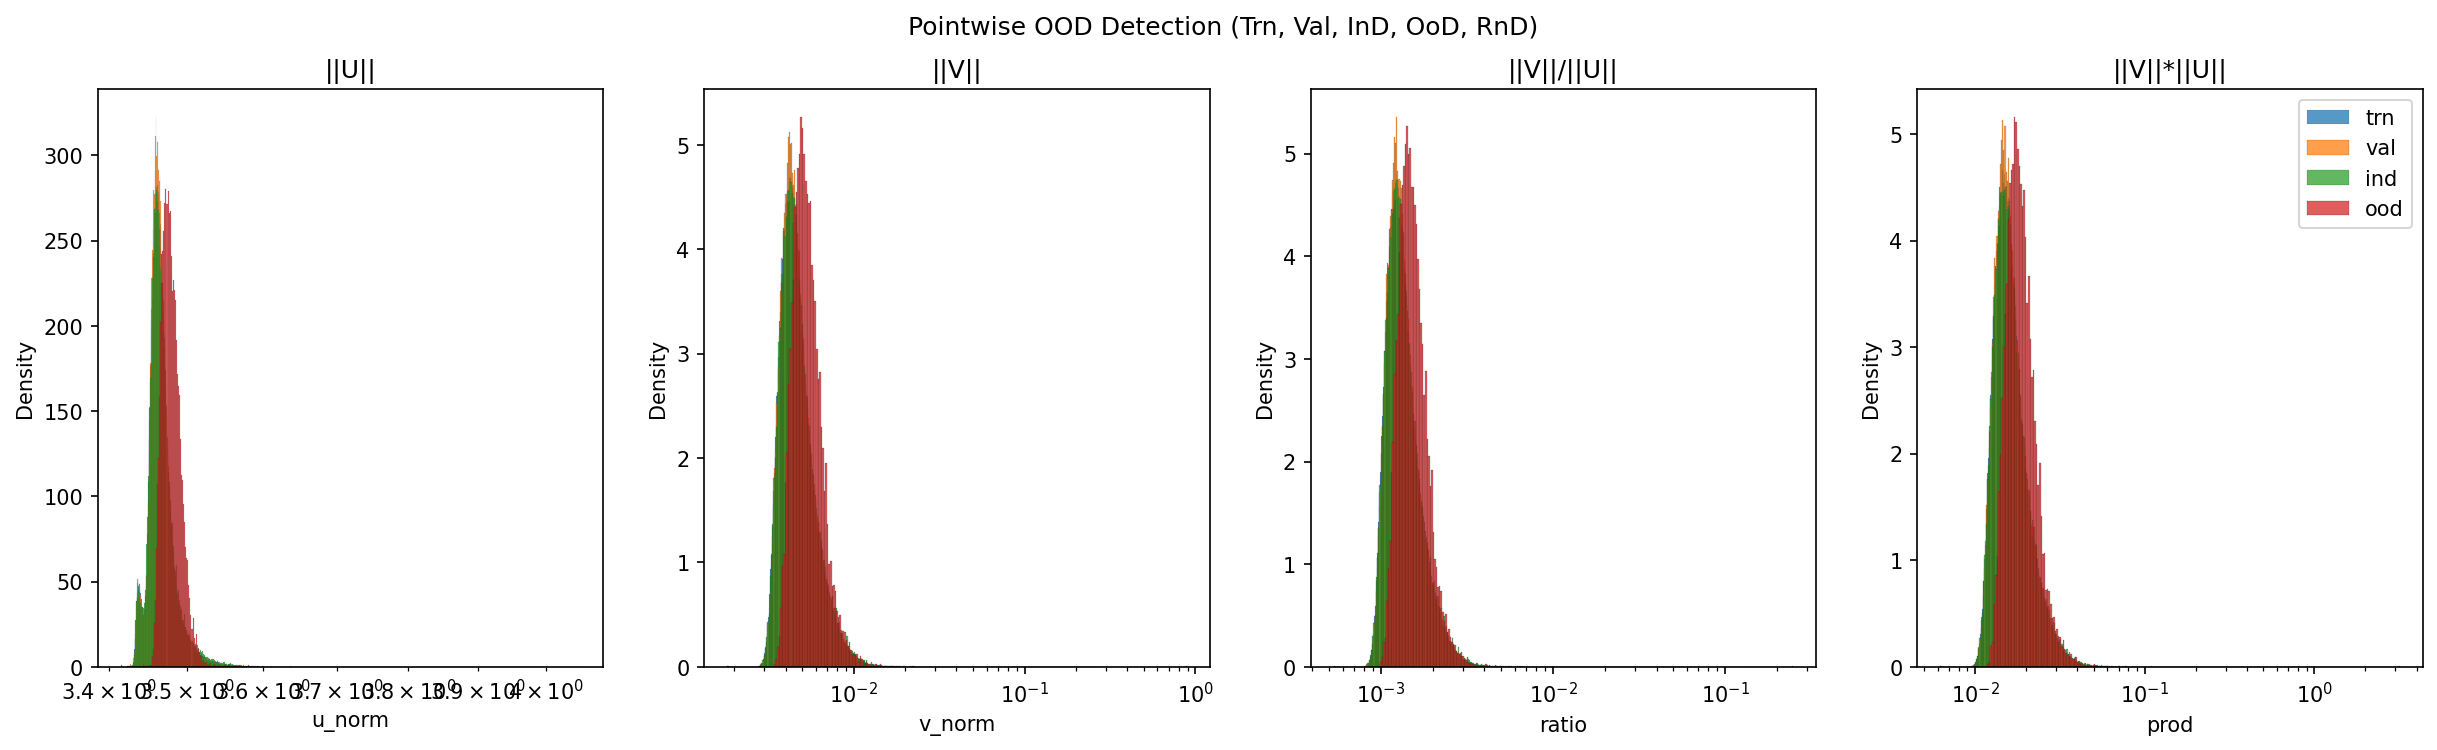

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.0018200321 0.49450204 0.492682
Val 0.0018200321 0.26469308 0.26287305
Ind 0.0018200321 0.20160334 0.19978331
Ood 0.0018200321 0.8887756 0.88695556
Rnd 11.96167 15.027627 3.065957
KstestResult(statistic=0.2978775844694659, pvalue=0.0, statistic_location=0.00452502, statistic_sign=1)


[0 1 3 2 4]


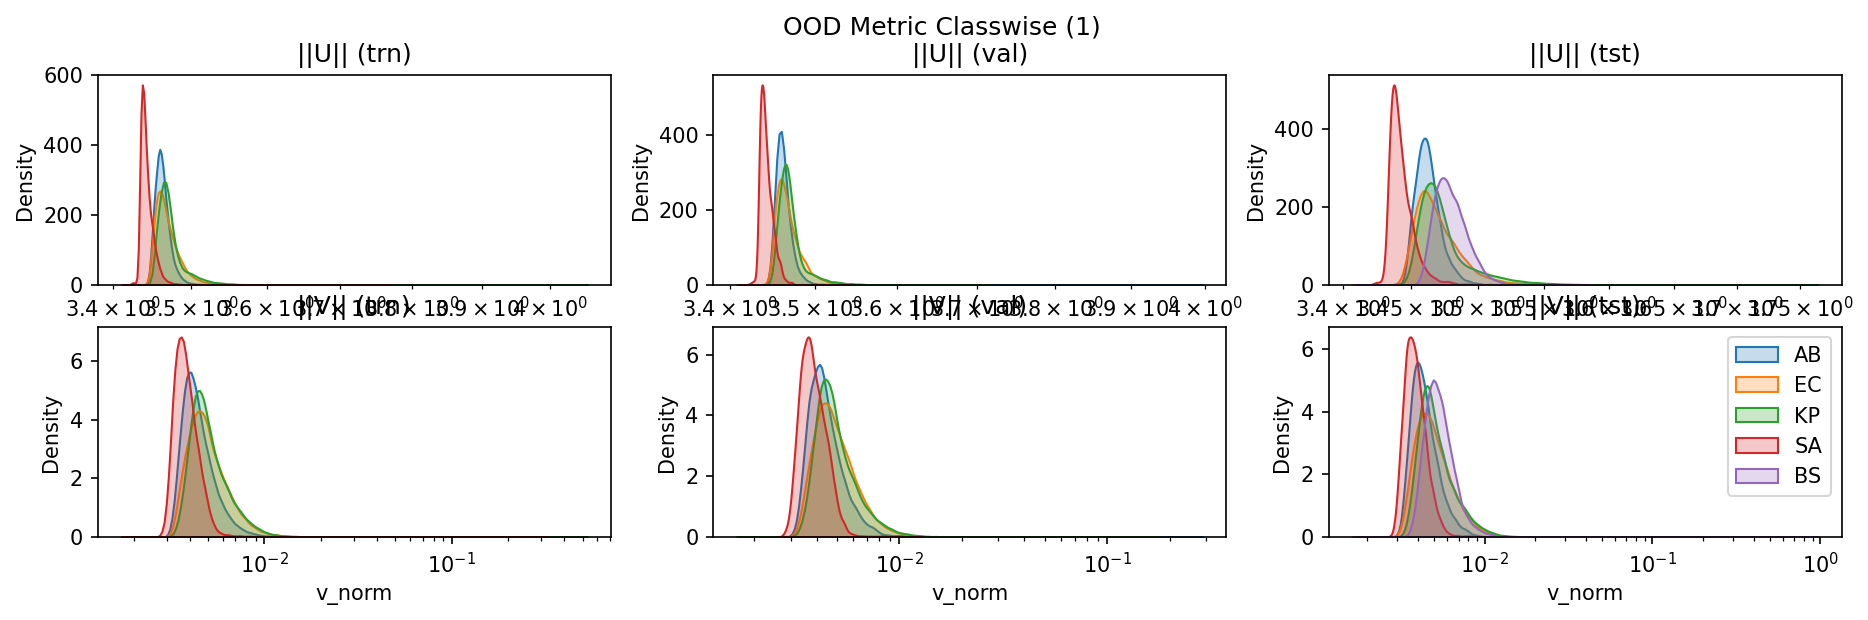

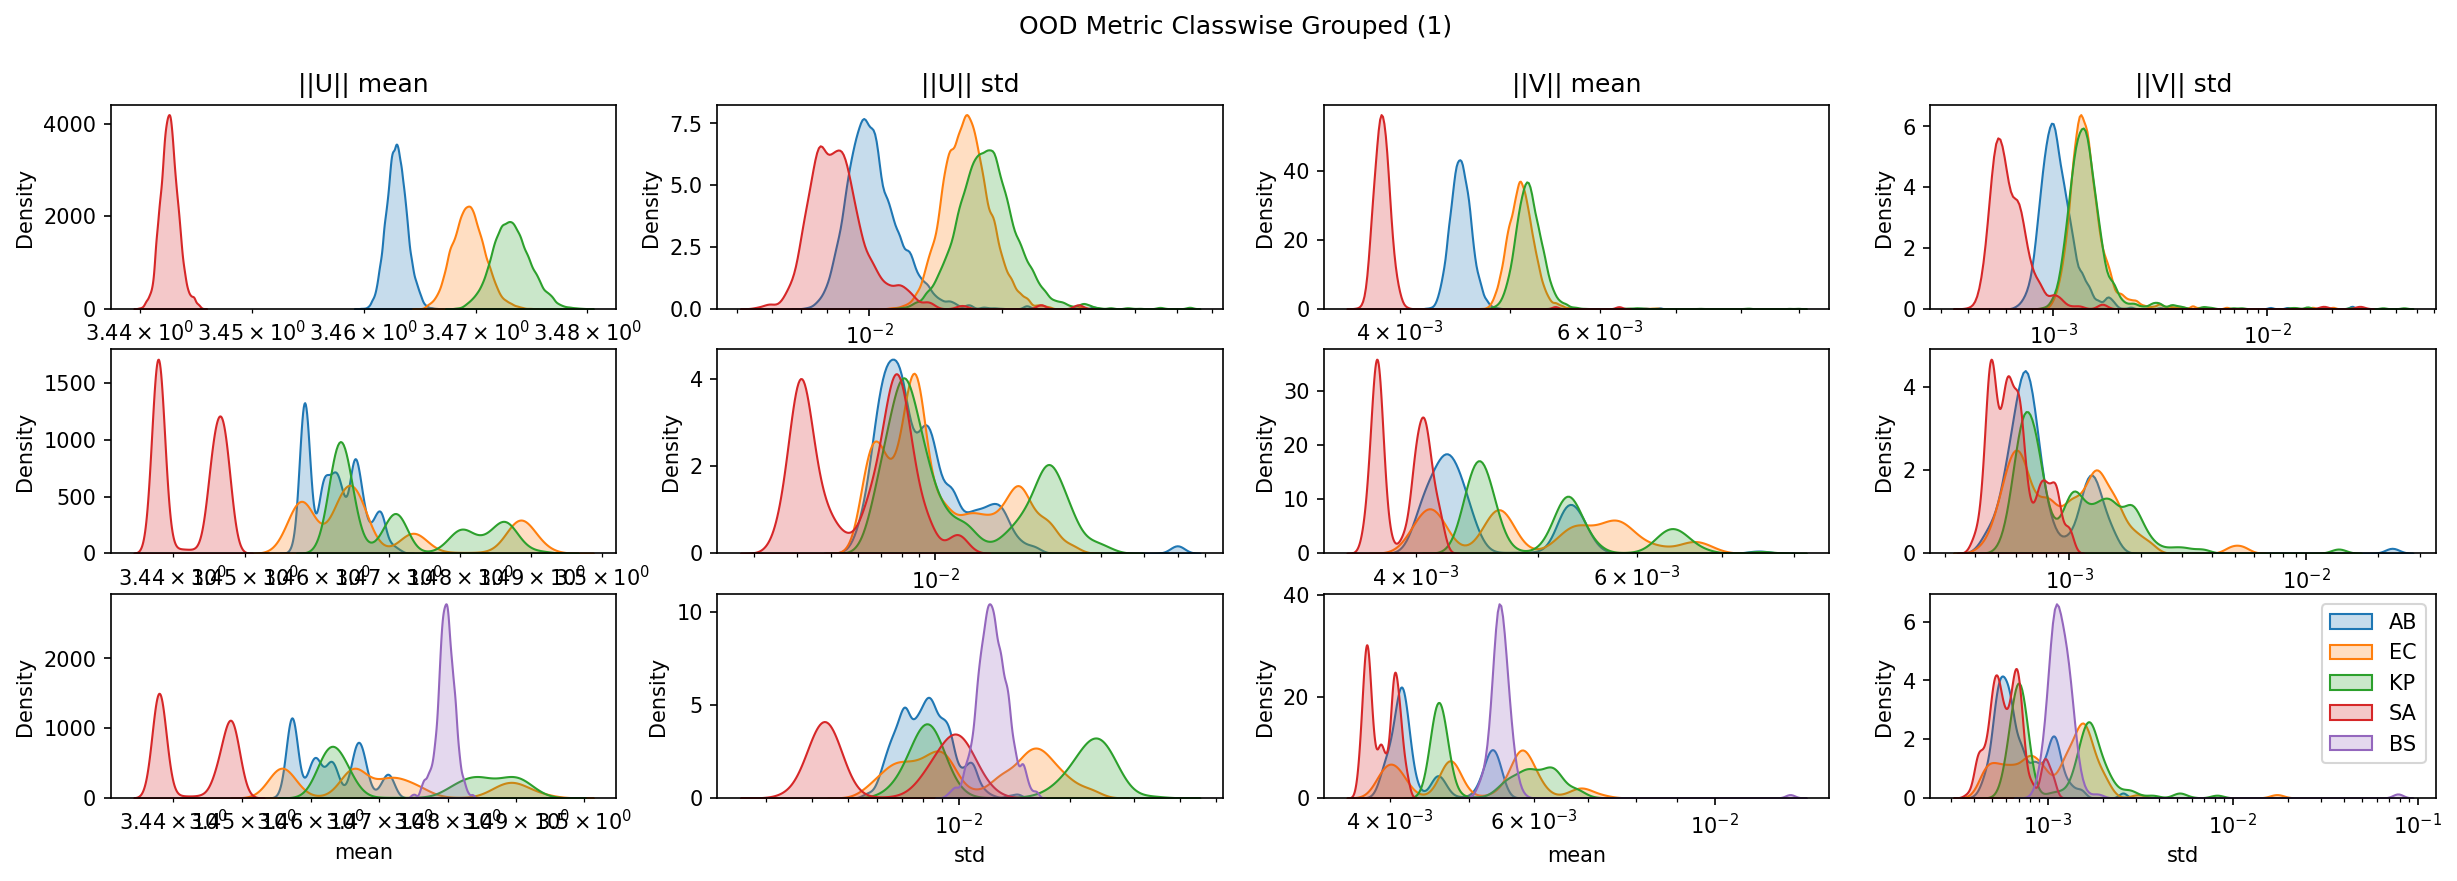

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)